# DEEP EUTECTIC SOLVENTS. DENSITY. ML ALGORITHMS 

## 1. Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.neighbors import KNeighborsRegressor
from skopt.space import Integer, Real, Categorical 
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBRegressor
import shap
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
plt.style.use('seaborn')

c:\Users\lera-\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1. Working with the table
First you need to edit the table a little and see its main characteristics for further machine learning

In [2]:
#We move the predicted column to the end for convenience
db_final1 = pd.read_csv('density_df_ML.csv')
db_final = db_final1.drop(columns=['Density, g/cm^3'])
db_final.insert(0, 'Density, g/cm^3', db_final1['Density, g/cm^3'])
db_final = db_final.drop(['Unnamed: 0', 'isomer_smiles#1', 'isomer_smiles#2', 'isomer_smiles#3'], axis = 1)

In [3]:
colors = ['#a5678e','#e8b7d4', '#beb7d9', '#7eabd4', '#31539d'] # Palette of colors

In [4]:
#Summary table description
db_final.describe()

Density, g/cm^3  X#1 (molar fraction)  X#2 (molar fraction)  \
count      4023.000000           4023.000000           4023.000000   
mean          1.102685              0.339358              0.631537   
std           0.168574              0.195431              0.202706   
min           0.806000              0.034000              0.078000   
25%           0.996560              0.200000              0.500000   
50%           1.087000              0.333000              0.667000   
75%           1.185493              0.500000              0.800000   
max           1.988000              0.917000              0.950000   

       X#3 (molar fraction)            I           II         III  \
count           4023.000000  4023.000000  4023.000000  4023.00000   
mean               0.028610     0.014666     0.000497     0.64355   
std                0.122092     0.120226     0.022294     0.47901   
min                0.000000     0.000000     0.000000     0.00000   
25%                0.000000     0.000000     0.000000     0.00000   
50%                0.000000     0.000000     0.000000     1.00000   
75%                0.000000     0.000000     0.000000     1.00000   
max                0.843000     1.000000     1.000000     1.00000   

                IV            V  Temperature, K  ...           Al  \
count  4023.000000  4023.000000     4023.000000  ...  4023.000000   
mean      0.076808     0.348993      320.802819  ...     0.016504   
std       0.266320     0.476711       20.840671  ...     0.095252   
min       0.000000     0.000000      278.150000  ...     0.000000   
25%       0.000000     0.000000      303.150000  ...     0.000000   
50%       0.000000     0.000000      318.150000  ...     0.000000   
75%       0.000000     1.000000      333.150000  ...     0.000000   
max       1.000000     1.000000      413.150000  ...     0.667000   

                 P            S           Cl            K           Fe  \
count  4023.000000  4023.000000  4023.000000  4023.000000  4023.000000   
mean      0.016653     0.016844     0.238318     0.002624     0.001938   
std       0.074733     0.094404     0.363968     0.020760     0.028757   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.143000     0.000000     0.000000   
75%       0.000000     0.000000     0.333000     0.000000     0.000000   
max       0.667000     0.667000     3.001000     0.400000     0.667000   

                Cu           Zn           Br     ind_syst  
count  4023.000000  4023.000000  4023.000000  4023.000000  
mean      0.000166     0.001118     0.030770   167.465076  
std       0.010516     0.021395     0.097856   115.642087  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000    66.000000  
50%       0.000000     0.000000     0.000000   132.000000  
75%       0.000000     0.000000     0.000000   269.000000  
max       0.667000     0.667000     0.999000   403.000000  

[8 rows x 33 columns]

### 1.2. Splitting data into test and train

In [5]:
# A function for splitting data so that different systems appear in the test and train sample
def custom_cv(x,y,groups,n_splits,test_size):
    custom_cv = []
    kfold = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42) #randomized test/train indexes to split data according to a third-party group provided
    for train_idx, test_idx in kfold.split(x, y, groups): 
        custom_cv.append((train_idx, test_idx)) #Returning data as a tuple
    return custom_cv

In [6]:
# We split the sample so that there are different systems in the test and training
y = db_final.loc[:,'Density, g/cm^3']
x = db_final.loc[:,'X#1 (molar fraction)':]
cv = custom_cv(x, y, db_final['ind_syst'], 1, 0.2) #Separation using the function
for train_idx, val_idx in cv:
    x_train, x_test = x.iloc[train_idx], x.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]

### 1.3. Functions for plotting and calculating metrics

In [7]:
#Let's introduce a function for plotting graphs
def regr_plot(y_train, y_test, y_pred, y1_pred):
    f, ax = plt.subplots(figsize=(15, 10)) #Initialization - creating an empty graph
    plt.scatter(y_train, y1_pred, color=colors[4], s=70, label='Train') #Prediction for the training sample
    plt.scatter(y_test, y_pred, color=colors[1],s=70, label='Test') #Prediction for the test sample
    plt.plot(y_train, y_train, color=colors[0]) #Building a straight line
    plt.xlabel('Test data', fontsize=35) #Signatures
    plt.ylabel('Predicted data', fontsize=35)
    plt.legend(fontsize = 30, frameon=False) #Creating a legend
    plt.xlim(0.5, 2.1) #Intervals of x and y
    plt.ylim(0.5, 2.1)
    plt.tick_params(axis='both', which='major', labelsize=30)
    x = x = np.linspace(0.5, 2.1, 100)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    plt.fill_between(x, x-RMSE, x+RMSE, interpolate=True, color=colors[2], alpha=0.2)
    

In [8]:
#Let's introduce a function for calculating metrics
def regr_metrics(regr, x_train, y_train, y_test, y_pred, y1_pred):
    #Calculation of metrics
    R2 = metrics.r2_score(y_test, y_pred)
    R2_train = metrics.r2_score(y_train, y1_pred)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, y1_pred))
    #print('Q2:', Q2)
    #Metrics output
    print('r2_test:', R2)
    print('MAE_test:', MAE)
    print('MSE_test:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE_test:', RMSE)
    print('r2_train:', metrics.r2_score(y_train, y1_pred))
    print('MAE_train:', metrics.mean_absolute_error(y_train, y1_pred))
    print('MSE_train:', metrics.mean_squared_error(y_train, y1_pred))
    print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, y1_pred)))
    return [R2_train, R2, RMSE_train, RMSE]

In [9]:
#Function for finding metrics by different classes
def metrics_class(df, Name_method):
    df_error = pd.DataFrame(columns = ['Algorithm MO', 'Num_comp', 'Type', 'R2_train', 'R2_test', 'RMSE_train', 'RMSE_test']) 
    for num_fold in range(5):
        for type_DES in ['I','III','IV','V']:
            condition = (df['X#3 (molar fraction)'] == 0) & (df[type_DES] == 1) #Selection of binary systems of a certain class
            df_train = df[condition]
            df_test = df[condition]
            df_train = df_train.dropna(subset=['Density_train'+ str(num_fold)])
            df_test = df_test.dropna(subset=['Density_test'+ str(num_fold)])
            try:
                #Finding metrics
                R2_train = metrics.r2_score(df_train['Density_lit'], df_train['Density_train' + str(num_fold)])
                RMSE_train = np.sqrt(metrics.mean_squared_error(df_train['Density_lit'], df_train['Density_train' + str(num_fold)]))
            except:
                #If it is impossible, None is returned
                R2_train = None
                RMSE_train = None
            try:
                R2_test = metrics.r2_score(df_test['Density_lit'], df_test['Density_test' + str(num_fold)])
                RMSE_test = np.sqrt(metrics.mean_squared_error(df_test['Density_lit'], df_test['Density_test' + str(num_fold)]))
            except:
                R2_test = None
                RMSE_test = None
            df_error.loc[ len(df_error.index )] = [Name_method + str(num_fold), 2, type_DES, R2_train, R2_test, RMSE_train, RMSE_test]
        #For ternary systems
        condition = (df['X#3 (molar fraction)'] != 0)
        df_train = df[condition]
        df_test = df[condition]
        df_train = df_train.dropna(subset=['Density_train' + str(num_fold)])
        df_test = df_test.dropna(subset=['Density_test' + str(num_fold)])
        R2_train = metrics.r2_score(df_train['Density_lit'], df_train['Density_train'+ str(num_fold)])
        RMSE_train = np.sqrt(metrics.mean_squared_error(df_train['Density_lit'], df_train['Density_train'+ str(num_fold)]))
        R2_test = metrics.r2_score(df_test['Density_lit'], df_test['Density_test'+ str(num_fold)])
        RMSE_test = np.sqrt(metrics.mean_squared_error(df_test['Density_lit'], df_test['Density_test'+ str(num_fold)]))
        df_error.loc[len(df_error.index)] = [Name_method + str(num_fold), 3, None, R2_train, R2_test, RMSE_train, RMSE_test]
      #The function returns a table
    return df_error

In [10]:
db_final.rename(columns = {'C':'Number of C', 
                     'Metal_frac_gen':'Mass fraction of metal ',
                     'NumHeteroatoms':'Number of Heteroatoms',
                     'N':'Number of N',
                     'X#3 (molar fraction)':'Molar fraction of component#3',
                     'O':'Number of O',
                     'Br':'Number of Br',
                     'Cl':'Number of Cl',
                     'SpherocityIndex':'Spherocity Index',
                     'VdWVolume, A^3#2':'Van der Waals volume of component #2',
                     'VdWVolume, A^3#3':'Van der Waals volume of component #3',
                     'Temperature, K':'Temperature of experiment, K',
                     }, inplace = True )

In [11]:
#Let's introduce the Feature importance function
list_columns = db_final.loc[:, 'X#1 (molar fraction)' : 'Number of Br'].columns
def regr_feature(regr, x_test, list_columns):
    explainer = shap.TreeExplainer(regr)
    shap_values = explainer.shap_values(x_test)
    f, ax = plt.subplots(figsize=(15, 13))
    shap.summary_plot(shap_values, x_test, plot_type='bar', color=colors[0], title='Feature importance', feature_names=list_columns, max_display = 10)

## 2. Linear Regression
Linear regression is the simplest machine learning method that finds a linear equation that best describes the correlation of dependent variables with independent ones


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



r2_test: 0.8488347527124178
MAE_test: 0.05458051187489701
MSE_test: 0.005524273940824324
RMSE_test: 0.07432545957358302
r2_train: 0.8652673709724314
MAE_train: 0.041541093131953186
MSE_train: 0.003127639992835261
RMSE_train: 0.05592530726634643
r2_test: 0.08185277333109797
MAE_test: 0.053873647306340026
MSE_test: 0.01737317440269244
RMSE_test: 0.13180733819743284
r2_train: 0.8751569624016223
MAE_train: 0.04084607399053505
MSE_train: 0.0033833708408569346
RMSE_train: 0.05816675030339012
r2_test: 0.5823143296553068
MAE_test: 0.04774806593706427
MSE_test: 0.005494598947251904
RMSE_test: 0.07412556203666792
r2_train: 0.8916151567216468
MAE_train: 0.04047767388315285
MSE_train: 0.00315045330771607
RMSE_train: 0.05612889904243687
r2_test: 0.8145344029779673
MAE_test: 0.051613904336973784
MSE_test: 0.00866444540135381
RMSE_test: 0.09308300275213413
r2_train: 0.8518053815432203
MAE_train: 0.038357476406524545
MSE_train: 0.0029746082979593743
RMSE_train: 0.05453996972825869
r2_test: 0.807343269


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  
0            0.851805            0.894298  
1            0.814534            0.807343  
2            0.054540            0.052841  
3            0.093083            0.068789

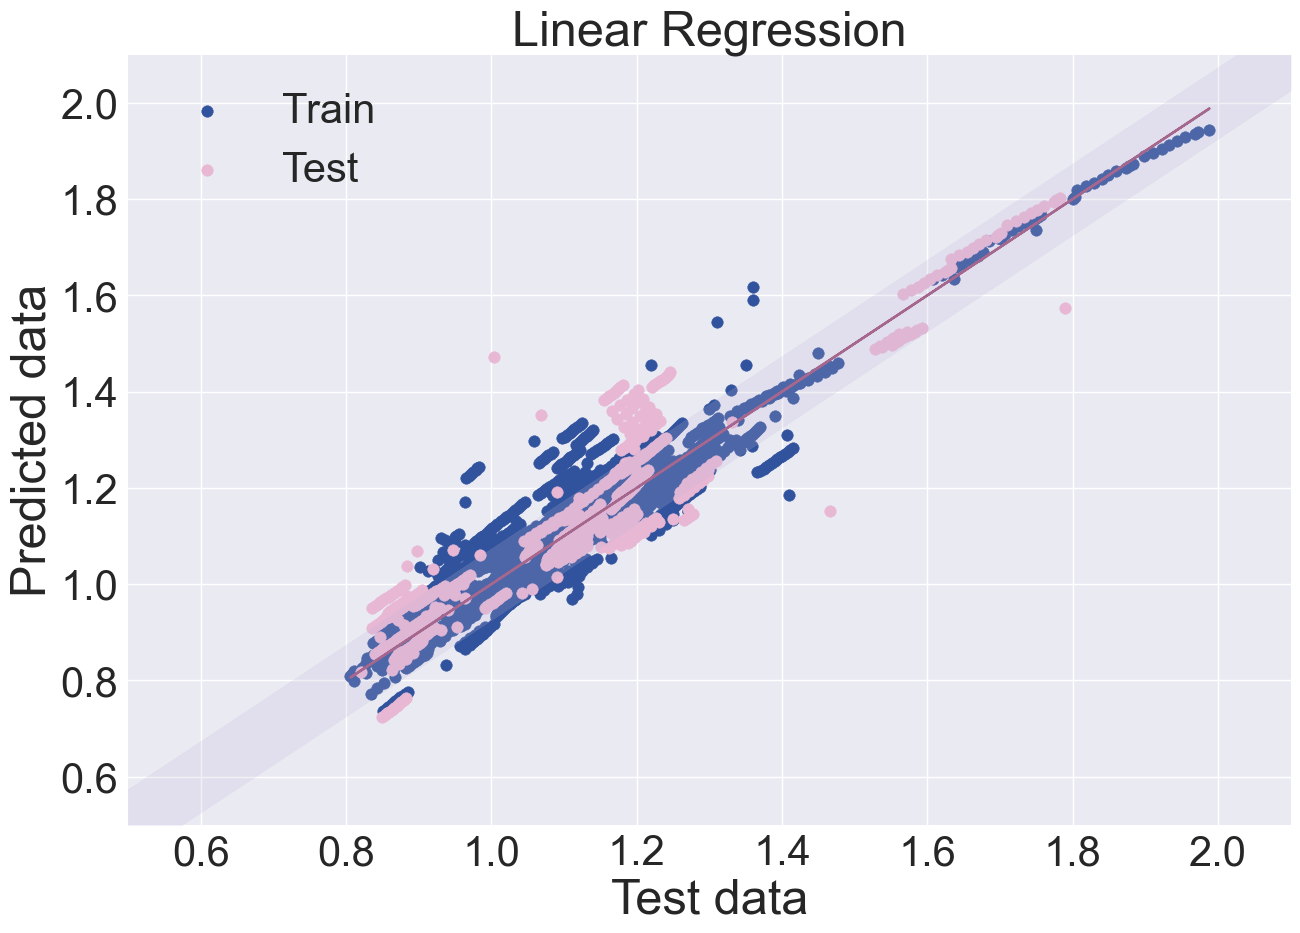

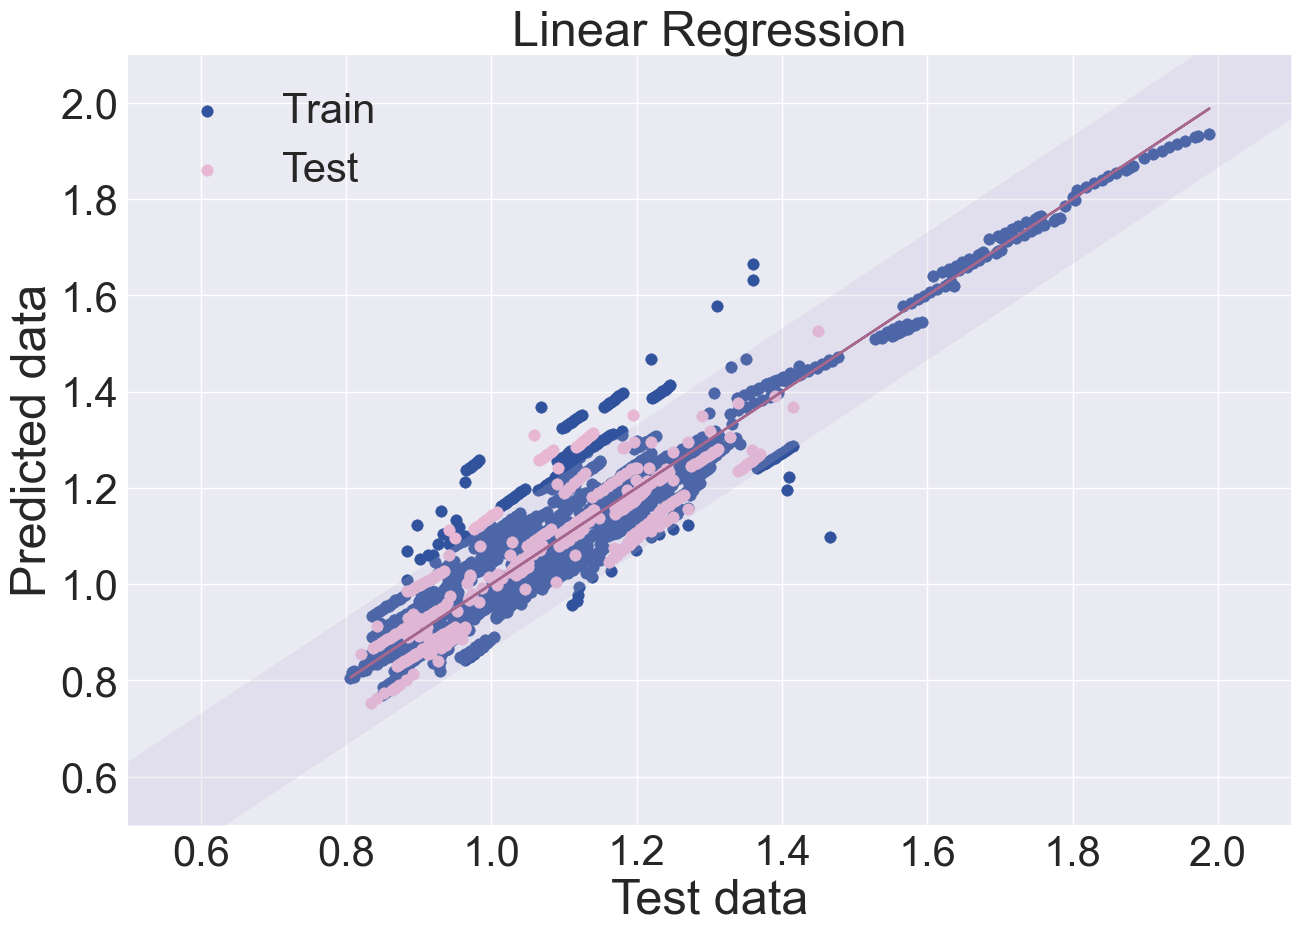

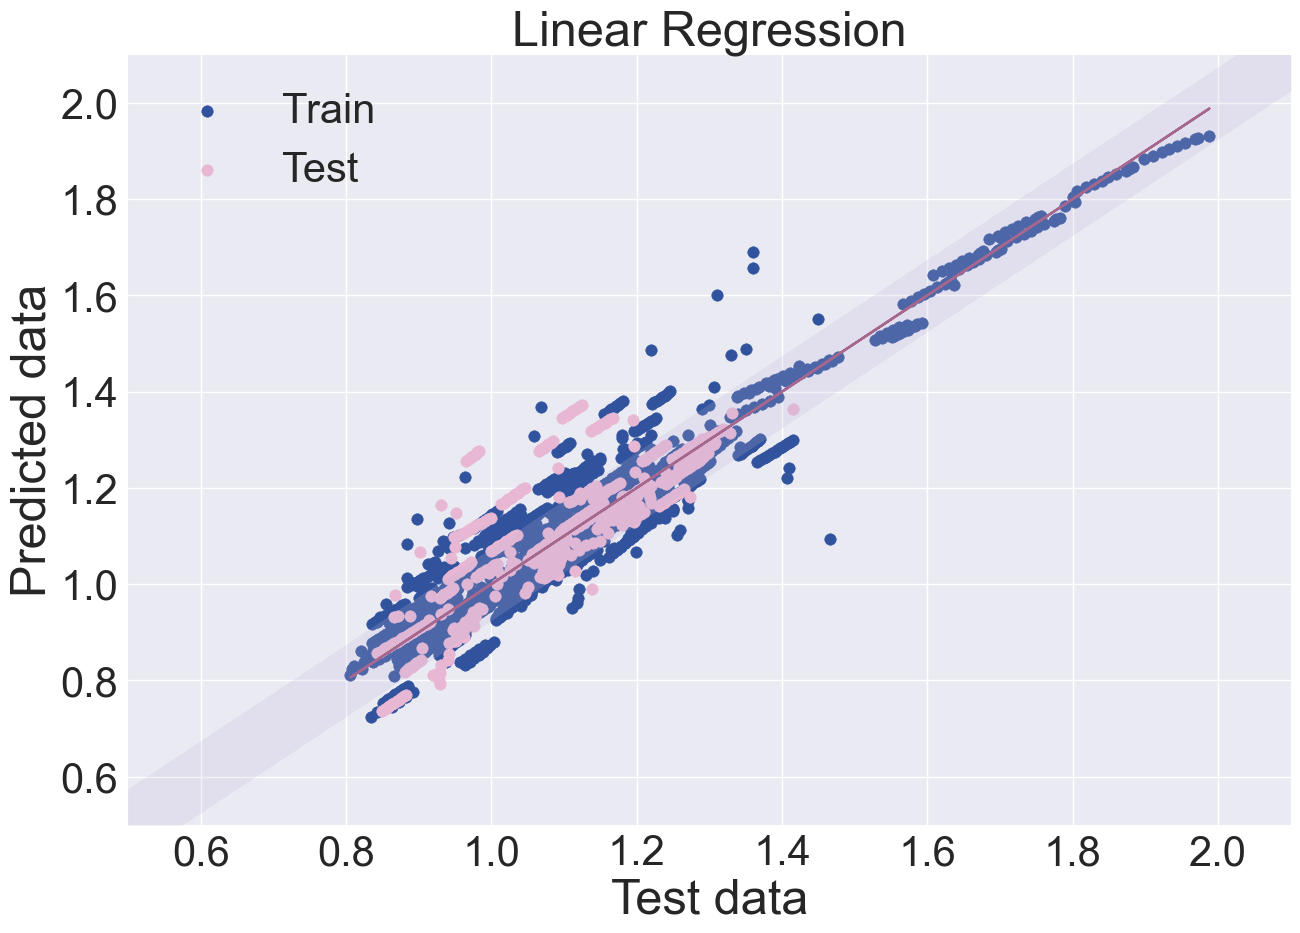

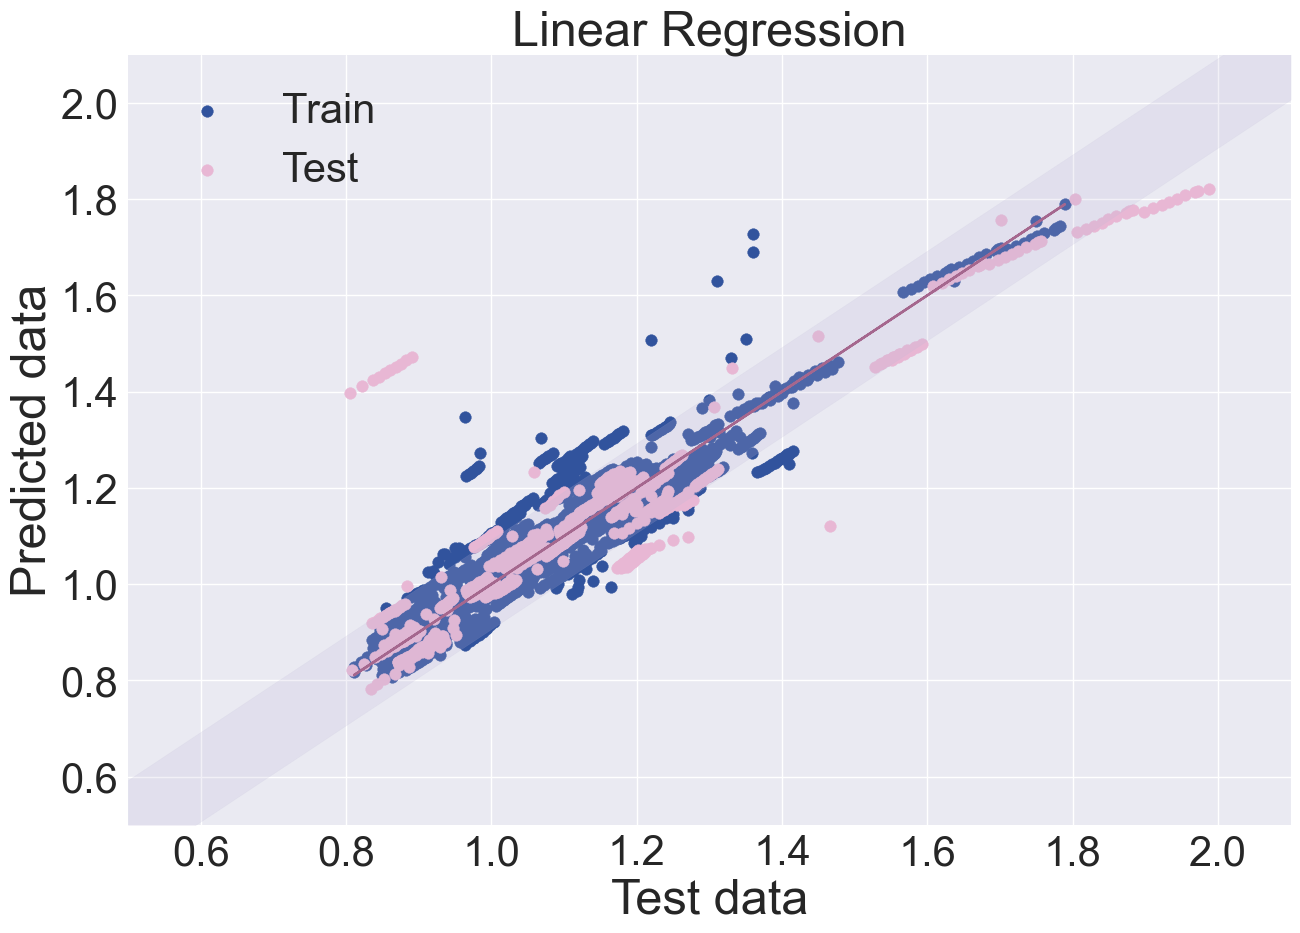

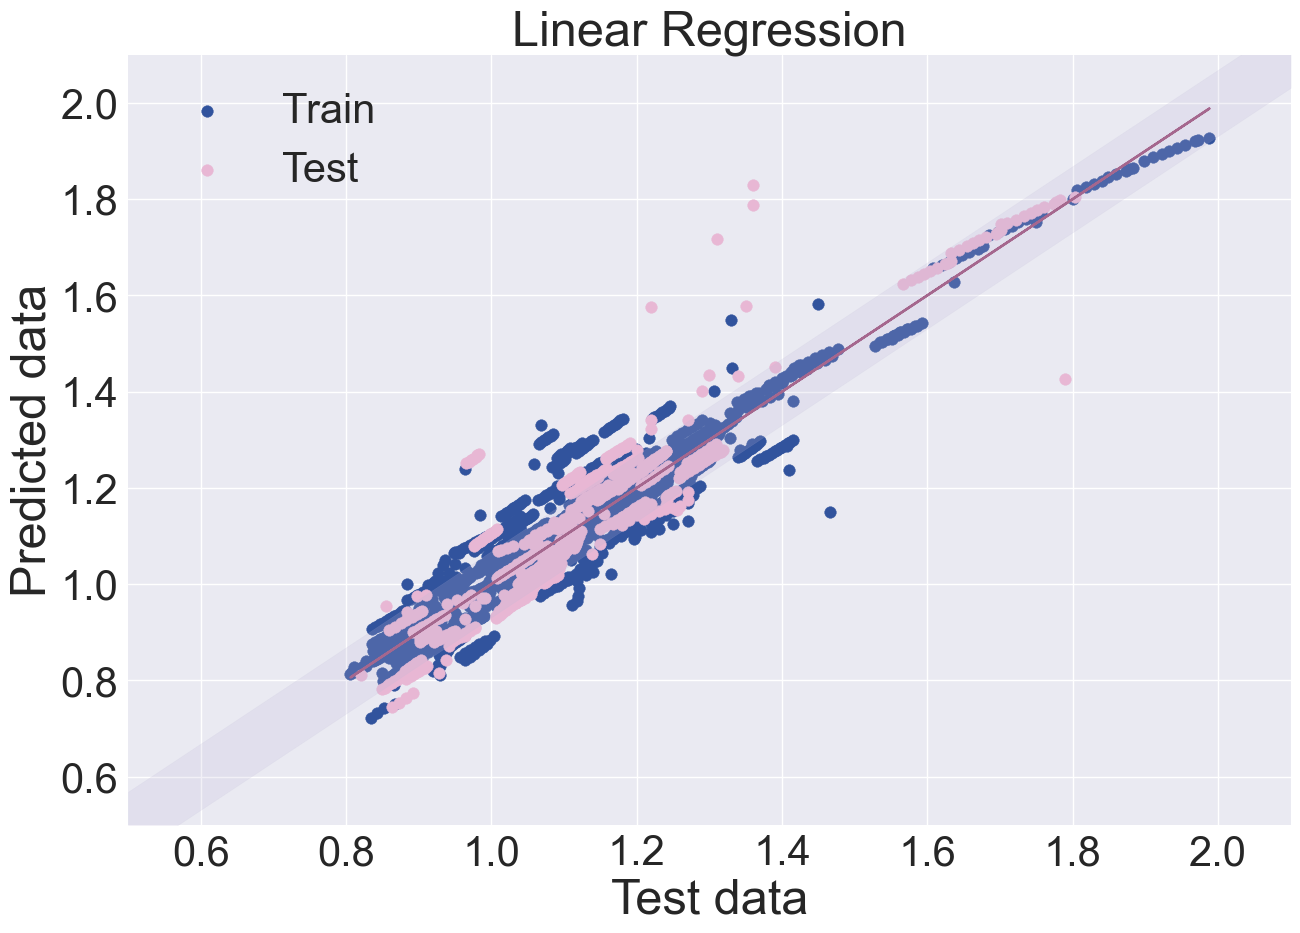

In [12]:
#LR for training dataset
# We split the sample so that there are different systems in the test and training
df_error_train = pd.DataFrame()
x_model = x_train.copy().drop(['ind_syst'],axis=1)

y_model = y_train.copy()
cv = custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2)
count = 0    
#Creating a table to check accuracy on different DES classes
LR_df = x_model[:]
LR_df['Density_lit'] = y_model

   #Scaling the data 
for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    x_train_mod.to_csv('new.csv') 
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
   #Linear regression
    regr_LR = LinearRegression()
    regr_LR.fit(x_train_mod, y_train_mod, sample_weight=sample_w)
    y_pred = regr_LR.predict(x_test_mod)
    y1_pred = regr_LR.predict(x_train_mod)

    #Filling in the table in accordance with the metrics
    LR_df['Density_train' + str(count)] = None
    LR_df['Density_test' + str(count)] = None
    LR_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    LR_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Linear Regression' + str(count)] = regr_metrics(regr_LR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    
   #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Linear Regression', fontsize=35)
df_error_train

In [13]:
df_error_LR = metrics_class(LR_df, 'Linear Regression')
df_error_LR

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train   R2_test  RMSE_train  \
0   Linear Regression0         2     I  0.744212       NaN    0.032737   
1   Linear Regression0         2   III  0.652779  0.307615    0.054459   
2   Linear Regression0         2    IV  0.745421  0.857302    0.032102   
3   Linear Regression0         2     V  0.812925  0.651371    0.061549   
4   Linear Regression0         3  None  0.967243  0.858484    0.057283   
5   Linear Regression1         2     I  0.745640       NaN    0.032645   
6   Linear Regression1         2   III  0.576787  0.514284    0.059304   
7   Linear Regression1         2    IV  0.918223 -4.466205    0.040119   
8   Linear Regression1         2     V  0.817657   0.79043    0.059482   
9   Linear Regression1         3  None  0.963008  0.529712    0.052261   
10  Linear Regression2         2     I  0.829377      None    0.030132   
11  Linear Regression2         2   III  0.548369  0.551118    0.060399   
12  Linear Regression2         2    IV  0.862938      None    0.047105   
13  Linear Regression2         2     V  0.891740   0.12647    0.046644   
14  Linear Regression2         3  None  0.966118  0.456883    0.056290   
15  Linear Regression3         2     I  0.840508       NaN    0.028164   
16  Linear Regression3         2   III  0.694233  0.779909    0.052416   
17  Linear Regression3         2    IV  0.889185  -0.16198    0.031436   
18  Linear Regression3         2     V  0.814786  -0.24899    0.060229   
19  Linear Regression3         3  None  0.934035  0.852653    0.066915   
20  Linear Regression4         2     I  0.819298 -0.478668    0.030789   
21  Linear Regression4         2   III  0.656445  0.439655    0.055000   
22  Linear Regression4         2    IV  0.888911   0.33244    0.041852   
23  Linear Regression4         2     V  0.859445  0.499274    0.052779   
24  Linear Regression4         3  None  0.974200  0.940856    0.041979   

   RMSE_test  
0   0.466996  
1   0.071899  
2   0.068875  
3   0.066991  
4   0.080128  
5   2.455357  
6   0.068226  
7   0.075709  
8   0.062037  
9   0.085336  
10      None  
11  0.064186  
12      None  
13  0.110085  
14   0.05064  
15  0.077938  
16  0.036102  
17  0.082964  
18  0.145945  
19  0.105518  
20   0.07296  
21  0.065007  
22  0.021243  
23   0.08714  
24  0.062895

**Output:** Linear regression has low accuracy characteristics, but can be used to compare other methods with it

## 3. Decision trees
A decision tree is a logical classification algorithm that solves classification and regression problems. It is a combination of logical conditions into a tree structure.

### 3.1. Decision Tree Regressor
A decision tree is a decision-making tool that uses a tree-like structure similar to a flowchart, or is a model of decisions and all their possible outcomes, including outcomes, input costs and utility.

In [14]:
#We optimize for DTR
regr_DTR = DecisionTreeRegressor()

search_space = {"max_depth": Integer(1, 13),
                "criterion": Categorical(['squared_error', 'absolute_error']), 
                "min_samples_split": Real(0.01, 0.5), 
                "min_samples_leaf": Real(0.01, 0.2), 
                "max_features": Categorical(['auto', 'sqrt', 'log2'])}

#Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_DTR = BayesSearchCV(estimator = regr_DTR, search_spaces=search_space, cv=custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_DTR.fit(x_train01, y_model, sample_weight=sample_weight)


criterion = opt_DTR.best_estimator_.criterion
max_depth = opt_DTR.best_estimator_.max_depth
min_samples_split = opt_DTR.best_estimator_.min_samples_split
min_samples_leaf = opt_DTR.best_estimator_.min_samples_leaf
max_features = opt_DTR.best_estimator_.max_features


print('criterion:', criterion,'max_depth:', max_depth, 'min_samples_split:', min_samples_split,'min_samples_leaf:', min_samples_leaf,'max_features:', max_features)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.


criterion: absolute_error max_depth: 12 min_samples_split: 0.01 min_samples_leaf: 0.01 max_features: auto



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame


r2_test: 0.6455120028622323
MAE_test: 0.07245740010166916
MSE_test: 0.012954623103269626
RMSE_test: 0.11381837770443587
r2_train: 0.7303364641050154
MAE_train: 0.03889112187251148
MSE_train: 0.006259882743785436
RMSE_train: 0.07911942077508806



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`max_features='auto'` has been deprecated in 1.1 and will 

r2_test: 0.42665341814093016
MAE_test: 0.07545069664453959
MSE_test: 0.010848859388231026
RMSE_test: 0.10415785802439981
r2_train: 0.6887893659758013
MAE_train: 0.06109935104529243
MSE_train: 0.008434118592255046
RMSE_train: 0.09183745745748326



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`max_features='auto'` has been deprecated in 1.1 and will 

r2_test: 0.02213123021445884
MAE_test: 0.08118399999839745
MSE_test: 0.01286373245359389
RMSE_test: 0.11341839556965128
r2_train: 0.8971045184578258
MAE_train: 0.033778870796751036
MSE_train: 0.0029908924566238097
RMSE_train: 0.05468905243852566



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`max_features='auto'` has been deprecated in 1.1 and will 

r2_test: 0.7624183833571412
MAE_test: 0.05847424786685552
MSE_test: 0.011099163288611833
RMSE_test: 0.10535256659717329
r2_train: 0.7849804047442464
MAE_train: 0.04001710201364522
MSE_train: 0.004315939937172328
RMSE_train: 0.0656958136959451
r2_test: 0.8027035752897858
MAE_test: 0.04737151031636865
MSE_test: 0.0048459122033559544
RMSE_test: 0.06961258652970707
r2_train: 0.7992451202628599
MAE_train: 0.03804894929166667
MSE_train: 0.0053031311032743994
RMSE_train: 0.07282260022324388



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  
0                   0.784980                   0.799245  
1                   0.762418                   0.802704  
2                   0.065696                   0.072823  
3                   0.105353                   0.069613

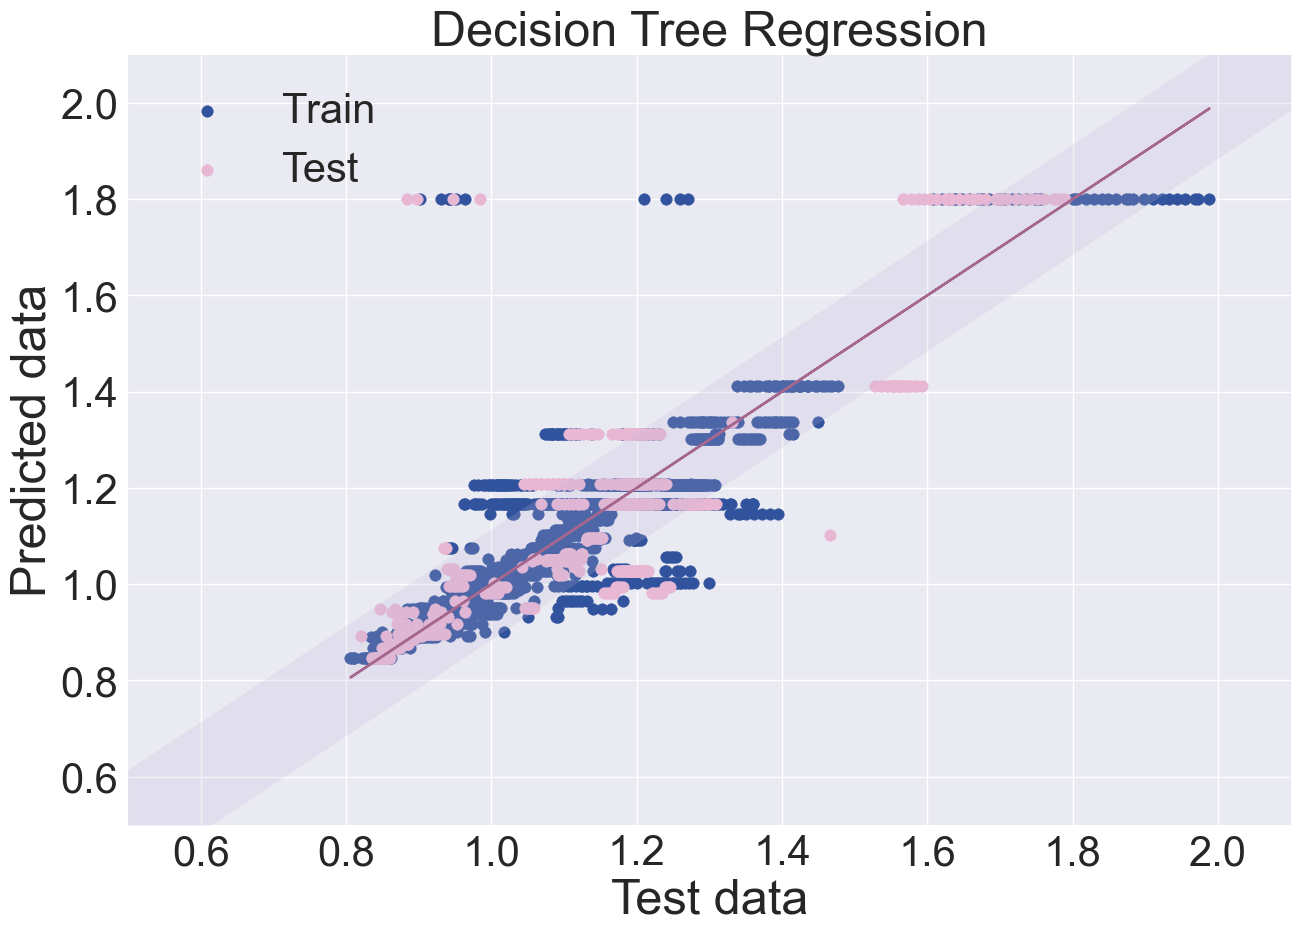

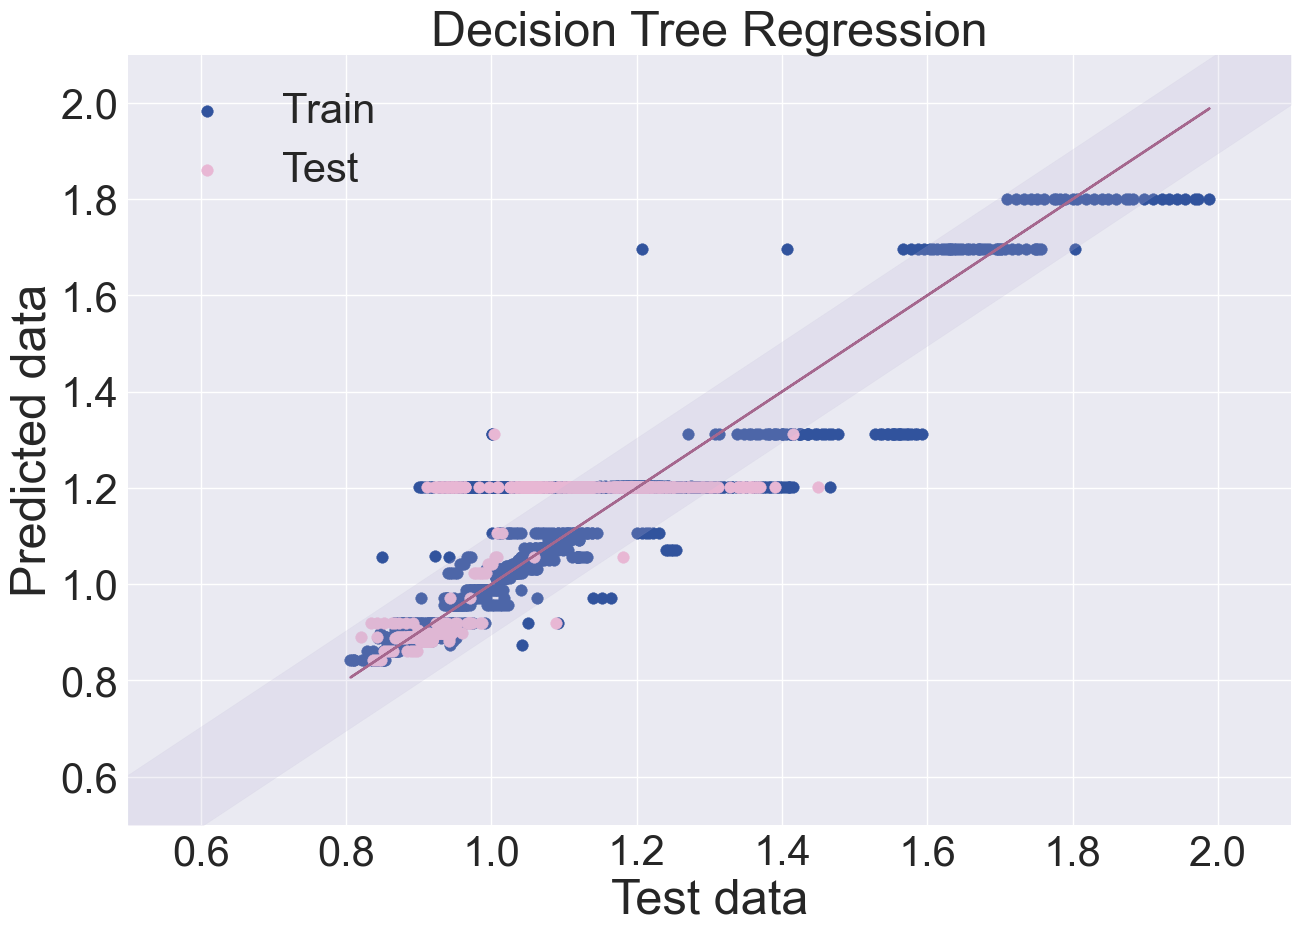

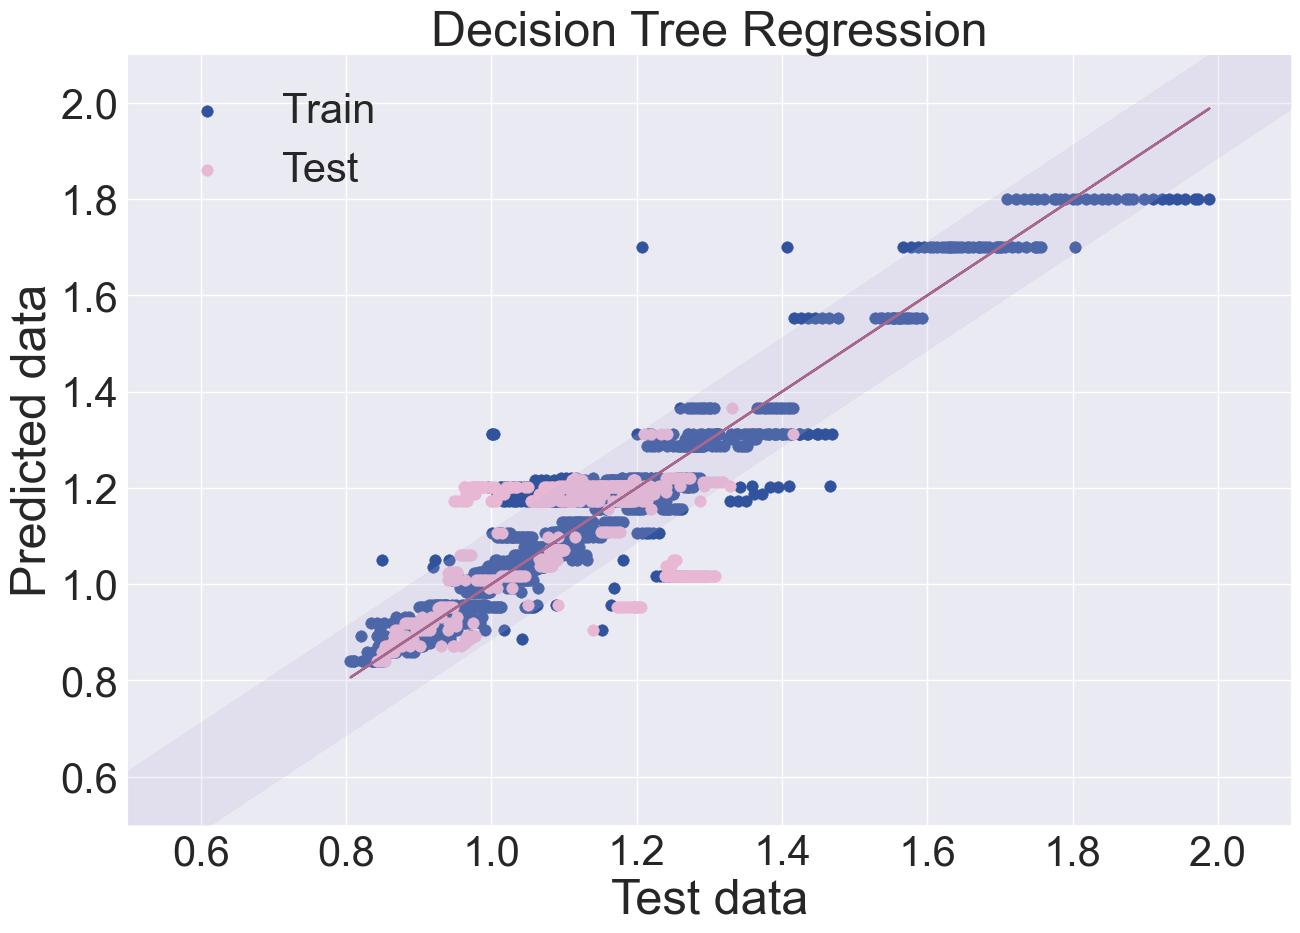

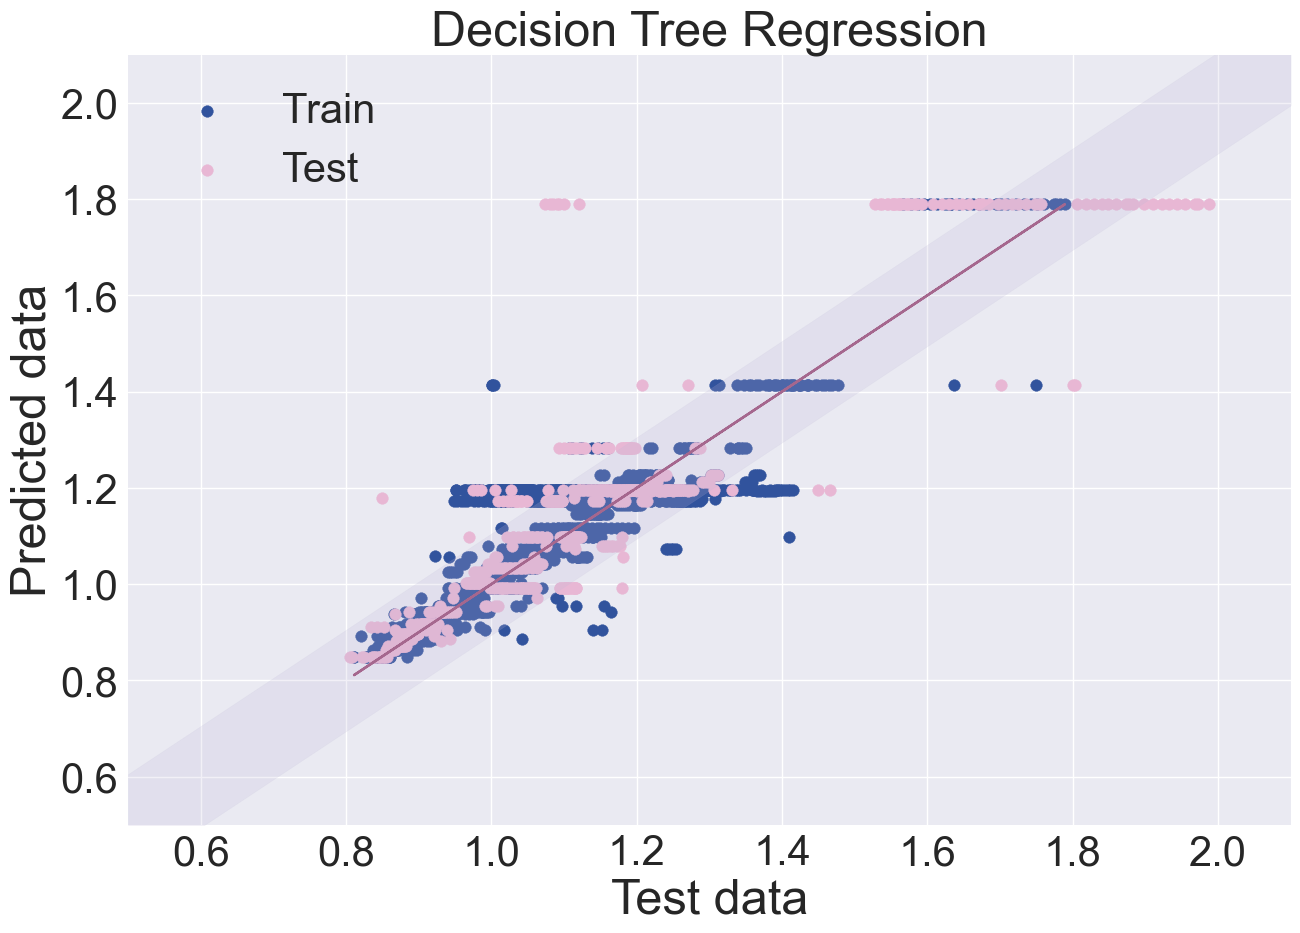

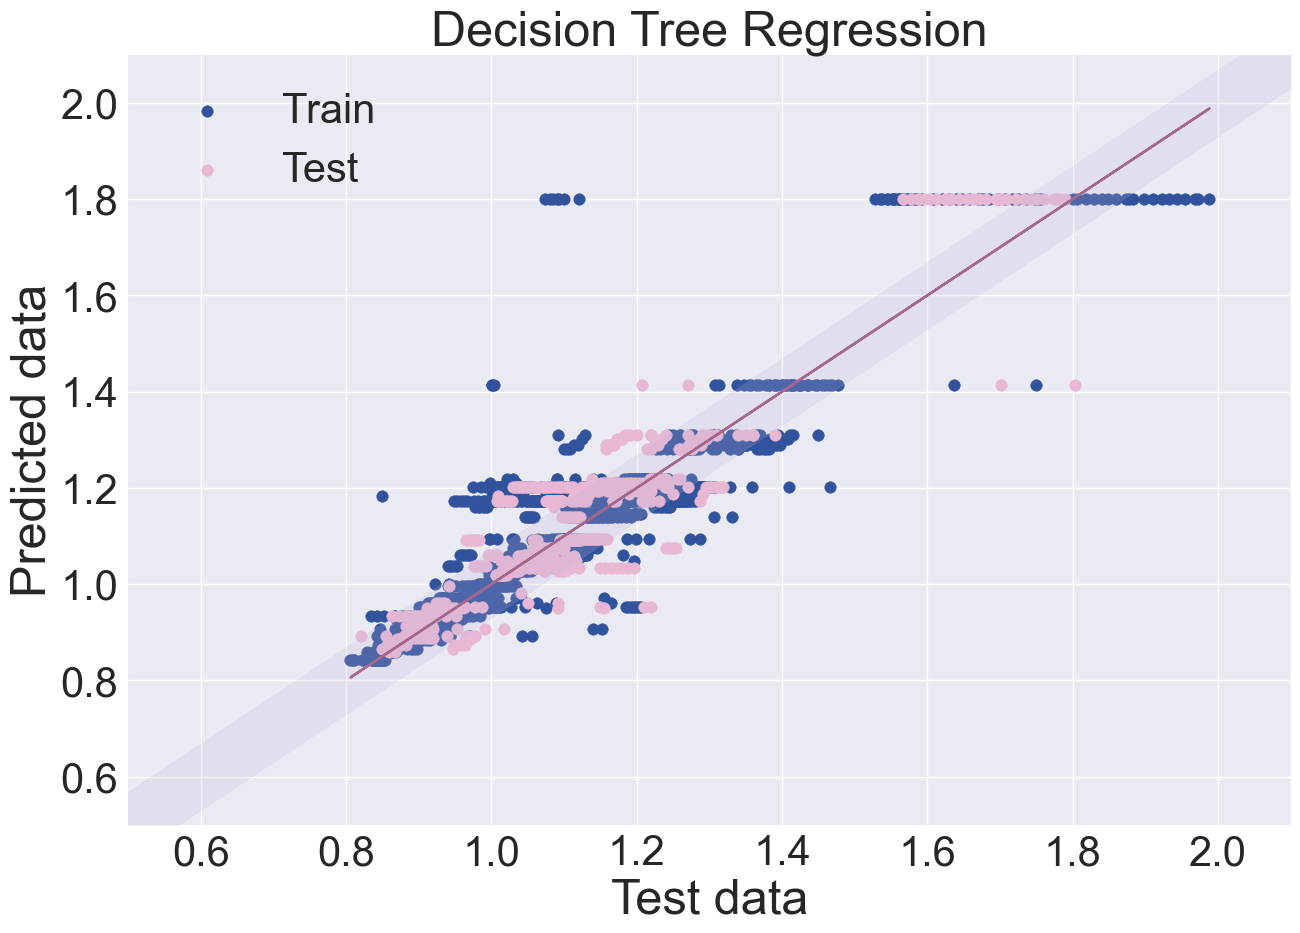

In [15]:
count = 0
#Creating a table to check accuracy on different DES classes
DTR_df = x_model[:]
DTR_df['Density_lit'] = y_model
for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #DTR
    regr_DTR = DecisionTreeRegressor(criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, max_features = max_features)
    regr_DTR.fit(x_train_mod, y_train_mod,sample_weight=sample_w)
    y_pred = regr_DTR.predict(x_test_mod)
    y1_pred = regr_DTR.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    DTR_df['Density_train' + str(count)] = None
    DTR_df['Density_test' + str(count)] = None
    DTR_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    DTR_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Decision Tree Regression' + str(count)] = regr_metrics(regr_DTR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Decision Tree Regression', fontsize=35)
df_error_train

In [16]:
df_error_DTR = metrics_class(DTR_df, 'Decision Tree Regressor')
df_error_DTR

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  RMSE_train  \
0   Decision Tree Regressor0         2     I  0.901708        NaN    0.020293   
1   Decision Tree Regressor0         2   III  0.543972   0.007697    0.062412   
2   Decision Tree Regressor0         2    IV  0.662346   0.672404    0.036971   
3   Decision Tree Regressor0         2     V  0.922519   0.900595    0.039610   
4   Decision Tree Regressor0         3  None  0.349994   0.043397    0.255170   
5   Decision Tree Regressor1         2     I -1.608051        NaN    0.104534   
6   Decision Tree Regressor1         2   III  0.113117  -0.376105    0.085849   
7   Decision Tree Regressor1         2    IV -0.235710 -14.365069    0.155952   
8   Decision Tree Regressor1         2     V  0.428891   0.653823    0.105269   
9   Decision Tree Regressor1         3  None  0.945721    0.19106    0.063305   
10  Decision Tree Regressor2         2     I -1.769372       None    0.121395   
11  Decision Tree Regressor2         2   III  0.609701  -0.741805    0.056149   
12  Decision Tree Regressor2         2    IV  0.573337       None    0.083109   
13  Decision Tree Regressor2         2     V  0.925498   0.265445    0.038694   
14  Decision Tree Regressor2         3  None  0.958812   0.844918    0.062062   
15  Decision Tree Regressor3         2     I -4.540699        NaN    0.165998   
16  Decision Tree Regressor3         2   III  0.584972   0.179509    0.061067   
17  Decision Tree Regressor3         2    IV  0.613149   -7.82205    0.058735   
18  Decision Tree Regressor3         2     V  0.779633   0.886161    0.065696   
19  Decision Tree Regressor3         3  None  0.854079   0.574687    0.099524   
20  Decision Tree Regressor4         2     I -4.445878  -7.324535    0.169022   
21  Decision Tree Regressor4         2   III  0.585669   0.507849    0.060401   
22  Decision Tree Regressor4         2    IV  0.195860 -61.596716    0.112602   
23  Decision Tree Regressor4         2     V  0.888770    0.70753    0.046951   
24  Decision Tree Regressor4         3  None  0.668605   0.768639    0.150453   

   RMSE_test  
0     0.0025  
1   0.086073  
2   0.104356  
3   0.035772  
4   0.208328  
5     0.3088  
6   0.114838  
7   0.126932  
8   0.079732  
9    0.11192  
10      None  
11  0.126437  
12      None  
13  0.100949  
14   0.02706  
15    0.1444  
16  0.069705  
17  0.228599  
18  0.044061  
19  0.179271  
20  0.173114  
21  0.060923  
22  0.205707  
23  0.066598  
24  0.124396

### 3.2. Random Forest Regression
Random forest  is a collective learning method for classification, regression, and other tasks that works by building multiple decision trees during training. For regression problems, the average value or the averaged forecast of individual trees is returned.

In [17]:
#We optimize for RFR
regr_RFR = RandomForestRegressor()

search_space = {"n_estimators": Integer(50,400),
    "criterion": Categorical(['squared_error', 'absolute_error']),
    "min_samples_split": Real(0.01, 0.6),
    "min_samples_leaf": Real(0.01, 0.5),
    "max_depth": Integer(1, 12),
    "max_features": Integer(3, 24)}

#Scaling the data 
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_RFR = BayesSearchCV(estimator = regr_RFR, search_spaces=search_space, cv = custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_RFR.fit(x_train01, y_model, sample_weight=sample_weight)

n_esti = opt_RFR.best_estimator_.n_estimators
criterion = opt_RFR.best_estimator_.criterion
min_leaf = opt_RFR.best_estimator_.min_samples_leaf
min_split = opt_RFR.best_estimator_.min_samples_split
depth = opt_RFR.best_estimator_.max_depth
max_feat = opt_RFR.best_estimator_.max_features

print('n_esti:', n_esti,'depth:', depth, 'criterion:', criterion, 'min_leaf:', min_leaf,'min_split:', min_split,'max_feat:', max_feat)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



r2_test: 0.6311268822526284
MAE_test: 0.07725006224322219
MSE_test: 0.013480321624227085
RMSE_test: 0.11610478725800709
r2_train: 0.6967321558019076
MAE_train: 0.060119046487665896
MSE_train: 0.007039962367696435
RMSE_train: 0.08390448359710245



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.6367732114440229
MAE_test: 0.06152107925085651
MSE_test: 0.006872974357508471
RMSE_test: 0.08290340377516758
r2_train: 0.8241291535672921
MAE_train: 0.047377968573805294
MSE_train: 0.004766275356832428
RMSE_train: 0.06903821664000619



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.501752430461367
MAE_test: 0.06351313396386221
MSE_test: 0.006554379921146309
RMSE_test: 0.08095912500235108
r2_train: 0.8580398298554047
MAE_train: 0.046457655137167916
MSE_train: 0.004126396957989599
RMSE_train: 0.06423703727593295



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8007808560160365
MAE_test: 0.0691483433072003
MSE_test: 0.00930697349626754
RMSE_test: 0.09647265672856502
r2_train: 0.686172462438486
MAE_train: 0.05528224697918136
MSE_train: 0.0062992435695692454
RMSE_train: 0.07936777412507702
r2_test: 0.8018217634575238
MAE_test: 0.05433970770176531
MSE_test: 0.004867570896488879
RMSE_test: 0.06976797901966832
r2_train: 0.8057729426122747
MAE_train: 0.04937183503550846
MSE_train: 0.005130692466748309
RMSE_train: 0.07162885219482655



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  \
0                   0.784980                   0.799245   
1                   0.762418                   0.802704   
2                   0.065696                   0.072823   
3                   0.105353                   0.069613   

   Random Forest Regression0  Random Forest Regression1  \
0                   0.696732                   0.824129   
1                   0.631127                   0.636773   
2                   0.083904                   0.069038   
3                   0.116105                   0.082903   

   Random Forest Regression2  Random Forest Regression3  \
0                   0.858040                   0.686172   
1                   0.501752                   0.800781   
2                   0.064237                   0.079368   
3                   0.080959                   0.096473   

   Random Forest Regression4  
0                   0.805773  
1                   0.801822  
2                   0.071629  
3                   0.069768

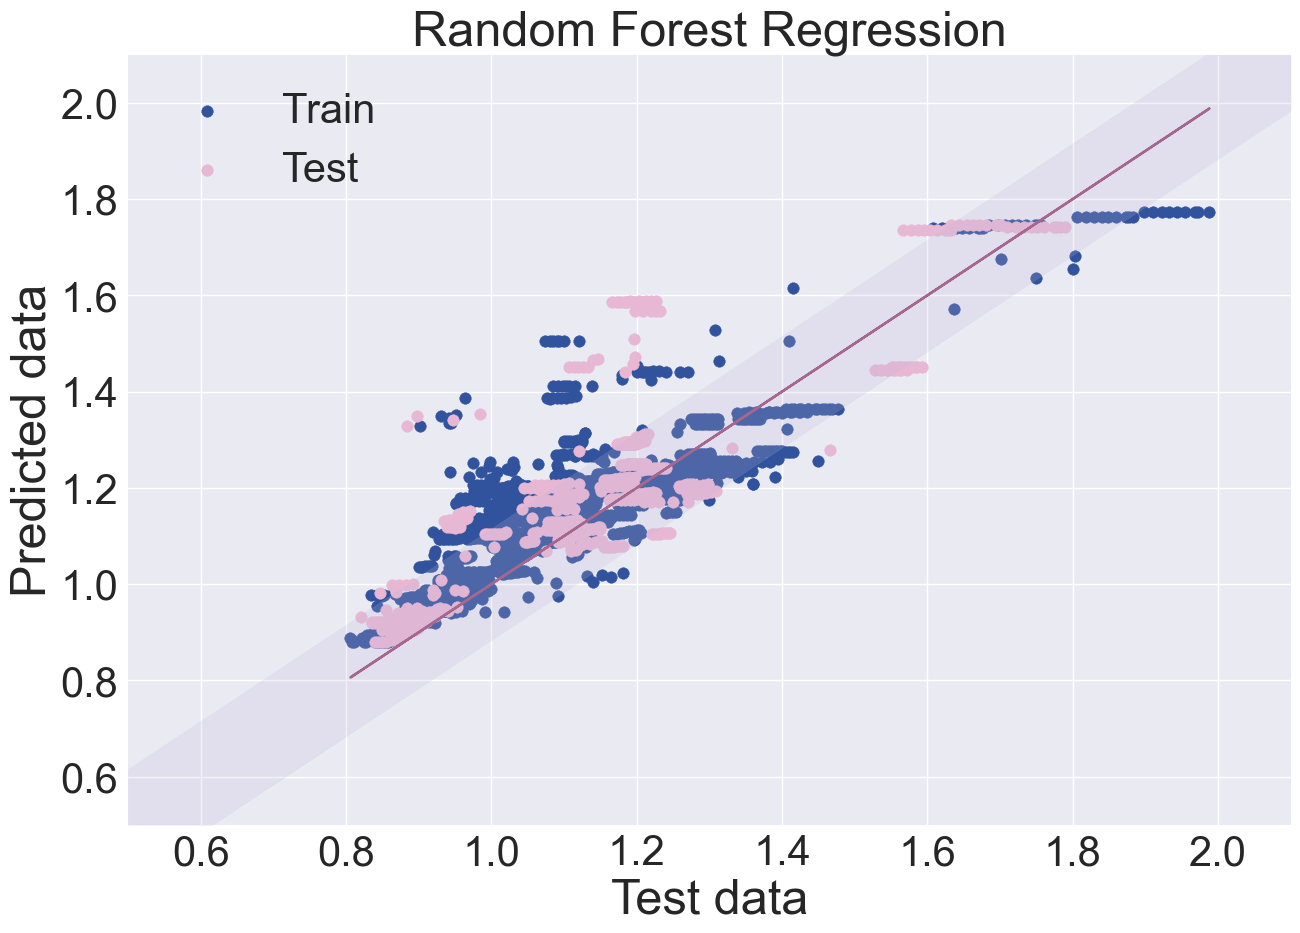

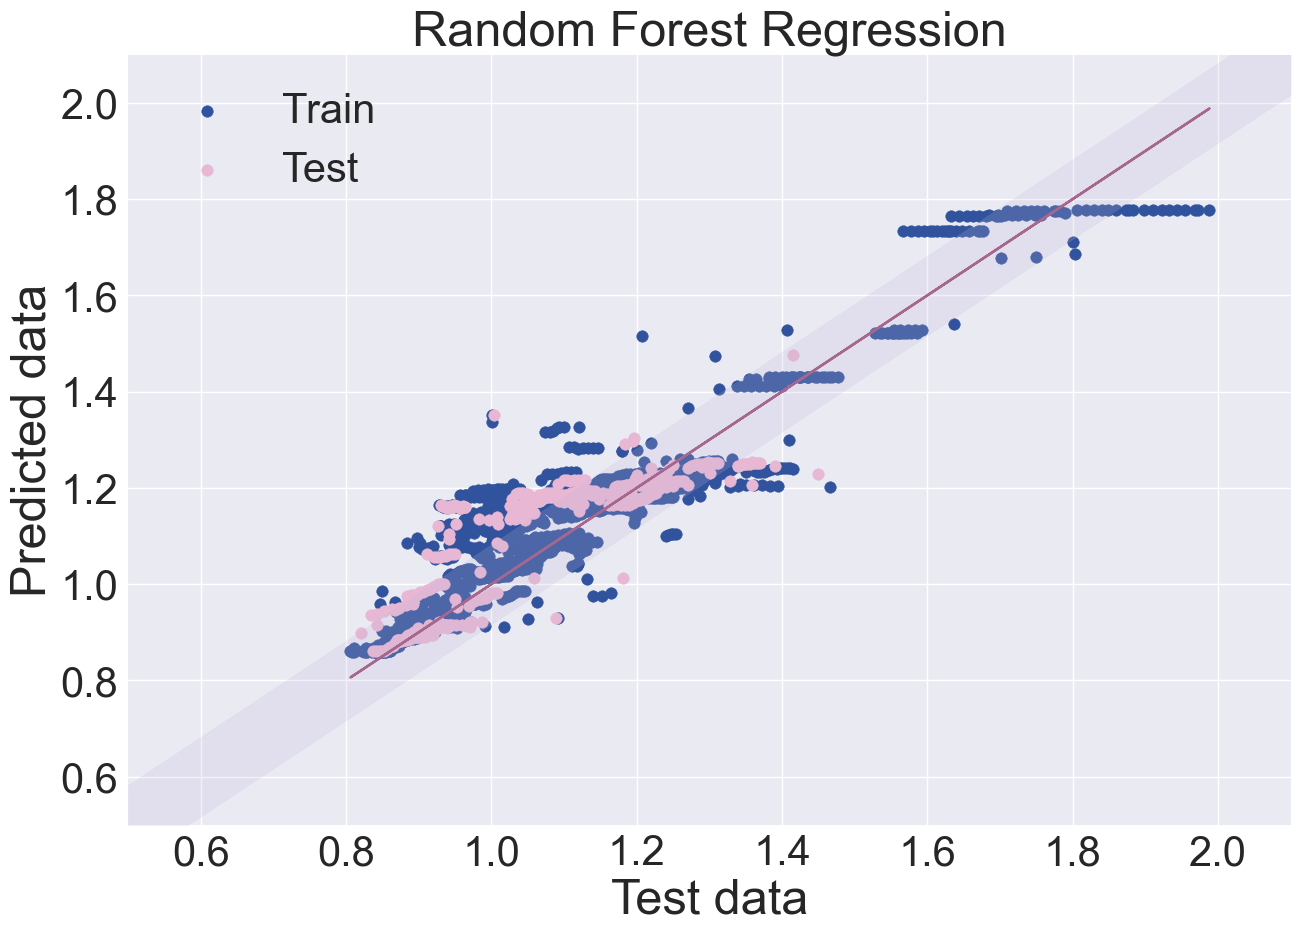

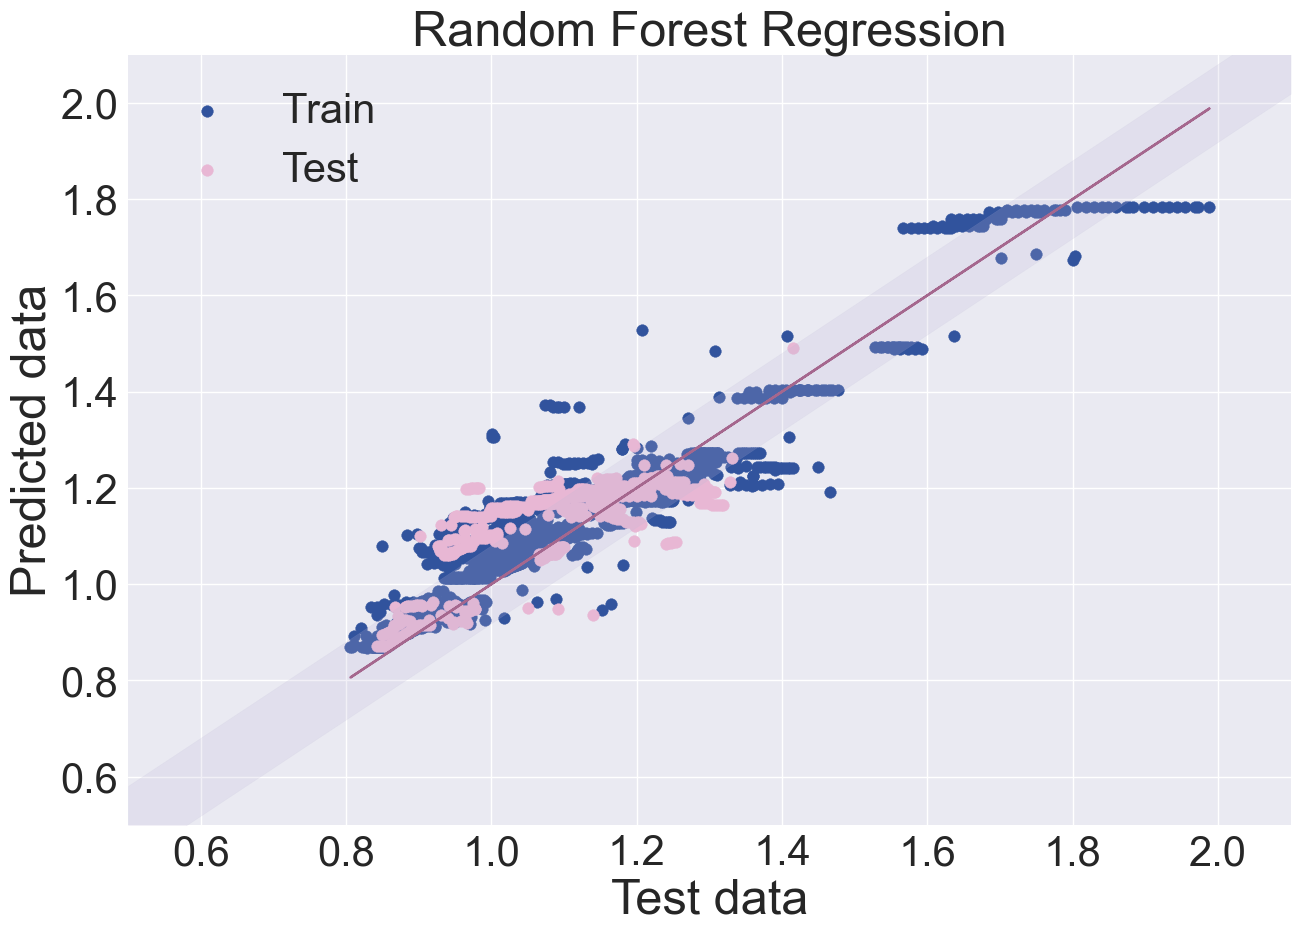

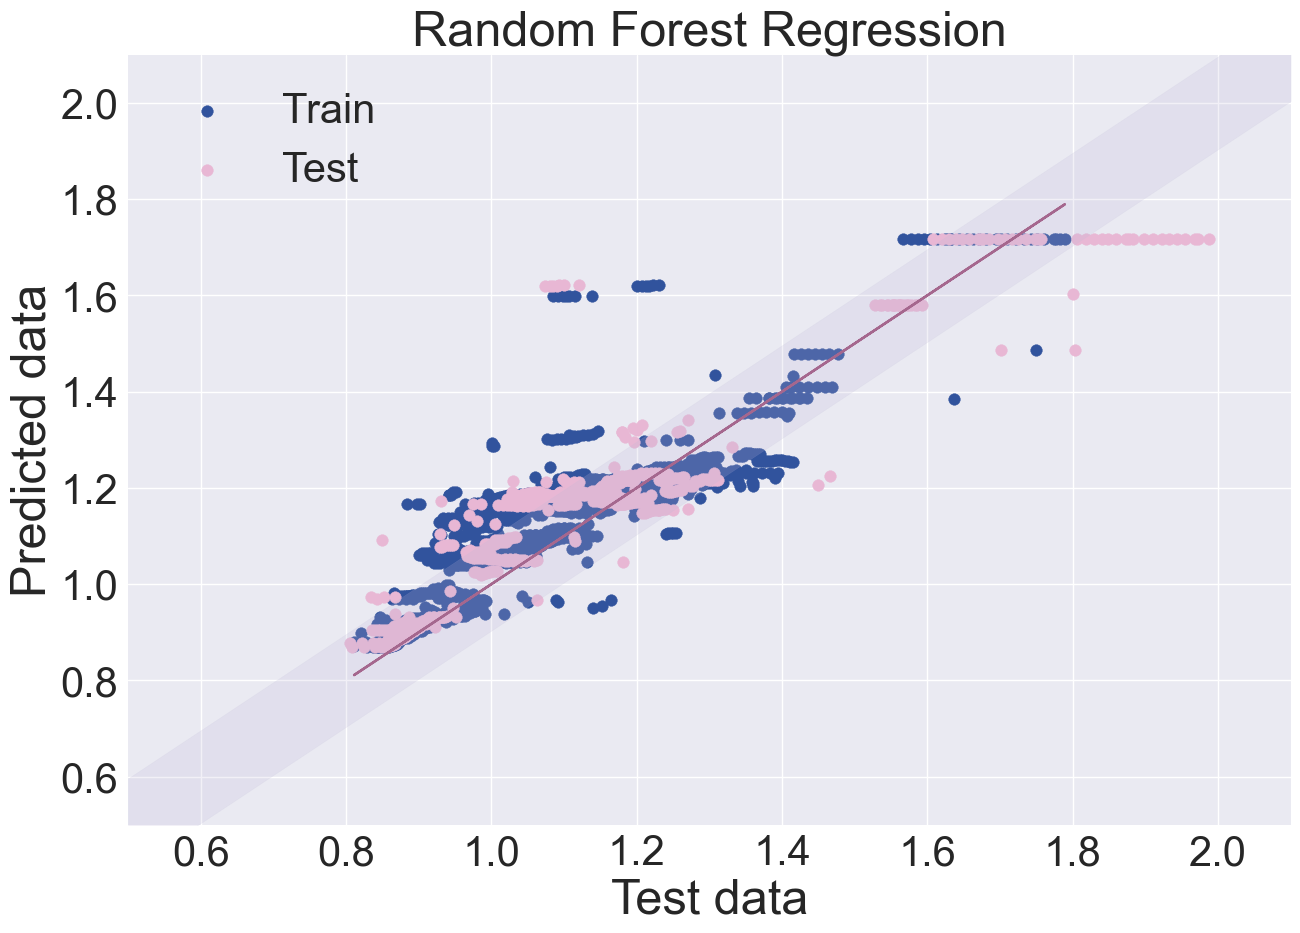

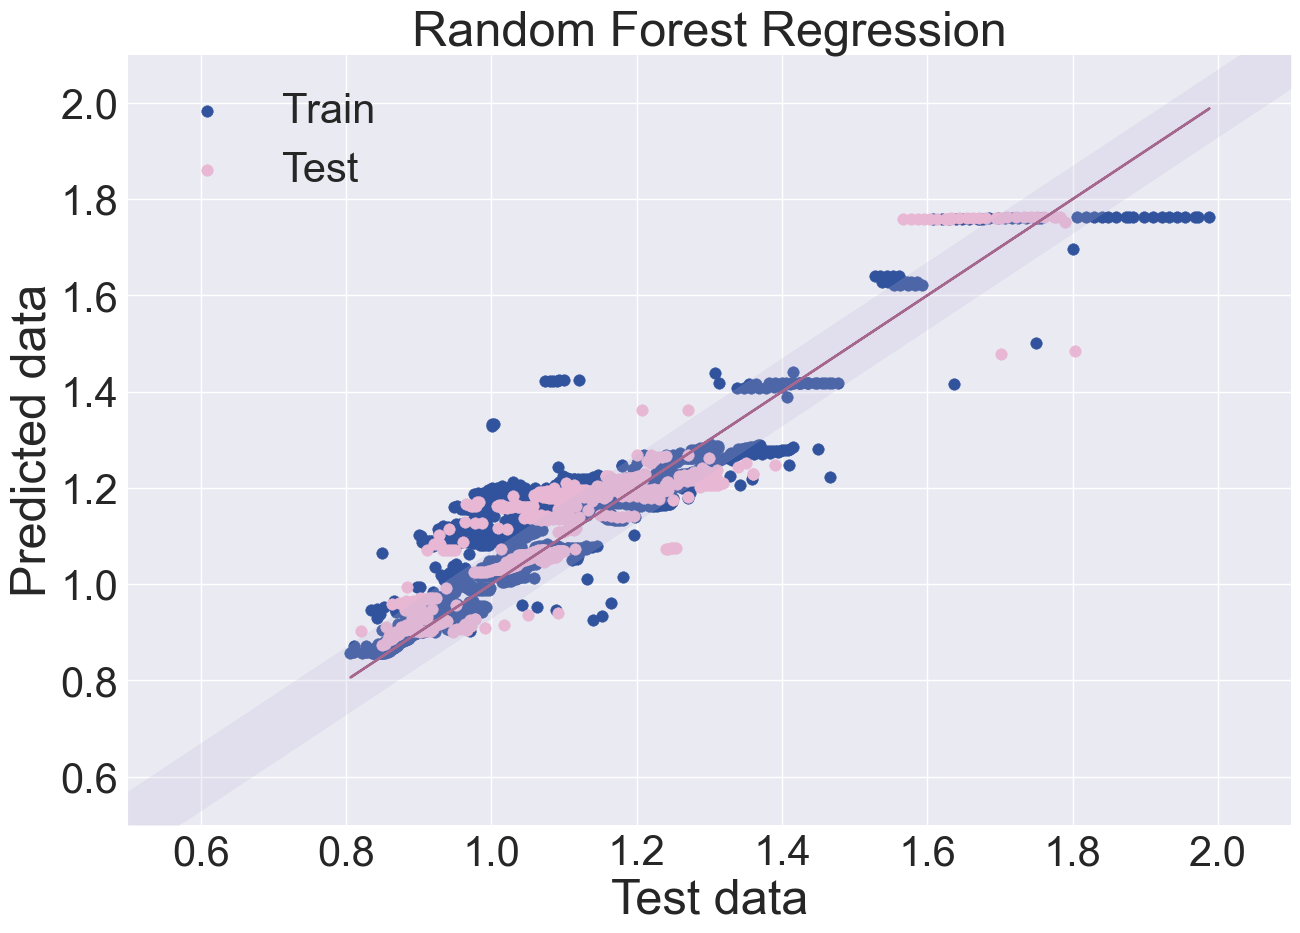

In [18]:
count = 0
#Creating a table to check accuracy on different DES classes
RFR_df = x_model[:]
RFR_df['Density_lit'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #Random Forest Regression
    regr_RFR = RandomForestRegressor(n_estimators=n_esti, max_depth=depth, min_samples_leaf=min_leaf, 
                                 min_samples_split=min_split, criterion=criterion, max_features=max_feat)
    regr_RFR.fit(x_train_mod, y_train_mod,sample_weight=sample_w)
    y_pred = regr_RFR.predict(x_test_mod)
    y1_pred = regr_RFR.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    RFR_df['Density_train' + str(count)] = None
    RFR_df['Density_test' + str(count)] = None
    RFR_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    RFR_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Random Forest Regression' + str(count)] = regr_metrics(regr_RFR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Random Forest Regression', fontsize=35)
df_error_train

In [19]:
df_error_RFR = metrics_class(RFR_df, 'Random Forest Regression')
df_error_RFR

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  \
0   Random Forest Regression0         2     I  0.693978        NaN   
1   Random Forest Regression0         2   III  0.328284   0.162642   
2   Random Forest Regression0         2    IV  0.242825   0.772004   
3   Random Forest Regression0         2     V  0.791913    0.78682   
4   Random Forest Regression0         3  None  0.584411  -0.056121   
5   Random Forest Regression1         2     I -2.336788        NaN   
6   Random Forest Regression1         2   III  0.462192   0.087199   
7   Random Forest Regression1         2    IV  0.877100  -5.245993   
8   Random Forest Regression1         2     V  0.772058   0.836963   
9   Random Forest Regression1         3  None  0.892422  -0.008307   
10  Random Forest Regression2         2     I -1.757305       None   
11  Random Forest Regression2         2   III  0.545055   0.320621   
12  Random Forest Regression2         2    IV  0.785664       None   
13  Random Forest Regression2         2     V  0.852527   0.262798   
14  Random Forest Regression2         3  None  0.869855   0.442694   
15  Random Forest Regression3         2     I -1.778971        NaN   
16  Random Forest Regression3         2   III  0.405468  -0.275109   
17  Random Forest Regression3         2    IV  0.816490   0.765265   
18  Random Forest Regression3         2     V  0.820013   0.785981   
19  Random Forest Regression3         3  None  0.431516   0.708417   
20  Random Forest Regression4         2     I -2.525246  -0.395202   
21  Random Forest Regression4         2   III  0.408109   0.446545   
22  Random Forest Regression4         2    IV  0.866953 -17.007091   
23  Random Forest Regression4         2     V  0.800392   0.608417   
24  Random Forest Regression4         3  None  0.869799   0.856042   

    RMSE_train RMSE_test  
0     0.035808  0.074121  
1     0.075747  0.079068  
2     0.055363  0.087059  
3     0.064914  0.052385  
4     0.204034  0.218896  
5     0.118240  0.348067  
6     0.066852  0.093529  
7     0.049182  0.080929  
8     0.066505  0.054718  
9     0.089122  0.124953  
10    0.121130      None  
11    0.060621  0.078964  
12    0.058905      None  
13    0.054439   0.10113  
14    0.110321  0.051297  
15    0.117561   0.07181  
16    0.073090  0.086896  
17    0.040453  0.037289  
18    0.059373  0.060414  
19    0.196440  0.148435  
20    0.135989  0.070871  
21    0.072192  0.064607  
22    0.045802   0.11033  
23    0.062896   0.07706  
24    0.094305  0.098125

**Output:** Decision trees work better than linear regression, but also with low accuracy


## 4. Boosting
Boosting is a procedure for sequentially constructing the composition of machine learning algorithms, when each subsequent algorithm seeks to compensate for the shortcomings of the composition of all previous algorithms.

### 4.1. Gradient Boosting Regression
Gradient Boosting builds a prediction in the form of an ensemble of weak predictive models, which are mainly decision trees. Out of several weak models, one is eventually assembled, but already effective. The general idea of the algorithm is the consistent application of a predictor (predictor) in such a way that each subsequent model reduces the error of the previous one to a minimum.

In [20]:
#We optimize for GBR
regr_GBR = GradientBoostingRegressor()

search_space = {"learning_rate": Real(0.05, 0.15),
    "n_estimators": Integer(50, 400),
    "max_depth": Integer(1, 6),
    "min_samples_leaf": Real(0.05, 0.5),
    "min_samples_split": Real(0.02, 0.6)}

#Scaling the data 
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)

sample_w = compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))

opt_GBR = BayesSearchCV(estimator = regr_GBR, search_spaces=search_space, cv=custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_GBR.fit(x_train01, y_model, sample_weight=sample_w)

learning_rate = opt_GBR.best_estimator_.learning_rate
n_estimators = opt_GBR.best_estimator_.n_estimators
max_depth = opt_GBR.best_estimator_.max_depth
min_samples_leaf = opt_GBR.best_estimator_.min_samples_leaf
min_samples_split = opt_GBR.best_estimator_.min_samples_split

print('learning_rate:', learning_rate,'n_estimators:', n_estimators, 'max_depth:', max_depth, 'min_samples_leaf:', min_samples_leaf,'min_samples_split:', min_samples_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



r2_test: 0.747696932488647
MAE_test: 0.07431644522396566
MSE_test: 0.009220315423368505
RMSE_test: 0.09602247353285846
r2_train: 0.9626452338743463
MAE_train: 0.019173490569558846
MSE_train: 0.0008671415476773375
RMSE_train: 0.02944726723615177



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8115988883723478
MAE_test: 0.04628546463192764
MSE_test: 0.0035649243115871954
RMSE_test: 0.05970698712535406
r2_train: 0.9772607975107263
MAE_train: 0.01607207734747455
MSE_train: 0.0006162550681765048
RMSE_train: 0.02482448525501596



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.6503235152272809
MAE_test: 0.03921017043406546
MSE_test: 0.004599947236699211
RMSE_test: 0.06782291085392318
r2_train: 0.9796896492689329
MAE_train: 0.01562500717990337
MSE_train: 0.0005903667865924139
RMSE_train: 0.02429746461243259



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8191541008427674
MAE_test: 0.05592790504780406
MSE_test: 0.00844862575305776
RMSE_test: 0.09191640633237225
r2_train: 0.9580739482569193
MAE_train: 0.01667445374505226
MSE_train: 0.0008415527008628471
RMSE_train: 0.029009527760079912
r2_test: 0.8552858104359079
MAE_test: 0.04105541872211046
MSE_test: 0.003554409352513193
RMSE_test: 0.05961886742058417
r2_train: 0.9733362879847407
MAE_train: 0.01730222069607159
MSE_train: 0.0007043473150043363
RMSE_train: 0.026539542479182575



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  \
0                   0.784980                   0.799245   
1                   0.762418                   0.802704   
2                   0.065696                   0.072823   
3                   0.105353                   0.069613   

   Random Forest Regression0  Random Forest Regression1  \
0                   0.696732                   0.824129   
1                   0.631127                   0.636773   
2                   0.083904                   0.069038   
3                   0.116105                   0.082903   

   Random Forest Regression2  Random Forest Regression3  \
0                   0.858040                   0.686172   
1                   0.501752                   0.800781   
2                   0.064237                   0.079368   
3                   0.080959                   0.096473   

   Random Forest Regression4  Gradient Boosting Regression0  \
0                   0.805773                       0.962645   
1                   0.801822                       0.747697   
2                   0.071629                       0.029447   
3                   0.069768                       0.096022   

   Gradient Boosting Regression1  Gradient Boosting Regression2  \
0                       0.977261                       0.979690   
1                       0.811599                       0.650324   
2                       0.024824                       0.024297   
3                       0.059707                       0.067823   

   Gradient Boosting Regression3  Gradient Boosting Regression4  
0                       0.958074                       0.973336  
1                       0.819154                       0.855286  
2                       0.029010                       0.026540  
3                       0.091916                       0.059619

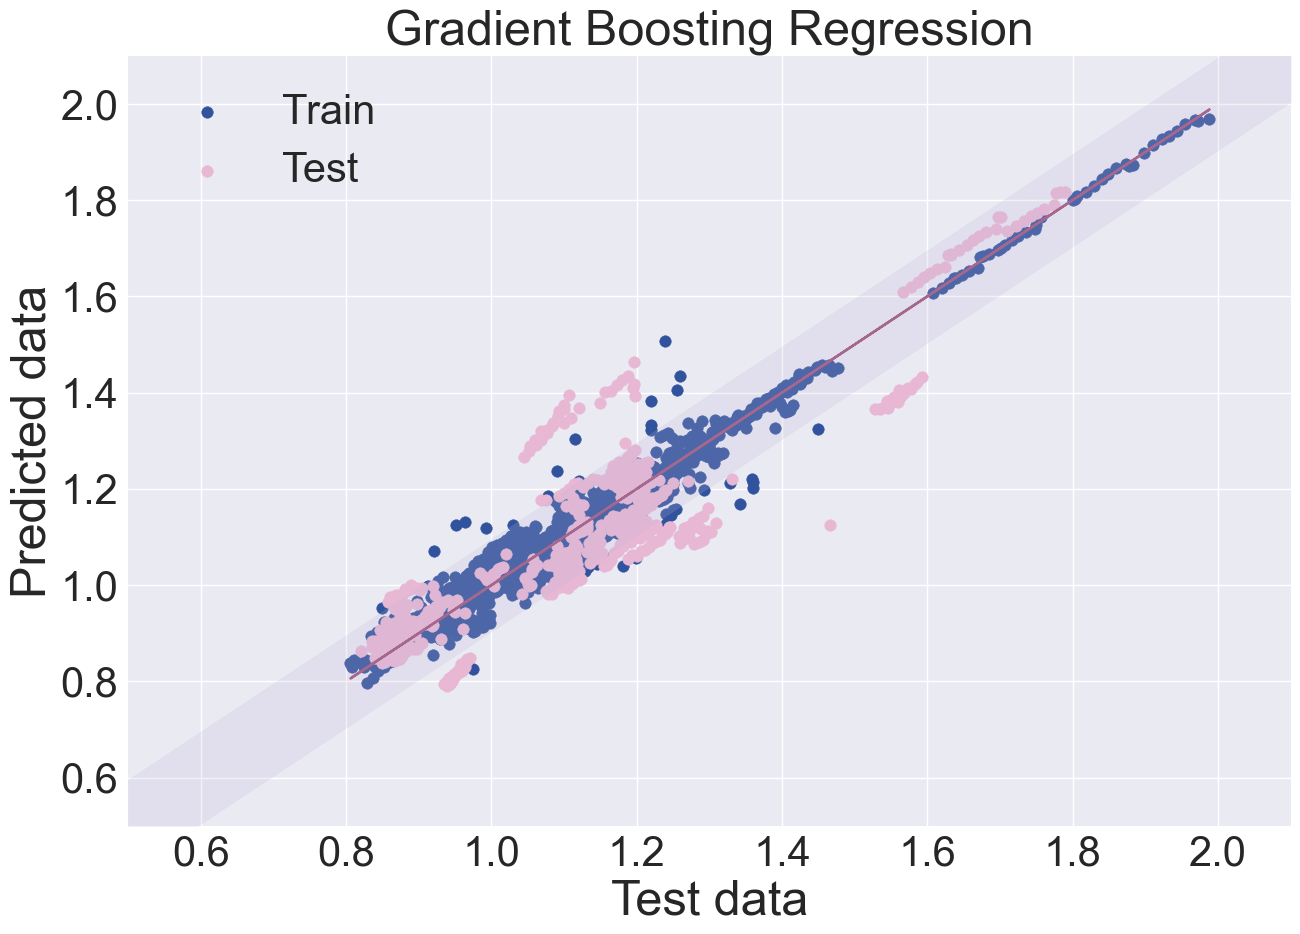

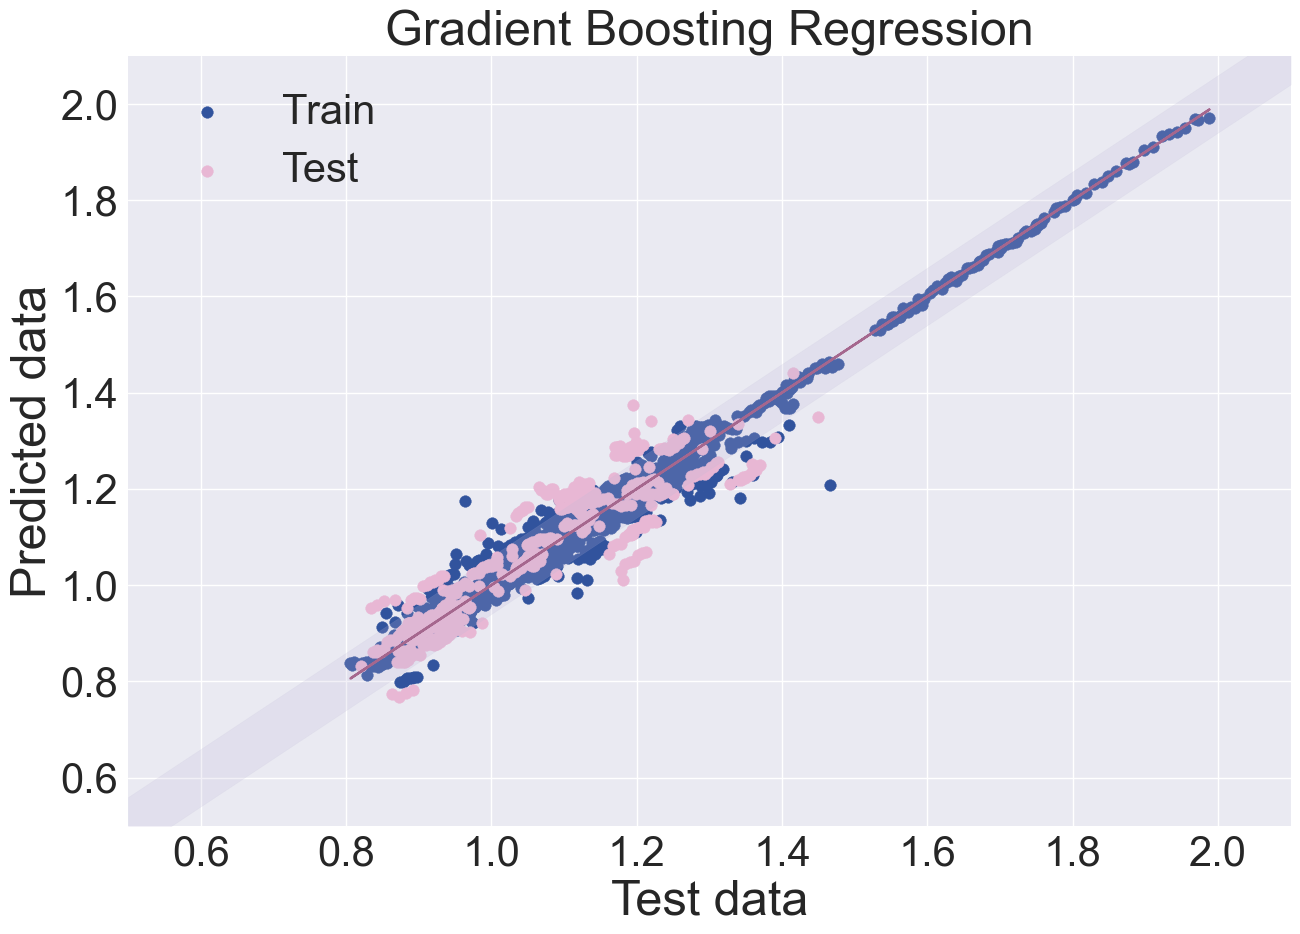

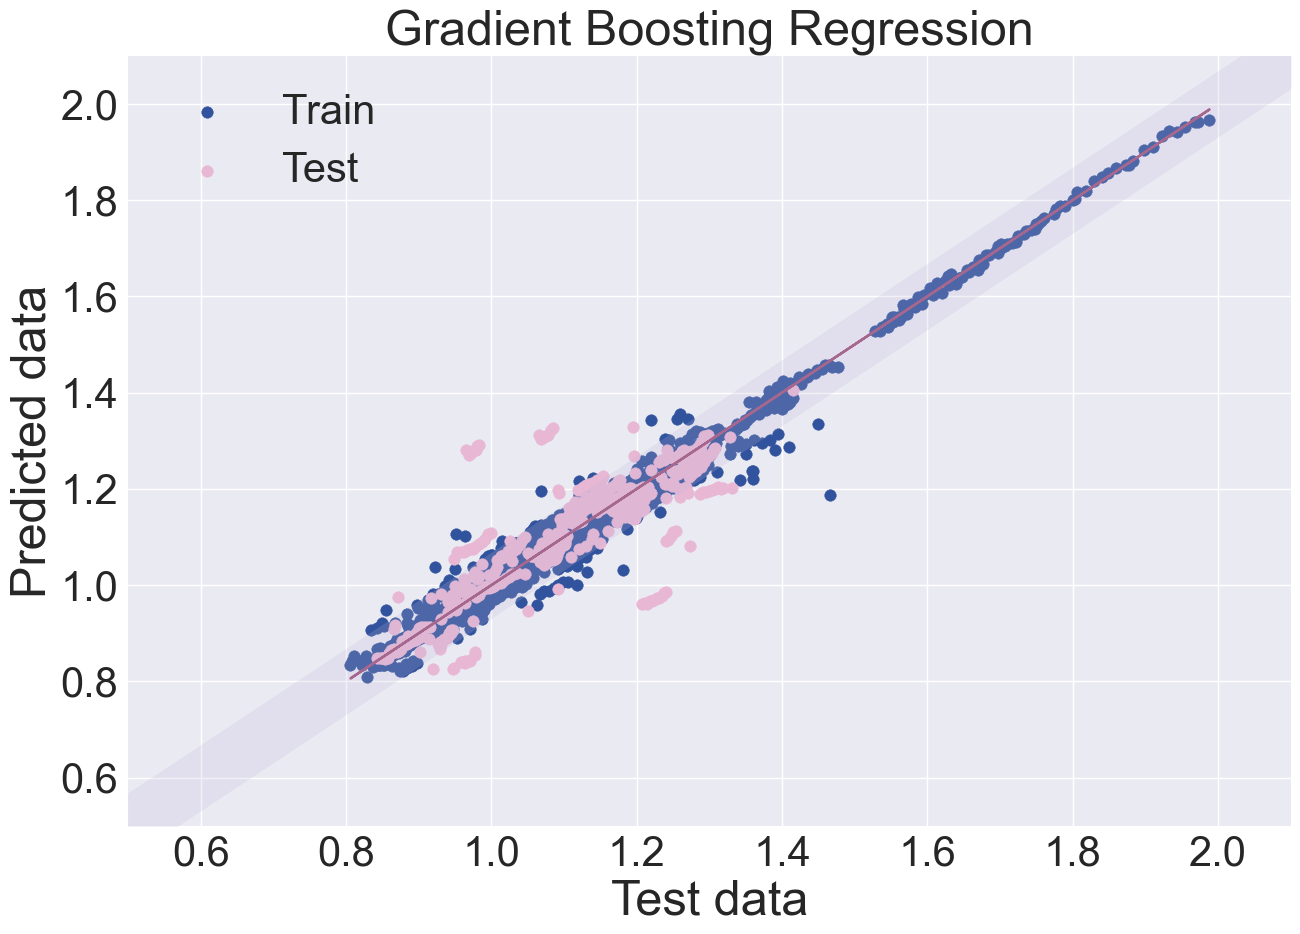

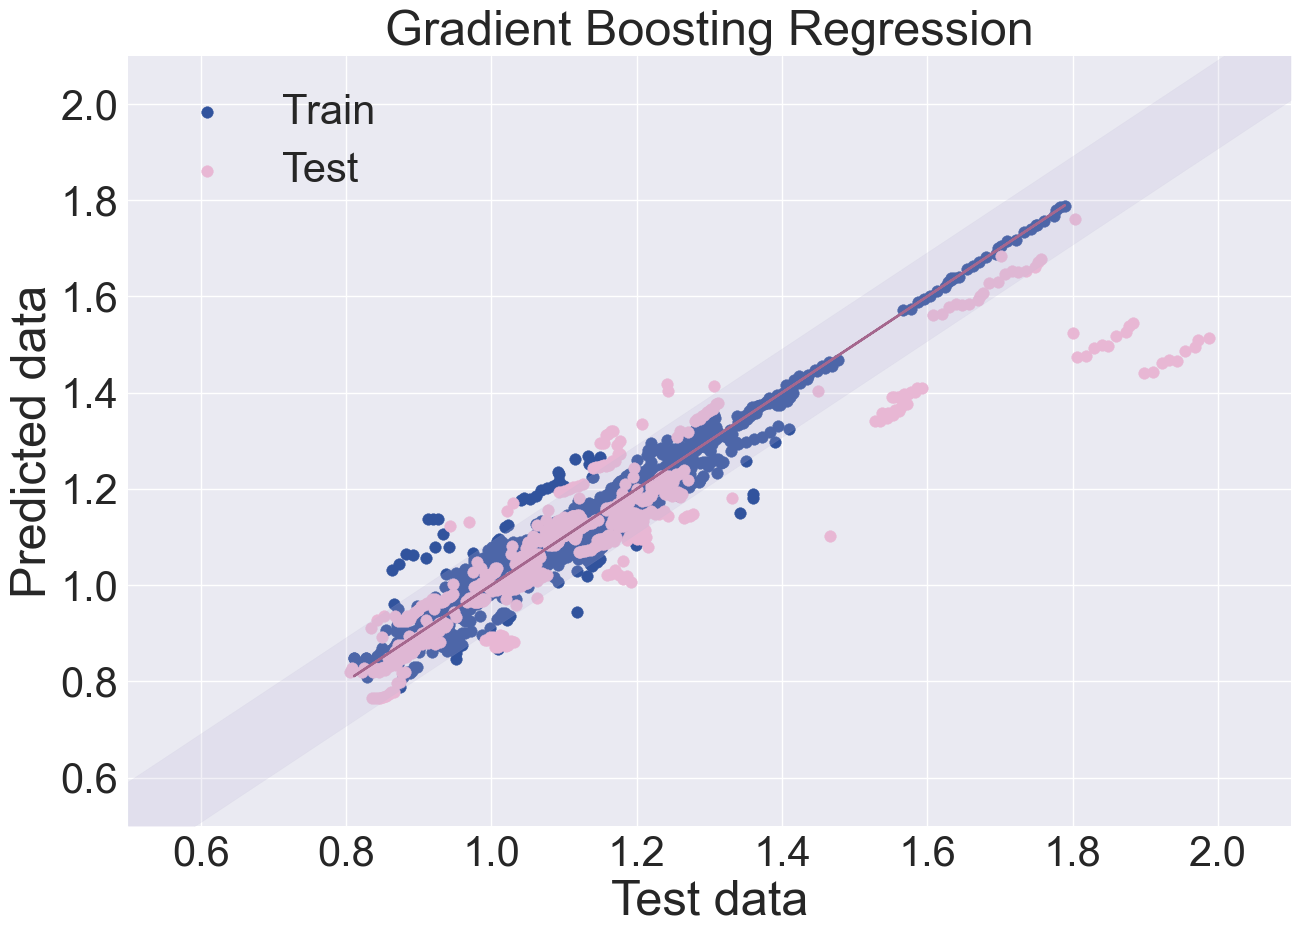

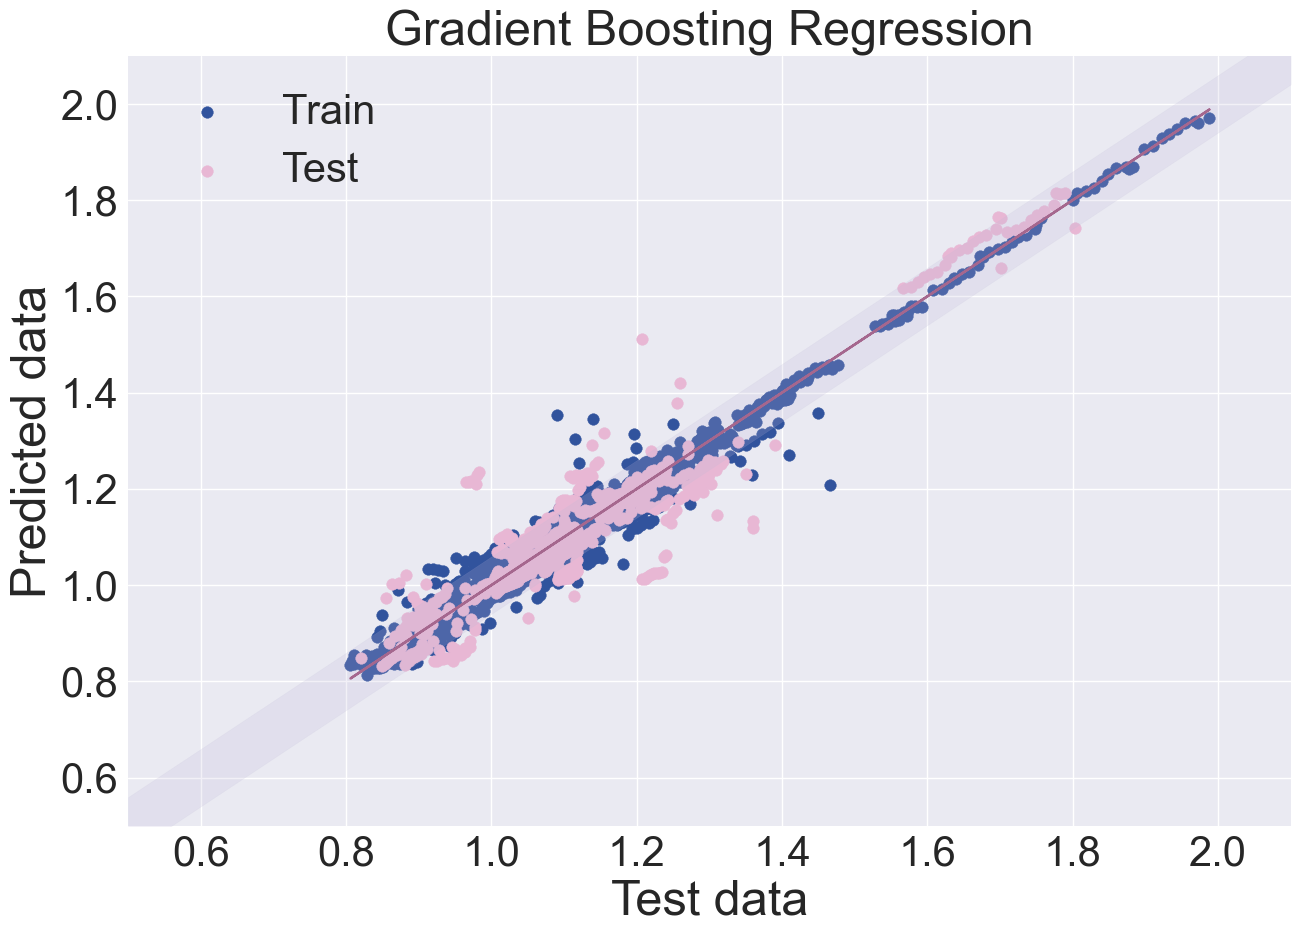

In [21]:
count = 0
#Creating a table to check accuracy on different DES classes
GBR_df = x_model[:]
GBR_df['Density_lit'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #GBR
    regr_GBR = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators, max_depth= max_depth, min_samples_leaf= min_samples_leaf, min_samples_split= min_samples_split)
    regr_GBR.fit(x_train_mod, y_train_mod, sample_weight=sample_w)
    y_pred = regr_GBR.predict(x_test_mod)
    y1_pred = regr_GBR.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    GBR_df['Density_train' + str(count)] = None
    GBR_df['Density_test' + str(count)] = None
    GBR_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    GBR_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Gradient Boosting Regression' + str(count)] = regr_metrics(regr_GBR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Gradient Boosting Regression', fontsize=35)
df_error_train

In [22]:
df_error_GBR = metrics_class(GBR_df, 'Gradient Boosting Regression')
df_error_GBR

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  \
0   Gradient Boosting Regression0         2     I  0.997296        NaN   
1   Gradient Boosting Regression0         2   III  0.871419  -0.991319   
2   Gradient Boosting Regression0         2    IV  0.986123   0.551507   
3   Gradient Boosting Regression0         2     V  0.979067   0.804625   
4   Gradient Boosting Regression0         3  None  0.995636   0.932258   
5   Gradient Boosting Regression1         2     I  0.994476        NaN   
6   Gradient Boosting Regression1         2   III  0.911716   0.672651   
7   Gradient Boosting Regression1         2    IV  0.997377  -7.758751   
8   Gradient Boosting Regression1         2     V  0.978953     0.8409   
9   Gradient Boosting Regression1         3  None  0.992961   0.296437   
10  Gradient Boosting Regression2         2     I  0.996287       None   
11  Gradient Boosting Regression2         2   III  0.905771   0.832674   
12  Gradient Boosting Regression2         2    IV  0.993478       None   
13  Gradient Boosting Regression2         2     V  0.984592   0.160713   
14  Gradient Boosting Regression2         3  None  0.995145  -1.074022   
15  Gradient Boosting Regression3         2     I  0.994071        NaN   
16  Gradient Boosting Regression3         2   III  0.876889   0.574256   
17  Gradient Boosting Regression3         2    IV  0.996140  -4.491092   
18  Gradient Boosting Regression3         2     V  0.983326   0.796841   
19  Gradient Boosting Regression3         3  None  0.993106   0.655799   
20  Gradient Boosting Regression4         2     I  0.990996   0.979332   
21  Gradient Boosting Regression4         2   III  0.902342   0.688894   
22  Gradient Boosting Regression4         2    IV  0.995143 -86.550245   
23  Gradient Boosting Regression4         2     V  0.975579   0.614763   
24  Gradient Boosting Regression4         3  None  0.990027    0.85935   

    RMSE_train RMSE_test  
0     0.003366  0.006289  
1     0.033140  0.121932  
2     0.007495  0.122103  
3     0.020589   0.05015  
4     0.020907  0.055438  
5     0.004811  0.007292  
6     0.027086   0.05601  
7     0.007185  0.095835  
8     0.020208  0.054053  
9     0.022797  0.104376  
10    0.004445      None  
11    0.027589  0.039188  
12    0.010275      None  
13    0.017597  0.107905  
14    0.021307  0.098958  
15    0.005430  0.047857  
16    0.033260  0.050211  
17    0.005867  0.180351  
18    0.018071  0.058861  
19    0.021632  0.161273  
20    0.006873  0.008626  
21    0.029324  0.048438  
22    0.008752  0.243278  
23    0.022000  0.076433  
24    0.026100  0.096991

### 4.2. Cat Boosting Regression
CatBoost is a gradient boosting library. She uses oblivious decision trees to grow a balanced tree. The same functions are used to create left and right splits at each level of the tree.

In [23]:
#We optimize for CBR
regr_CBR = CatBoostRegressor()

search_space = {"iterations": Integer(100, 600), 
                "learning_rate": Real(0.05, 0.4),
                "depth": Integer(1, 6)}

#Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight = compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))

opt_CBR = BayesSearchCV(estimator = regr_CBR, search_spaces=search_space, cv=custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_CBR.fit(x_train01, y_model, sample_weight=sample_weight)

iterations = opt_CBR.best_params_['iterations']
learning_rate = opt_CBR.best_params_['learning_rate']
depth = opt_CBR.best_params_['depth']


print('iterations:', iterations,'learning_rate:', learning_rate, 'depth:', depth)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.2430173	total: 139ms	remaining: 1m 23s
1:	learn: 0.2154535	total: 140ms	remaining: 41.9s
2:	learn: 0.1913096	total: 141ms	remaining: 28.1s
3:	learn: 0.1726011	tot

0:	learn: 0.2700694	total: 1.12ms	remaining: 673ms
1:	learn: 0.2390158	total: 2.22ms	remaining: 664ms
2:	learn: 0.2113978	total: 3.1ms	remaining: 617ms
3:	learn: 0.1876035	total: 3.76ms	remaining: 560ms
4:	learn: 0.1746329	total: 4.67ms	remaining: 556ms
5:	learn: 0.1592963	total: 5.66ms	remaining: 561ms
6:	learn: 0.1426513	total: 6.57ms	remaining: 557ms
7:	learn: 0.1326847	total: 7.44ms	remaining: 550ms
8:	learn: 0.1224748	total: 8.29ms	remaining: 544ms
9:	learn: 0.1103512	total: 9.21ms	remaining: 544ms
10:	learn: 0.0998749	total: 10.2ms	remaining: 546ms
11:	learn: 0.0933599	total: 11.1ms	remaining: 543ms
12:	learn: 0.0865944	total: 11.9ms	remaining: 536ms
13:	learn: 0.0795187	total: 12.7ms	remaining: 533ms
14:	learn: 0.0755459	total: 13.6ms	remaining: 532ms
15:	learn: 0.0696237	total: 14.5ms	remaining: 528ms
16:	learn: 0.0648585	total: 15.5ms	remaining: 533ms
17:	learn: 0.0610482	total: 16.4ms	remaining: 532ms
18:	learn: 0.0571514	total: 17.3ms	remaining: 529ms
19:	learn: 0.0537221	to


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


37:	learn: 0.0329781	total: 35.2ms	remaining: 521ms
38:	learn: 0.0322852	total: 36.4ms	remaining: 524ms
39:	learn: 0.0315264	total: 37.5ms	remaining: 524ms
40:	learn: 0.0306722	total: 38.5ms	remaining: 525ms
41:	learn: 0.0298133	total: 39.5ms	remaining: 525ms
42:	learn: 0.0291330	total: 40.4ms	remaining: 524ms
43:	learn: 0.0285905	total: 41.6ms	remaining: 526ms
44:	learn: 0.0279557	total: 42.7ms	remaining: 527ms
45:	learn: 0.0276627	total: 43.7ms	remaining: 526ms
46:	learn: 0.0269630	total: 44.7ms	remaining: 525ms
47:	learn: 0.0265728	total: 45.7ms	remaining: 525ms
48:	learn: 0.0262667	total: 46.7ms	remaining: 525ms
49:	learn: 0.0258730	total: 47.9ms	remaining: 527ms
50:	learn: 0.0254730	total: 49ms	remaining: 527ms
51:	learn: 0.0251285	total: 50ms	remaining: 527ms
52:	learn: 0.0246349	total: 51.2ms	remaining: 529ms
53:	learn: 0.0243259	total: 52.2ms	remaining: 528ms
54:	learn: 0.0240152	total: 53.3ms	remaining: 528ms
55:	learn: 0.0235849	total: 54.3ms	remaining: 528ms
56:	learn: 0.023


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


108:	learn: 0.0133304	total: 119ms	remaining: 538ms
109:	learn: 0.0132237	total: 121ms	remaining: 537ms
110:	learn: 0.0132106	total: 122ms	remaining: 537ms
111:	learn: 0.0132039	total: 123ms	remaining: 535ms
112:	learn: 0.0131214	total: 124ms	remaining: 534ms
113:	learn: 0.0131151	total: 125ms	remaining: 533ms
114:	learn: 0.0131090	total: 126ms	remaining: 531ms
115:	learn: 0.0129514	total: 127ms	remaining: 530ms
116:	learn: 0.0127955	total: 128ms	remaining: 529ms
117:	learn: 0.0126014	total: 129ms	remaining: 528ms
118:	learn: 0.0125250	total: 130ms	remaining: 527ms
119:	learn: 0.0125138	total: 131ms	remaining: 526ms
120:	learn: 0.0123888	total: 132ms	remaining: 524ms
121:	learn: 0.0123840	total: 134ms	remaining: 523ms
122:	learn: 0.0123793	total: 135ms	remaining: 522ms
123:	learn: 0.0123619	total: 136ms	remaining: 522ms
124:	learn: 0.0123571	total: 137ms	remaining: 520ms
125:	learn: 0.0122468	total: 138ms	remaining: 519ms
126:	learn: 0.0120955	total: 139ms	remaining: 518ms
127:	learn: 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.930435755543281
MAE_test: 0.029854451251728545
MSE_test: 0.001316294071401615
RMSE_test: 0.03628076723832636
r2_train: 0.9902551143321079
MAE_train: 0.00987973605292141
MSE_train: 0.00026409612142166684
RMSE_train: 0.016251034472354885
0:	learn: 0.2530272	total: 1.18ms	remaining: 707ms
1:	learn: 0.2242217	total: 2.11ms	remaining: 632ms
2:	learn: 0.2001719	total: 3.05ms	remaining: 606ms
3:	learn: 0.1769976	total: 4.08ms	remaining: 607ms
4:	learn: 0.1577316	total: 5.22ms	remaining: 621ms
5:	learn: 0.1424804	total: 6.15ms	remaining: 609ms
6:	learn: 0.1295654	total: 6.99ms	remaining: 592ms
7:	learn: 0.1168944	total: 7.84ms	remaining: 580ms
8:	learn: 0.1065414	total: 8.7ms	remaining: 571ms
9:	learn: 0.0972766	total: 9.6ms	remaining: 567ms
10:	learn: 0.0883762	total: 10.7ms	remaining: 572ms
11:	learn: 0.0808942	total: 11.7ms	remaining: 572ms
12:	learn: 0.0748891	total: 12.5ms	remaining: 565ms
13:	learn: 0.0692021	total: 13.6ms	remaining: 571ms
14:	learn: 0.0655395	total: 14.5ms	re


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8111778433634903
MAE_test: 0.03638814121827526
MSE_test: 0.0024839301339129177
RMSE_test: 0.049839042265205274
r2_train: 0.9929780415918581
MAE_train: 0.00923139715847743
MSE_train: 0.0002041092778697914
RMSE_train: 0.014286681835534498
0:	learn: 0.2237616	total: 1.39ms	remaining: 831ms
1:	learn: 0.1987654	total: 2.56ms	remaining: 764ms
2:	learn: 0.1775155	total: 4ms	remaining: 795ms
3:	learn: 0.1599034	total: 5.07ms	remaining: 756ms
4:	learn: 0.1425842	total: 6.42ms	remaining: 764ms
5:	learn: 0.1309035	total: 7.65ms	remaining: 757ms
6:	learn: 0.1224696	total: 8.79ms	remaining: 744ms
7:	learn: 0.1111724	total: 10.1ms	remaining: 750ms
8:	learn: 0.1046472	total: 11.4ms	remaining: 746ms
9:	learn: 0.0949949	total: 12.6ms	remaining: 744ms
10:	learn: 0.0858876	total: 14ms	remaining: 747ms
11:	learn: 0.0793987	total: 15.4ms	remaining: 753ms
12:	learn: 0.0720602	total: 16.9ms	remaining: 765ms
13:	learn: 0.0658061	total: 18.4ms	remaining: 771ms
14:	learn: 0.0625155	total: 19.8ms	rema


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26:	learn: 0.0365651	total: 82.3ms	remaining: 1.75s
27:	learn: 0.0349078	total: 83.8ms	remaining: 1.71s
28:	learn: 0.0339915	total: 85.1ms	remaining: 1.68s
29:	learn: 0.0328888	total: 86.4ms	remaining: 1.64s
30:	learn: 0.0319681	total: 87.7ms	remaining: 1.61s
31:	learn: 0.0311544	total: 89.1ms	remaining: 1.58s
32:	learn: 0.0299987	total: 90.4ms	remaining: 1.55s
33:	learn: 0.0294101	total: 91.8ms	remaining: 1.53s
34:	learn: 0.0287545	total: 93.2ms	remaining: 1.5s
35:	learn: 0.0283658	total: 94.6ms	remaining: 1.48s
36:	learn: 0.0277732	total: 96.1ms	remaining: 1.46s
37:	learn: 0.0272902	total: 97.6ms	remaining: 1.44s
38:	learn: 0.0269387	total: 98.9ms	remaining: 1.42s
39:	learn: 0.0260959	total: 100ms	remaining: 1.4s
40:	learn: 0.0256960	total: 102ms	remaining: 1.39s
41:	learn: 0.0251151	total: 103ms	remaining: 1.37s
42:	learn: 0.0246529	total: 104ms	remaining: 1.35s
43:	learn: 0.0241391	total: 106ms	remaining: 1.34s
44:	learn: 0.0237088	total: 107ms	remaining: 1.32s
45:	learn: 0.0235064


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  ...  \
0                   0.784980                   0.799245  ...   
1                   0.762418                   0.802704  ...   
2                   0.065696                   0.072823  ...   
3                   0.105353                   0.069613  ...   

   Gradient Boosting Regression0  Gradient Boosting Regression1  \
0                       0.962645                       0.977261   
1                       0.747697                       0.811599   
2                       0.029447                       0.024824   
3                       0.096022                       0.059707   

   Gradient Boosting Regression2  Gradient Boosting Regression3  \
0                       0.979690                       0.958074   
1                       0.650324                       0.819154   
2                       0.024297                       0.029010   
3                       0.067823                       0.091916   

   Gradient Boosting Regression4  Cat Boosting Regression0  \
0                       0.973336                  0.988967   
1                       0.855286                  0.837480   
2                       0.026540                  0.016004   
3                       0.059619                  0.077066   

   Cat Boosting Regression1  Cat Boosting Regression2  \
0                  0.990255                  0.992978   
1                  0.930436                  0.811178   
2                  0.016251                  0.014287   
3                  0.036281                  0.049839   

   Cat Boosting Regression3  Cat Boosting Regression4  
0                  0.986980                  0.991665  
1                  0.894552                  0.886327  
2                  0.016166                  0.014838  
3                  0.070187                  0.052839  

[4 rows x 25 columns]

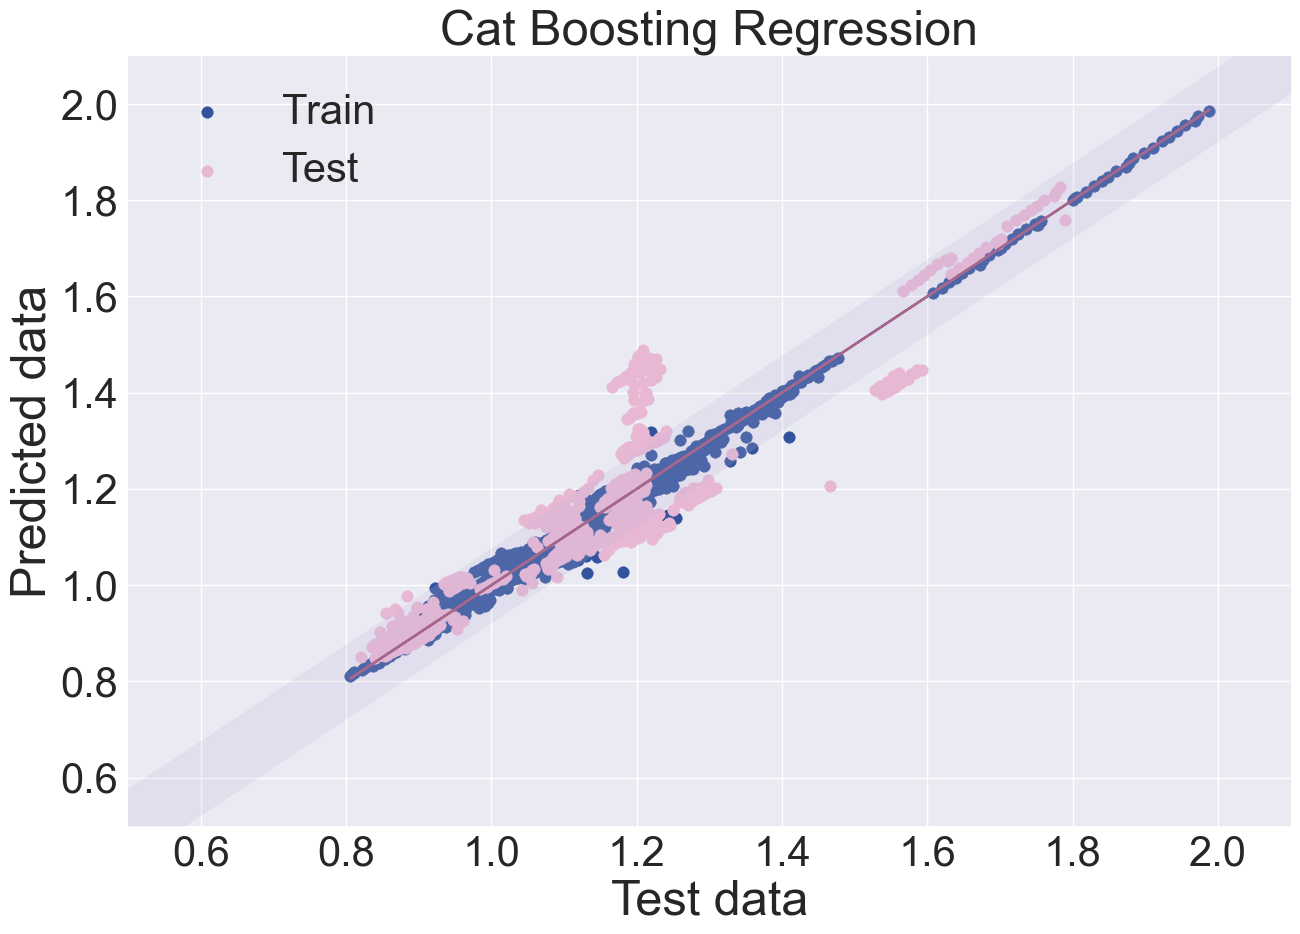

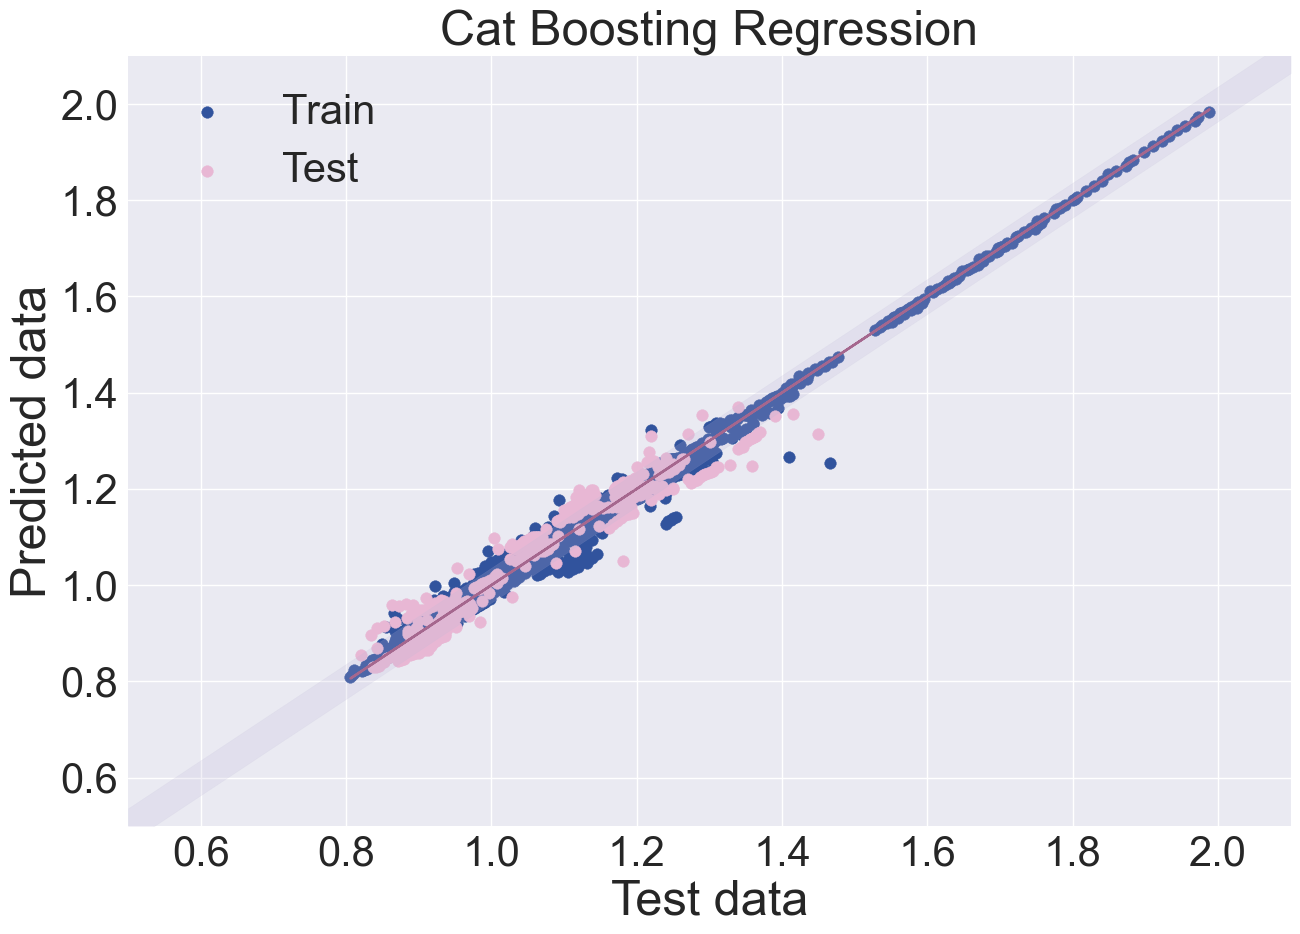

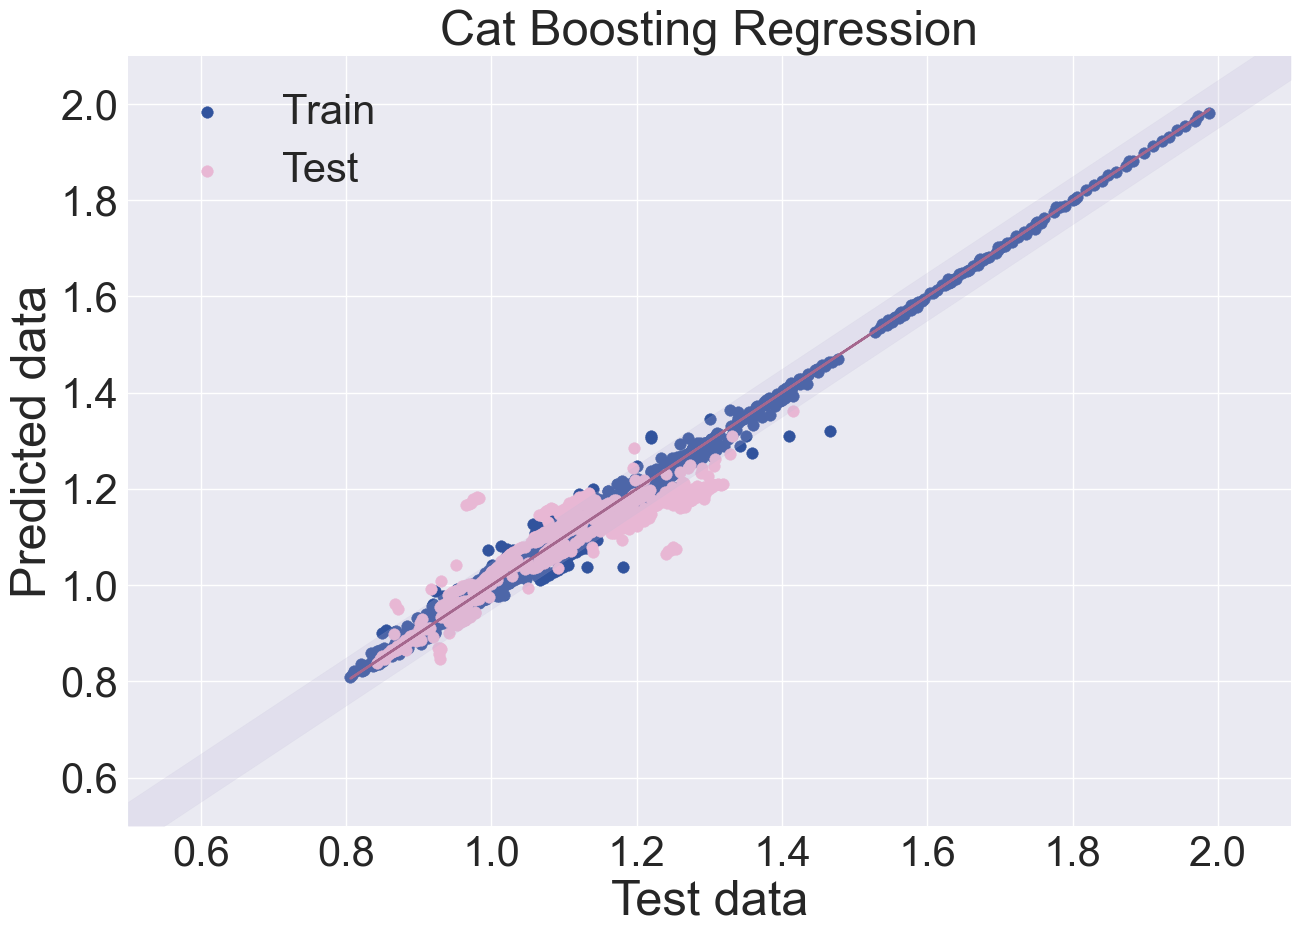

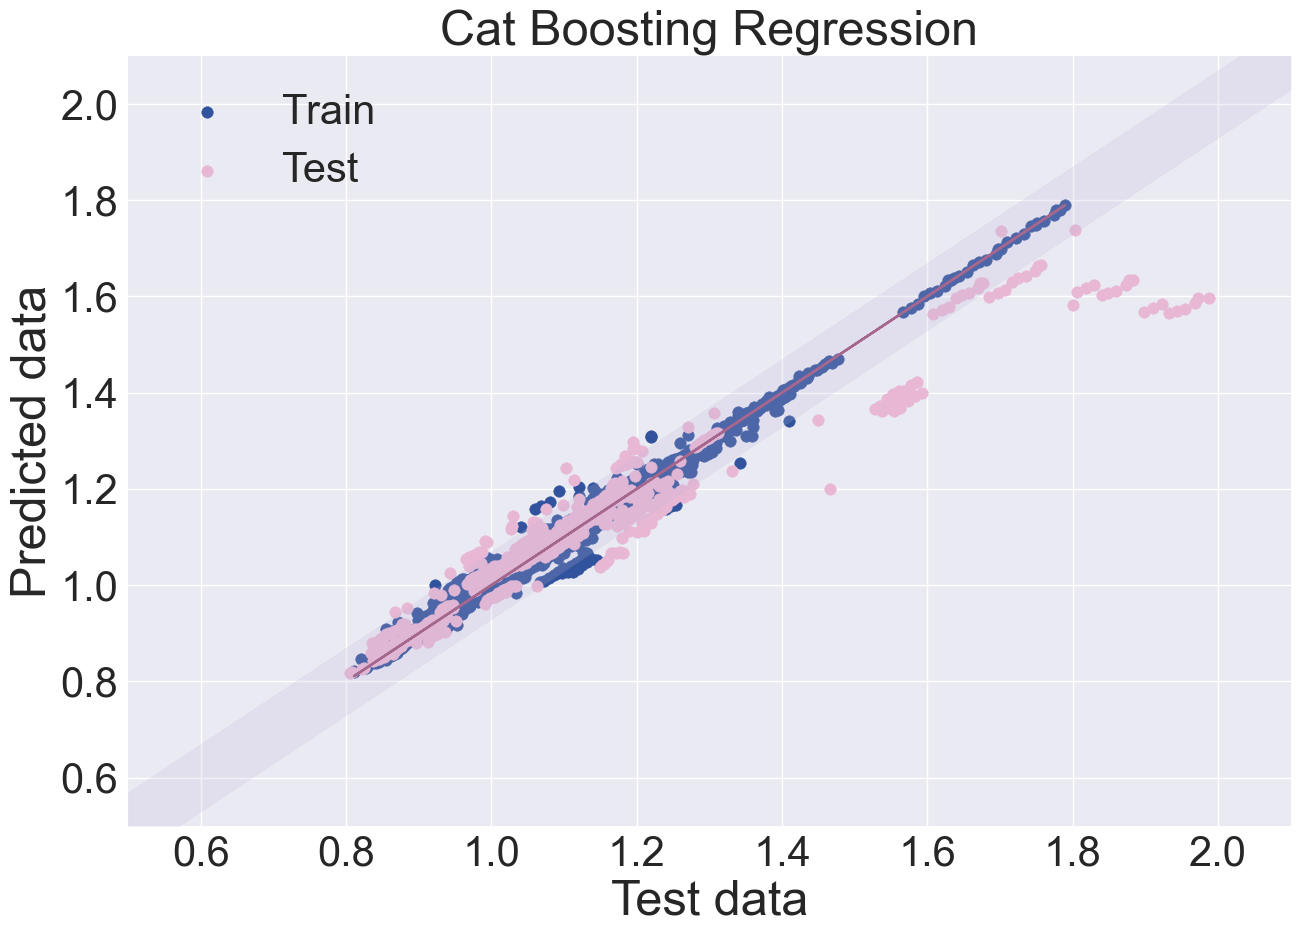

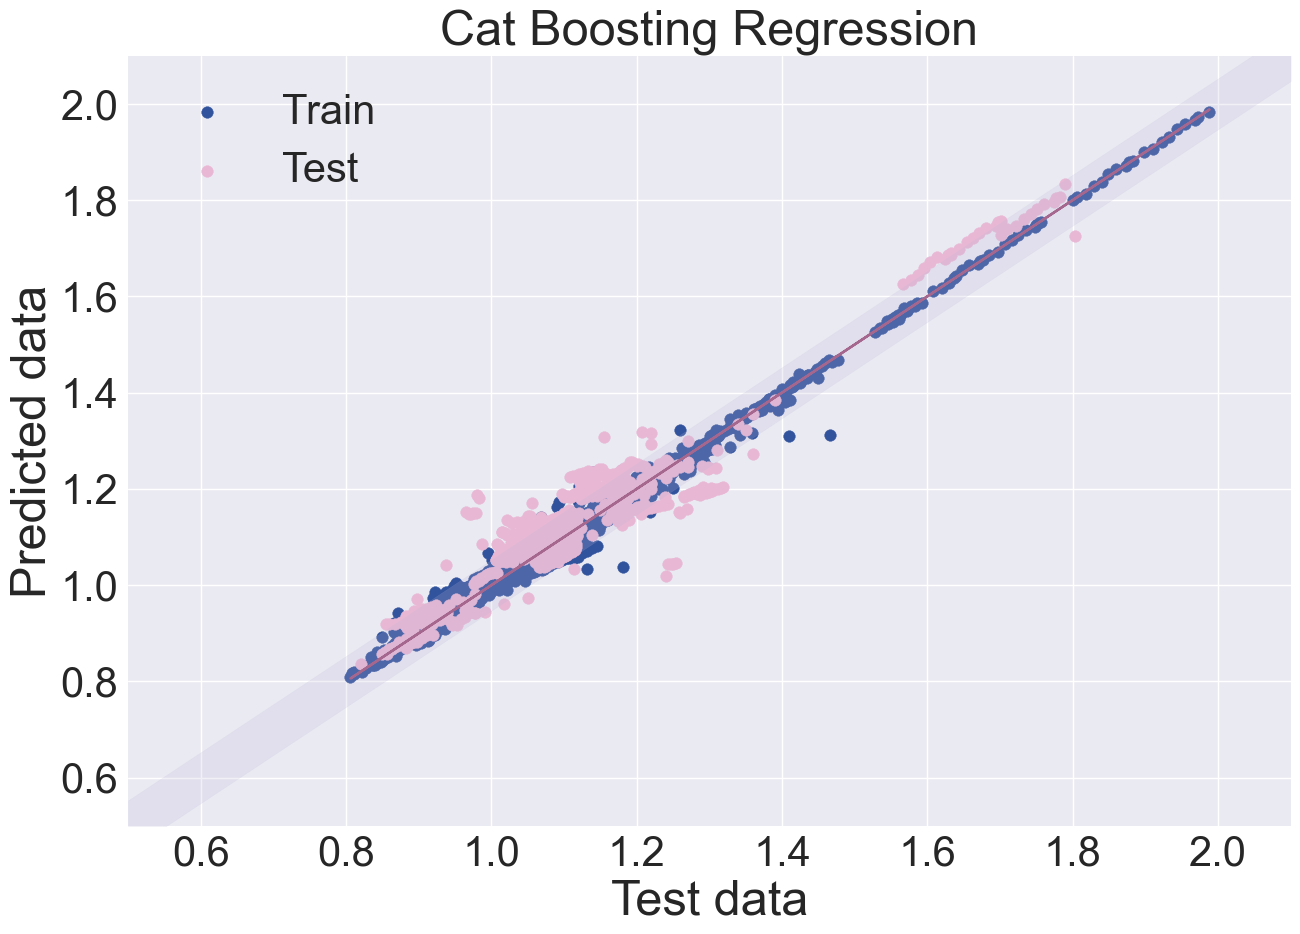

In [24]:
count = 0
#Creating a table to check accuracy on different DES classes
CBR_df = x_model[:]
CBR_df['Density_lit'] = y_model
for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #CBR
    regr_CBR = CatBoostRegressor(iterations = iterations, learning_rate = learning_rate, depth = depth)
    regr_CBR.fit(x_train_mod, y_train_mod, sample_weight=sample_w)
    y_pred = regr_CBR.predict(x_test_mod)
    y1_pred = regr_CBR.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    CBR_df['Density_train' + str(count)] = None
    CBR_df['Density_test' + str(count)] = None
    CBR_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    CBR_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Cat Boosting Regression' + str(count)] = regr_metrics(regr_CBR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Cat Boosting Regression', fontsize=35)
df_error_train

In [25]:
df_error_CBR = metrics_class(CBR_df, 'Cat Boosting Regression')
df_error_CBR

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  RMSE_train  \
0   Cat Boosting Regression0         2     I  0.998979        NaN    0.002068   
1   Cat Boosting Regression0         2   III  0.960817   0.567786    0.018294   
2   Cat Boosting Regression0         2    IV  0.997701   0.728903    0.003051   
3   Cat Boosting Regression0         2     V  0.996117   0.903351    0.008867   
4   Cat Boosting Regression0         3  None  0.997746   0.601728    0.015025   
5   Cat Boosting Regression1         2     I  0.997510        NaN    0.003230   
6   Cat Boosting Regression1         2   III  0.957374   0.845265    0.018821   
7   Cat Boosting Regression1         2    IV  0.999348  -2.366785    0.003581   
8   Cat Boosting Regression1         2     V  0.995082   0.955112    0.009768   
9   Cat Boosting Regression1         3  None  0.998117    0.95887    0.011791   
10  Cat Boosting Regression2         2     I  0.999190       None    0.002077   
11  Cat Boosting Regression2         2   III  0.965265   0.736256    0.016750   
12  Cat Boosting Regression2         2    IV  0.999212       None    0.003571   
13  Cat Boosting Regression2         2     V  0.995996   0.735278    0.008970   
14  Cat Boosting Regression2         3  None  0.998783   0.786677    0.010668   
15  Cat Boosting Regression3         2     I  0.998941        NaN    0.002295   
16  Cat Boosting Regression3         2   III  0.961582     0.7718    0.018580   
17  Cat Boosting Regression3         2    IV  0.998817  -3.852364    0.003247   
18  Cat Boosting Regression3         2     V  0.995835   0.918702    0.009032   
19  Cat Boosting Regression3         3  None  0.996559   0.803805    0.015283   
20  Cat Boosting Regression4         2     I  0.998706   0.597133    0.002605   
21  Cat Boosting Regression4         2   III  0.966182   0.624373    0.017256   
22  Cat Boosting Regression4         2    IV  0.999210 -25.083181    0.003528   
23  Cat Boosting Regression4         2     V  0.994353   0.815891    0.010579   
24  Cat Boosting Regression4         3  None  0.997923   0.972555    0.011910   

   RMSE_test  
0   0.027625  
1   0.056806  
2   0.094932  
3   0.035272  
4   0.134422  
5   0.094993  
6   0.038508  
7   0.059417  
8   0.028711  
9   0.025236  
10      None  
11    0.0492  
12      None  
13  0.060601  
14  0.031737  
15   0.05776  
16  0.036761  
17  0.169538  
18  0.037235  
19  0.121759  
20  0.038083  
21  0.053225  
22  0.132786  
23  0.052839  
24  0.042844

### 4.3. Extreme Gradient Boosting (XGBoost)
The XGBoost is a computationally efficient implementation of gradient boosting over decision trees. In addition to the optimized program code, the authors propose various improvements to the algorithm.

In [26]:
#We optimize for XGB
regr_XGB = XGBRegressor()

search_space = {"n_estimators": Integer(50, 350),
    "max_depth": Integer(2, 30),
    "subsample": Real(0.05, 1.0),
    "colsample_bytree": Real(0.05, 1.0)}

#Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_XGB = BayesSearchCV(estimator = regr_XGB, search_spaces=search_space, cv = custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_XGB.fit(x_train01, y_model, sample_weight=sample_weight)

n_estimators = opt_XGB.best_estimator_.n_estimators
max_depth = opt_XGB.best_estimator_.max_depth
subsample = opt_XGB.best_estimator_.subsample
colsample_bytree = opt_XGB.best_estimator_.colsample_bytree

print('n_estimators:', n_estimators,'max_depth:', max_depth, 'subsample:', subsample,'colsample_bytree:', colsample_bytree)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The objective has been evaluated at this point before.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



r2_test: 0.9198011463086306
MAE_test: 0.0415863890137098
MSE_test: 0.0029308352645919895
RMSE_test: 0.0541371892934237
r2_train: 0.985259242839896
MAE_train: 0.010825157615213191
MSE_train: 0.00034218720403044064
RMSE_train: 0.018498302733776433



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8836075782717622
MAE_test: 0.03627474032766723
MSE_test: 0.0022023764632745635
RMSE_test: 0.04692948394426007
r2_train: 0.9865534705265532
MAE_train: 0.011154176917470313
MSE_train: 0.00036441436067536357
RMSE_train: 0.019089640140017402



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8190002197624557
MAE_test: 0.03680958731706966
MSE_test: 0.0023810278220110174
RMSE_test: 0.04879577668211684
r2_train: 0.9877458037477844
MAE_train: 0.010875812601271573
MSE_train: 0.00035619623508654363
RMSE_train: 0.018873161767084593



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8964529241800885
MAE_test: 0.04719862834129658
MSE_test: 0.004837436156986487
RMSE_test: 0.06955167975675704
r2_train: 0.9823757403231445
MAE_train: 0.011633660313157951
MSE_train: 0.00035375960089573035
RMSE_train: 0.018808498103137592
r2_test: 0.8537499057033533
MAE_test: 0.04408225054645145
MSE_test: 0.0035921336016860326
RMSE_test: 0.05993441083122476
r2_train: 0.9864768913959397
MAE_train: 0.011122265850693926
MSE_train: 0.0003572257767534705
RMSE_train: 0.018900417369822033



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  ...  \
0                   0.784980                   0.799245  ...   
1                   0.762418                   0.802704  ...   
2                   0.065696                   0.072823  ...   
3                   0.105353                   0.069613  ...   

   Cat Boosting Regression0  Cat Boosting Regression1  \
0                  0.988967                  0.990255   
1                  0.837480                  0.930436   
2                  0.016004                  0.016251   
3                  0.077066                  0.036281   

   Cat Boosting Regression2  Cat Boosting Regression3  \
0                  0.992978                  0.986980   
1                  0.811178                  0.894552   
2                  0.014287                  0.016166   
3                  0.049839                  0.070187   

   Cat Boosting Regression4  XGBoosting Regression0  XGBoosting Regression1  \
0                  0.991665                0.985259                0.986553   
1                  0.886327                0.919801                0.883608   
2                  0.014838                0.018498                0.019090   
3                  0.052839                0.054137                0.046929   

   XGBoosting Regression2  XGBoosting Regression3  XGBoosting Regression4  
0                0.987746                0.982376                0.986477  
1                0.819000                0.896453                0.853750  
2                0.018873                0.018808                0.018900  
3                0.048796                0.069552                0.059934  

[4 rows x 30 columns]

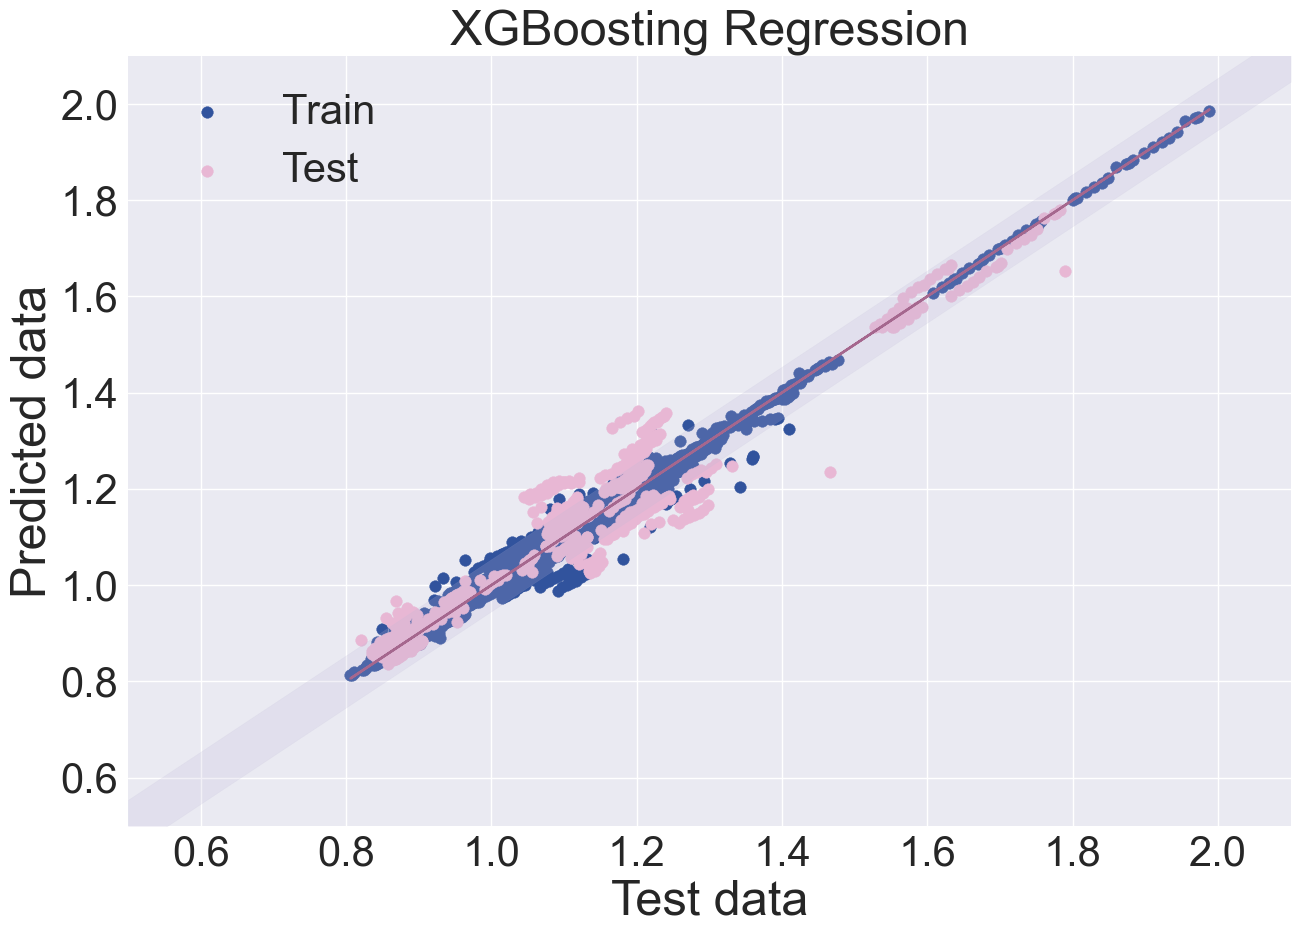

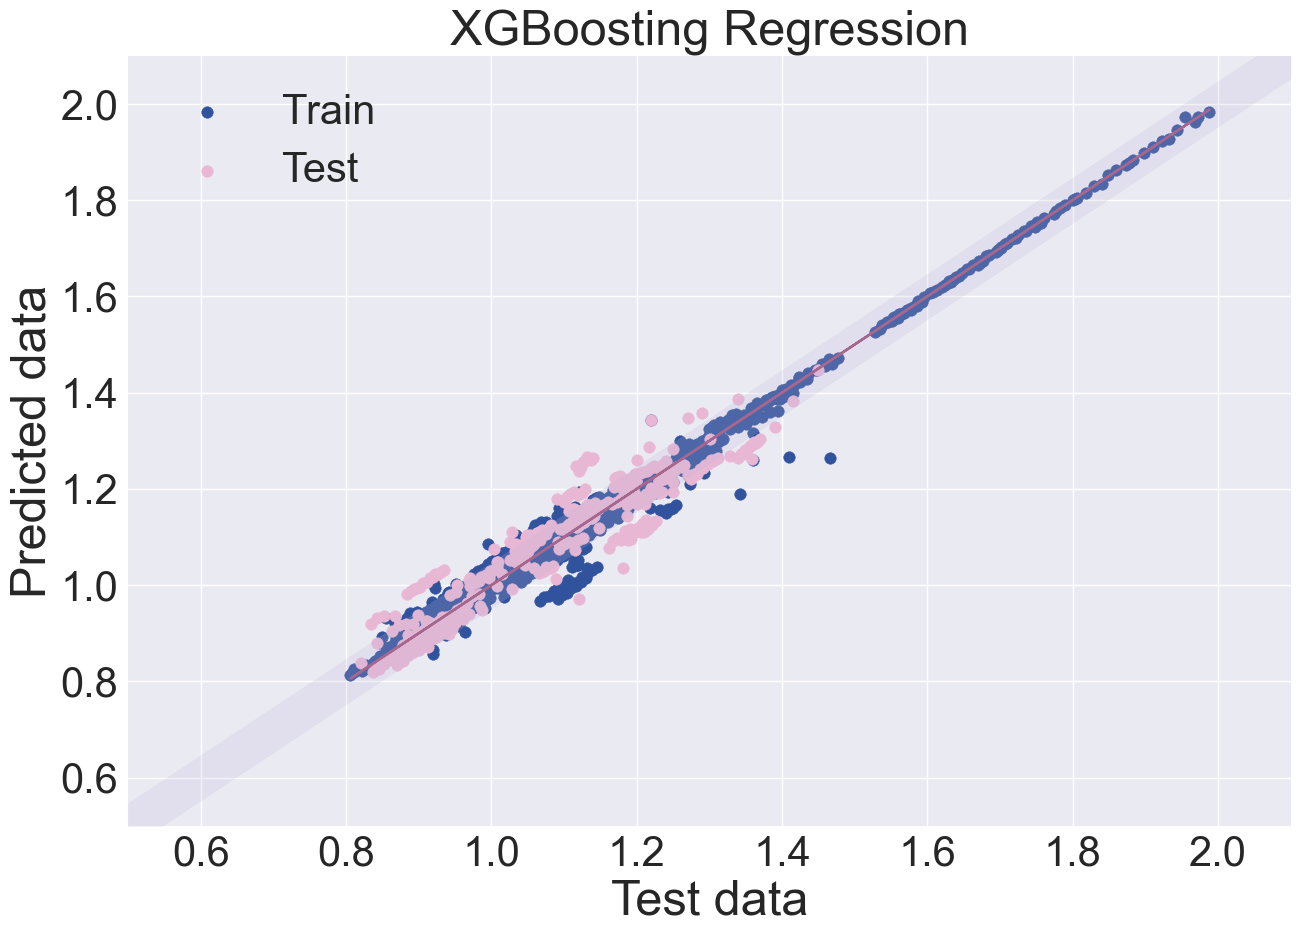

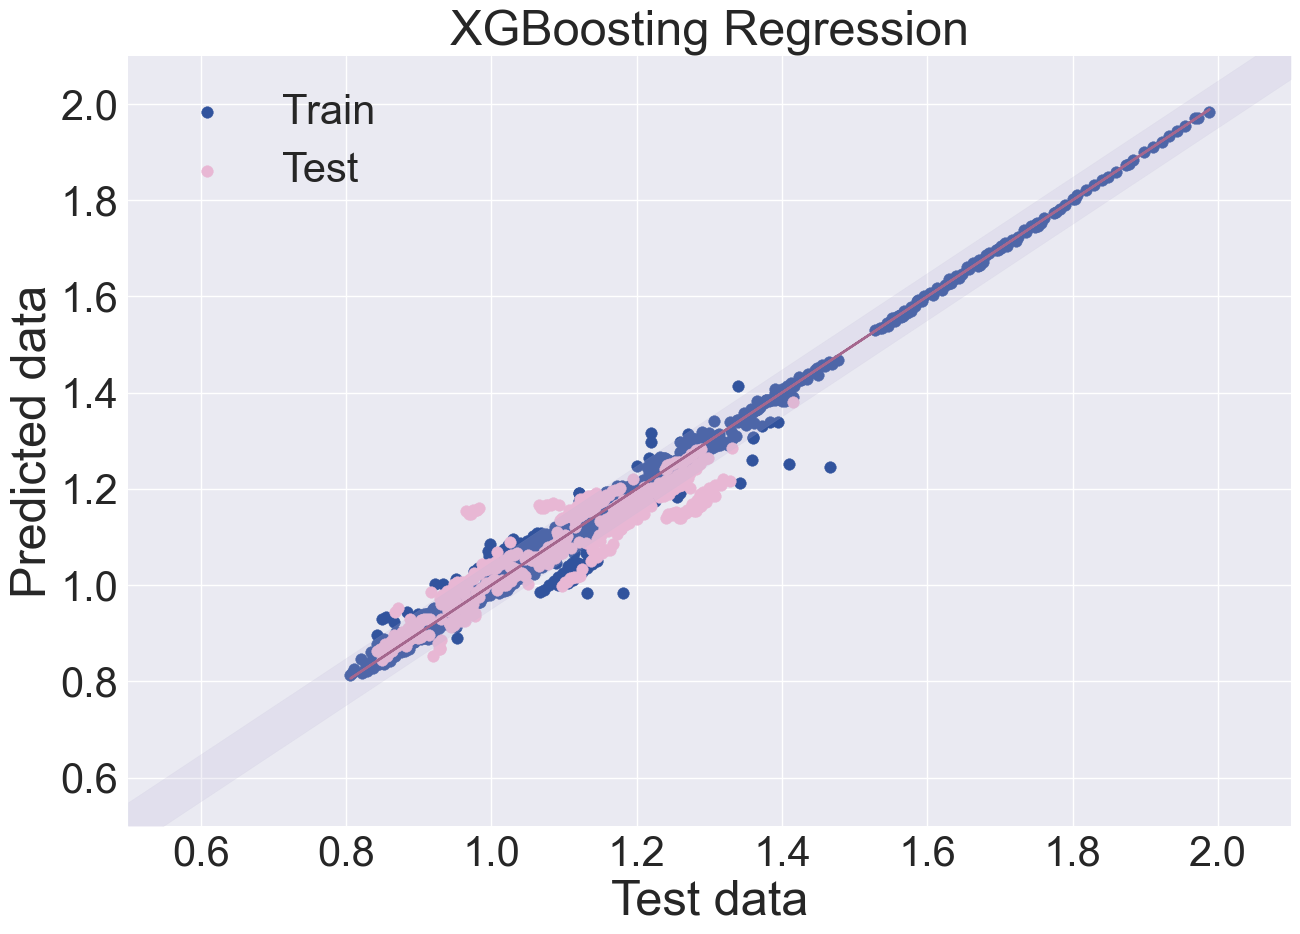

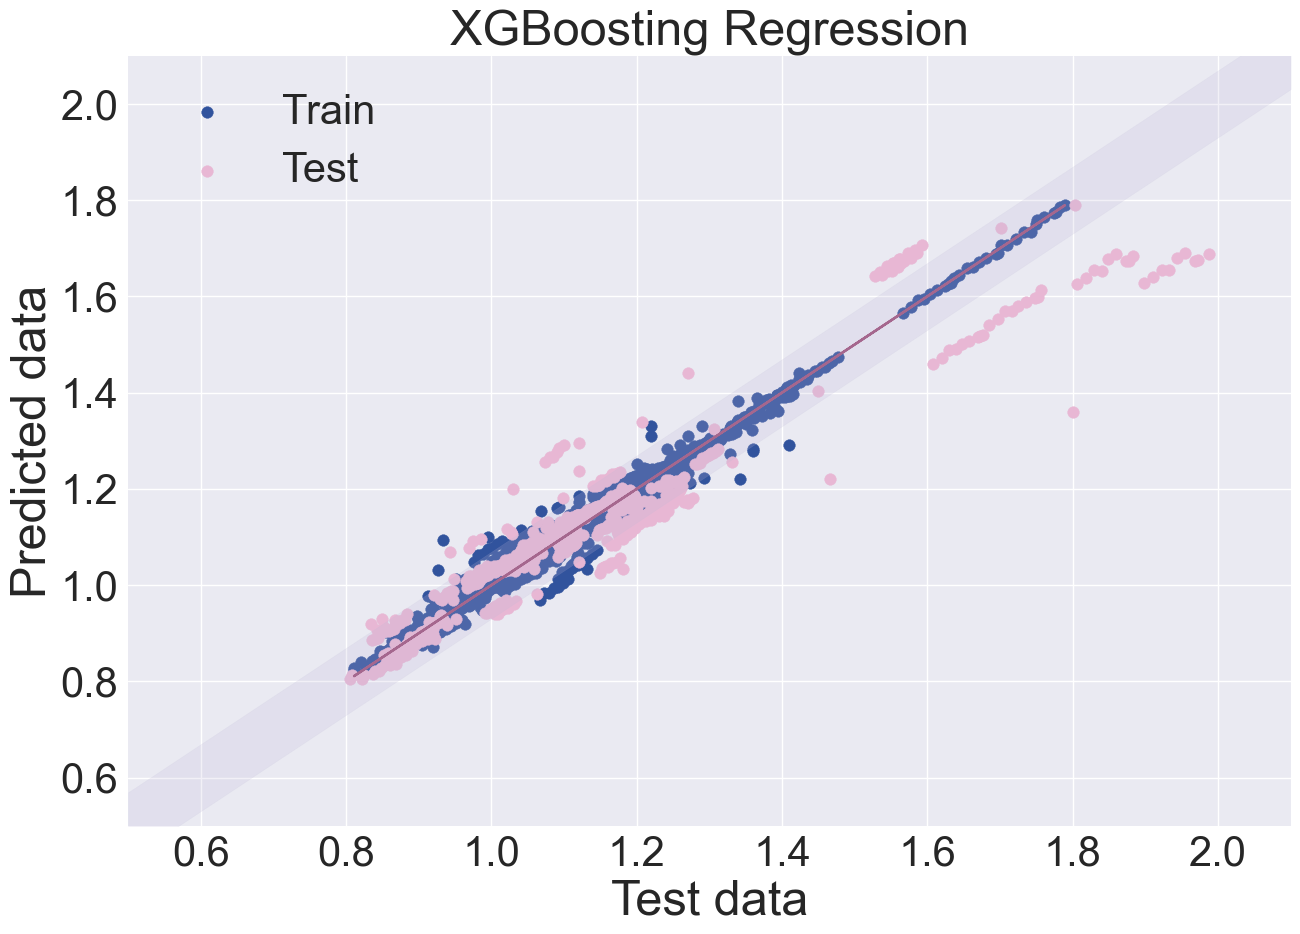

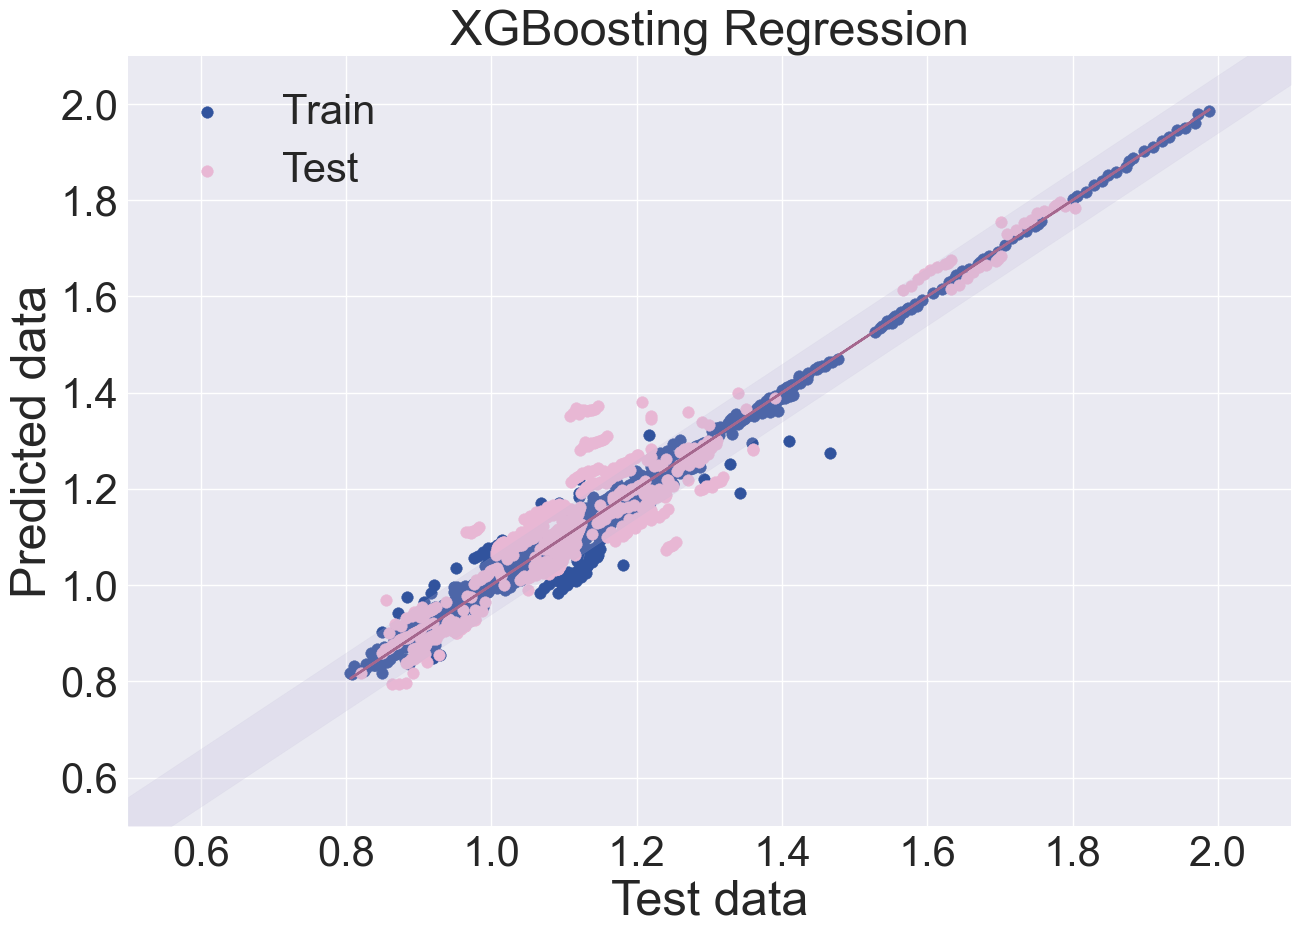

In [27]:
count = 0
#Creating a table to check accuracy on different DES classes
XGB_df = x_model[:]
XGB_df['Density_lit'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data 
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #XGB
    regr_XGB = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, subsample = subsample, colsample_bytree = colsample_bytree)
    regr_XGB.fit(x_train_mod, y_train_mod, sample_weight=sample_w)
    y_pred = regr_XGB.predict(x_test_mod)
    y1_pred = regr_XGB.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    XGB_df['Density_train' + str(count)] = None
    XGB_df['Density_test' + str(count)] = None
    XGB_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    XGB_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['XGBoosting Regression' + str(count)] = regr_metrics(regr_XGB, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('XGBoosting Regression', fontsize=35)
df_error_train

In [28]:
df_error_XGB = metrics_class(XGB_df, 'XGBoosting Regression')
df_error_XGB

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  RMSE_train  \
0   XGBoosting Regression0         2     I  0.999465        NaN    0.001497   
1   XGBoosting Regression0         2   III  0.946361   0.495672    0.021405   
2   XGBoosting Regression0         2    IV  0.996194      0.957    0.003925   
3   XGBoosting Regression0         2     V  0.995936   0.912648    0.009072   
4   XGBoosting Regression0         3  None  0.997357   0.913259    0.016271   
5   XGBoosting Regression1         2     I  0.997914        NaN    0.002956   
6   XGBoosting Regression1         2   III  0.941391   0.703938    0.022069   
7   XGBoosting Regression1         2    IV  0.999266  -2.378566    0.003801   
8   XGBoosting Regression1         2     V  0.991853   0.930556    0.012573   
9   XGBoosting Regression1         3  None  0.998155     0.9693    0.011672   
10  XGBoosting Regression2         2     I  0.998695       None    0.002635   
11  XGBoosting Regression2         2   III  0.939780   0.769203    0.022055   
12  XGBoosting Regression2         2    IV  0.998795       None    0.004416   
13  XGBoosting Regression2         2     V  0.993412   0.747861    0.011506   
14  XGBoosting Regression2         3  None  0.997195   0.566358    0.016197   
15  XGBoosting Regression3         2     I  0.998715        NaN    0.002527   
16  XGBoosting Regression3         2   III  0.946401   0.746004    0.021946   
17  XGBoosting Regression3         2    IV  0.998585  -1.108659    0.003553   
18  XGBoosting Regression3         2     V  0.995114   0.895457    0.009783   
19  XGBoosting Regression3         3  None  0.997291   0.792263    0.013561   
20  XGBoosting Regression4         2     I  0.999307   0.937957    0.001906   
21  XGBoosting Regression4         2   III  0.942520    0.46717    0.022497   
22  XGBoosting Regression4         2    IV  0.999228 -26.181677    0.003490   
23  XGBoosting Regression4         2     V  0.991994   0.833529    0.012597   
24  XGBoosting Regression4         3  None  0.997886   0.985708    0.012017   

   RMSE_test  
0   0.015321  
1   0.061363  
2   0.037808  
3   0.033533  
4   0.062733  
5   0.071047  
6   0.053266  
7   0.059521  
8   0.035711  
9   0.021803  
10      None  
11  0.046024  
12      None  
13  0.059144  
14  0.045249  
15  0.171126  
16  0.038783  
17  0.111762  
18  0.042224  
19  0.125289  
20  0.014945  
21  0.063391  
22  0.135554  
23  0.050244  
24  0.030918

**Conclusion:** Boosters show the best results among all the models used by various metrics

## 5. Прочие модели

### 5.1. Support Vector Machine
The main idea of the method is to translate the original vectors into a higher dimensional space and search for a separating hyperplane with the largest gap in this space. Two parallel hyperplanes are constructed on both sides of the hyperplane separating the classes. The separating hyperplane will be the hyperplane that creates the greatest distance to two parallel hyperplanes. The algorithm is based on the assumption that the greater the difference or distance between these parallel hyperplanes, the smaller the average classifier error will be.

In [29]:
#We optimize for SVM
regr_SVM = SVR()
search_space = {"kernel": Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    "gamma": Real(0.001, 1),
    "epsilon": Real(0.001, 0.2),
    "C": Real(2, 20)}

#Scaling the data
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sc_y = MinMaxScaler(feature_range=(0, 1))
y_train01 = np.ravel(sc_y.fit_transform(np.array(y_model).reshape(-1, 1)))
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_SVM = BayesSearchCV(estimator = regr_SVM, search_spaces=search_space, cv=custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_SVM.fit(x_train01, y_train01, sample_weight=sample_weight)

kernel = opt_SVM.best_estimator_.kernel
gamma = opt_SVM.best_estimator_.gamma
epsilon = opt_SVM.best_estimator_.epsilon
C = opt_SVM.best_estimator_.C

print('kernel:', kernel,'gamma:', gamma, 'epsilon:', epsilon, 'C:', C)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



r2_test: 0.8973983098132862
MAE_test: 0.039384694746322516
MSE_test: 0.0037495380290993342
RMSE_test: 0.061233471476793915
r2_train: 0.9697027187233683
MAE_train: 0.0131372759557883
MSE_train: 0.000703311360276231
RMSE_train: 0.026520018104749306



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.8410408535521214
MAE_test: 0.0309819554711765
MSE_test: 0.003007823684401333
RMSE_test: 0.054843629387571834
r2_train: 0.9727252072817942
MAE_train: 0.01163549519337342
MSE_train: 0.0007391740873052376
RMSE_train: 0.02718775620210755



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.6229068169573581
MAE_test: 0.035670519477147784
MSE_test: 0.004960610223597285
RMSE_test: 0.07043159960981495
r2_train: 0.9788140371769278
MAE_train: 0.011379255166127296
MSE_train: 0.0006158184542619347
RMSE_train: 0.024815689679352753



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.770599967784183
MAE_test: 0.0505064348043605
MSE_test: 0.010716942042715486
RMSE_test: 0.10352266439150166
r2_train: 0.9596975888403612
MAE_train: 0.012993049219777083
MSE_train: 0.0008089624840067706
RMSE_train: 0.028442265802969543
r2_test: 0.897473483451658
MAE_test: 0.030173855631519746
MSE_test: 0.002518213385969506
RMSE_test: 0.05018180333516828
r2_train: 0.9713247402511499
MAE_train: 0.01191967631986513
MSE_train: 0.0007574842617410431
RMSE_train: 0.027522431973592797



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  ...  \
0                   0.784980                   0.799245  ...   
1                   0.762418                   0.802704  ...   
2                   0.065696                   0.072823  ...   
3                   0.105353                   0.069613  ...   

   XGBoosting Regression0  XGBoosting Regression1  XGBoosting Regression2  \
0                0.985259                0.986553                0.987746   
1                0.919801                0.883608                0.819000   
2                0.018498                0.019090                0.018873   
3                0.054137                0.046929                0.048796   

   XGBoosting Regression3  XGBoosting Regression4  Support Vector Machine0  \
0                0.982376                0.986477                 0.969703   
1                0.896453                0.853750                 0.897398   
2                0.018808                0.018900                 0.026520   
3                0.069552                0.059934                 0.061233   

   Support Vector Machine1  Support Vector Machine2  Support Vector Machine3  \
0                 0.972725                 0.978814                 0.959698   
1                 0.841041                 0.622907                 0.770600   
2                 0.027188                 0.024816                 0.028442   
3                 0.054844                 0.070432                 0.103523   

   Support Vector Machine4  
0                 0.971325  
1                 0.897473  
2                 0.027522  
3                 0.050182  

[4 rows x 35 columns]

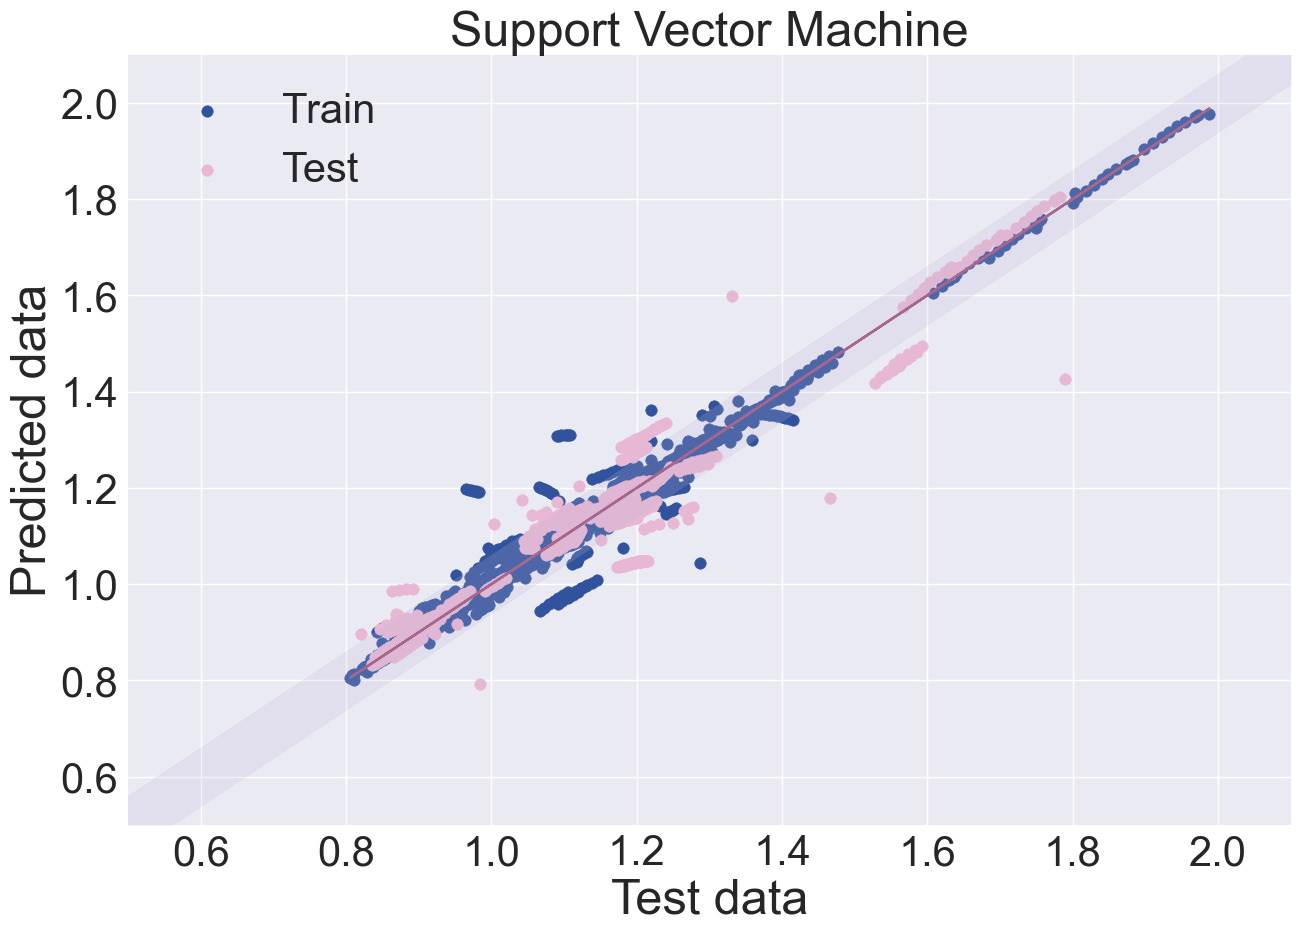

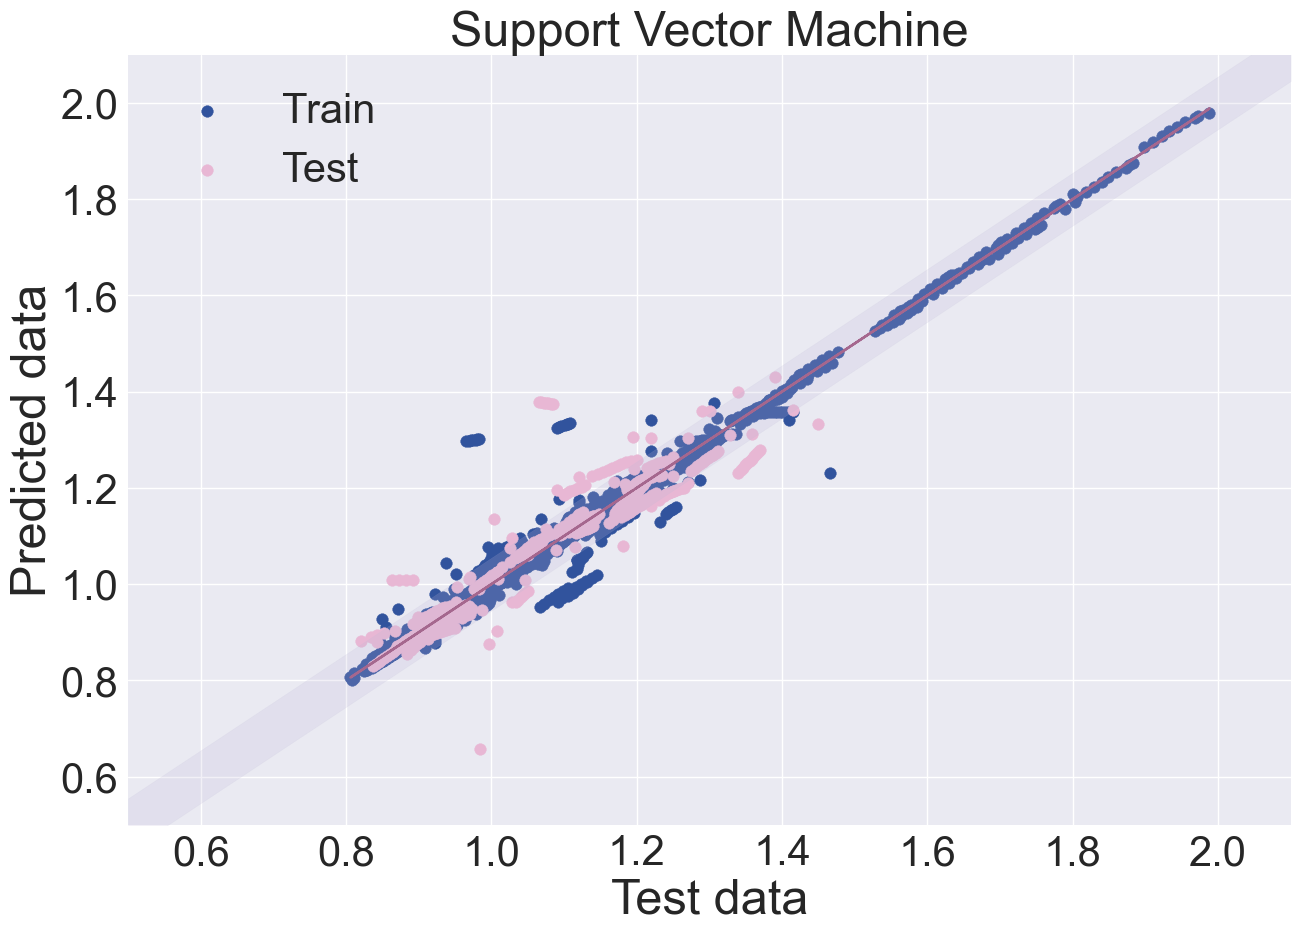

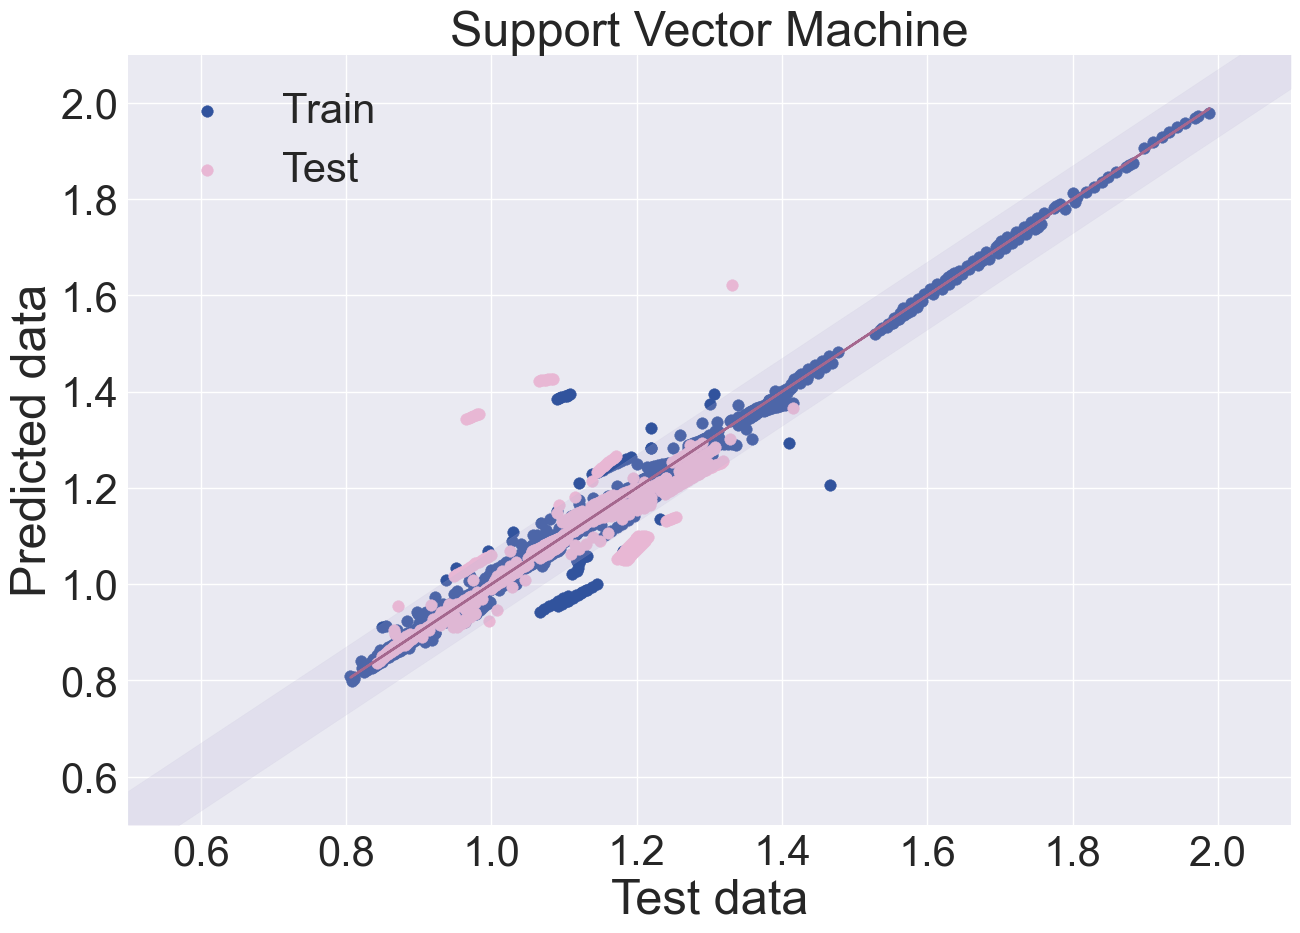

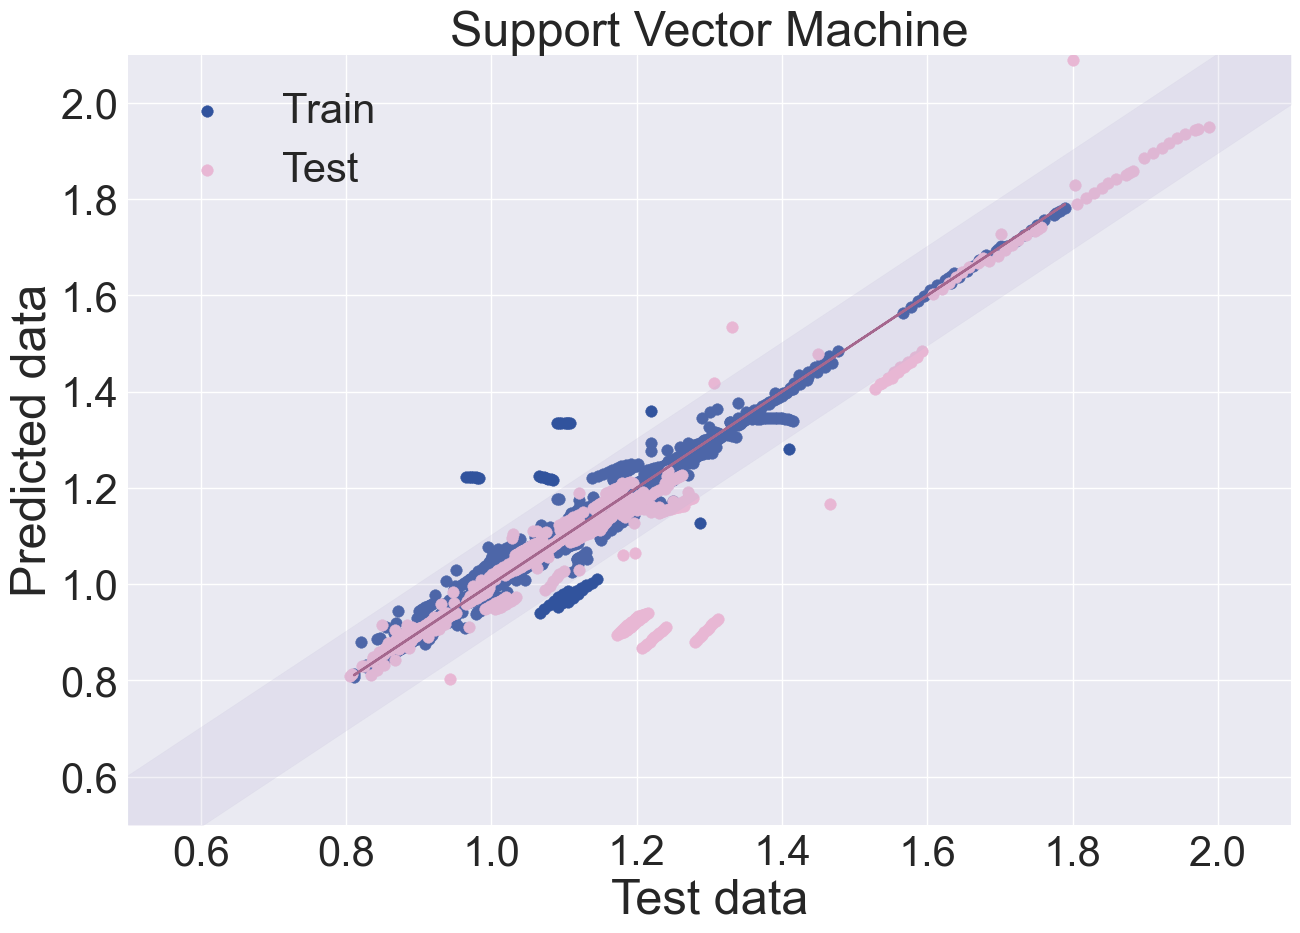

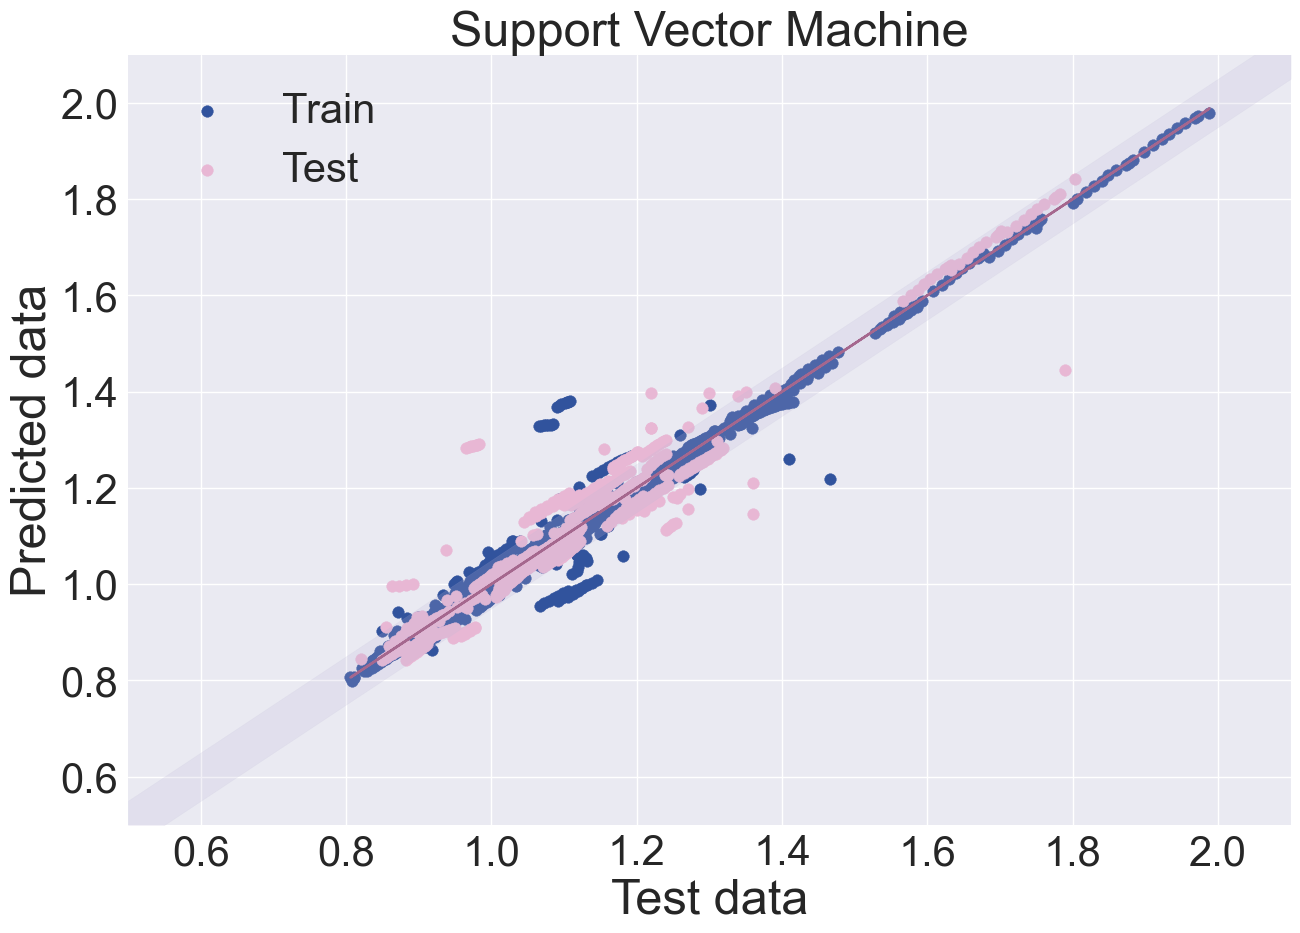

In [30]:
#SVM
count = 0
#Creating a table to check accuracy on different DES classes
SVM_df = x_model[:]
SVM_df['Density_lit'] = y_model

for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))

    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    sc_y = MinMaxScaler(feature_range=(0, 1))
    y_train_mod = np.ravel(sc_y.fit_transform(np.array(y_train_mod).reshape(-1, 1)))
  
    #Support Vector Machine
    SVM_regr = SVR(kernel = kernel, gamma = gamma, epsilon = epsilon, C = C)
    SVM_regr.fit(x_train_mod, y_train_mod,sample_weight=sample_w)
    y_pred = SVM_regr.predict(x_test_mod)
    y1_pred = SVM_regr.predict(x_train_mod)
  
    #Rescaling the data
    y_train_mod = sc_y.inverse_transform(y_train_mod.reshape(-1, 1))
    y_pred = sc_y.inverse_transform(y_pred.reshape(-1, 1))
    y1_pred = sc_y.inverse_transform(y1_pred.reshape(-1, 1))
    
    #Filling in the table in accordance with the metrics
    SVM_df['Density_train' + str(count)] = None
    SVM_df['Density_test' + str(count)] = None
    SVM_df['Density_train' + str(count)].iloc[train_idx] = y1_pred[:, 0]
    SVM_df['Density_test' + str(count)].iloc[val_idx] = y_pred[:, 0]

    #Calculating metrics
    df_error_train['Support Vector Machine' + str(count)] = regr_metrics(regr_RFR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Support Vector Machine', fontsize=35)
df_error_train

In [31]:
df_error_SVM = metrics_class(SVM_df, 'Support Vector Machine')
df_error_SVM

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  RMSE_train  \
0   Support Vector Machine0         2     I  0.979274        NaN    0.009319   
1   Support Vector Machine0         2   III  0.945175    0.84704    0.021640   
2   Support Vector Machine0         2    IV  0.987506   0.721465    0.007112   
3   Support Vector Machine0         2     V  0.923893    0.89492    0.039258   
4   Support Vector Machine0         3  None  0.999071   0.746396    0.009646   
5   Support Vector Machine1         2     I  0.977621        NaN    0.009683   
6   Support Vector Machine1         2   III  0.947401   0.862963    0.020907   
7   Support Vector Machine1         2    IV  0.997358  -4.415248    0.007211   
8   Support Vector Machine1         2     V  0.899736   0.763955    0.044108   
9   Support Vector Machine1         3  None  0.999038   0.288924    0.008429   
10  Support Vector Machine2         2     I  0.983993       None    0.009229   
11  Support Vector Machine2         2   III  0.933209   0.930606    0.023227   
12  Support Vector Machine2         2    IV  0.996761       None    0.007241   
13  Support Vector Machine2         2     V  0.949944  -0.157306    0.031717   
14  Support Vector Machine2         3  None  0.998311  -1.230617    0.012567   
15  Support Vector Machine3         2     I  0.986807        NaN    0.008100   
16  Support Vector Machine3         2   III  0.943733   0.889081    0.022485   
17  Support Vector Machine3         2    IV  0.995852  -1.179237    0.006082   
18  Support Vector Machine3         2     V  0.905967   0.913193    0.042915   
19  Support Vector Machine3         3  None  0.996954   0.376571    0.014380   
20  Support Vector Machine4         2     I  0.983519  -1.307939    0.009298   
21  Support Vector Machine4         2   III  0.943189   0.811068    0.022366   
22  Support Vector Machine4         2    IV  0.996867 -10.918357    0.007029   
23  Support Vector Machine4         2     V  0.919799   0.536962    0.039868   
24  Support Vector Machine4         3  None  0.997448   0.942993    0.013202   

   RMSE_test  
0   0.120438  
1   0.033794  
2   0.096225  
3   0.036779  
4   0.107265  
5   0.130371  
6   0.036239  
7   0.075355  
8   0.065839  
9   0.104932  
10      None  
11  0.025237  
12      None  
13   0.12671  
14  0.102626  
15  0.077893  
16  0.025629  
17  0.113616  
18  0.038476  
19  0.217045  
20  0.091151  
21  0.037748  
22   0.08976  
23  0.083796  
24  0.061748

### 5.2. K-nearest neighbors
K-nearest neighbors is a nonparametric method that intuitively approximates the relationship between independent variables and a continuous result by averaging observations in the same area.

In [32]:
#We optimize for KNN
regr_KNN = KNeighborsRegressor()

search_space = {"n_neighbors": Integer(5, 15),
    "leaf_size": Integer(2, 10),
    "p": Real(0.1, 3),
    "algorithm": Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
    "metric": Categorical(['euclidean','manhattan'])}

#Scaling the data 
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_KNN = BayesSearchCV(estimator = regr_KNN, search_spaces=search_space, cv = custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_iter=32, verbose=2, n_jobs=-1)
opt_KNN.fit(x_train01, y_model)#, sample_weight=sample_weight)

n_neighbors = opt_KNN.best_estimator_.n_neighbors
weights = opt_KNN.best_estimator_.weights
leaf_size = opt_KNN.best_estimator_.leaf_size
p = opt_KNN.best_estimator_.p
algorithm = opt_KNN.best_estimator_.algorithm
metric = opt_KNN.best_estimator_.metric

print('n_neighbors:', n_neighbors,'leaf_size:', leaf_size, 'p:', p,'algorithm:', algorithm, 'metric:', metric)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

r2_test:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 0.8462881366172945
MAE_test: 0.059157931149760735
MSE_test: 0.005617339014867499
RMSE_test: 0.07494890936409615
r2_train: 0.9589872752081491
MAE_train: 0.01471864197779479
MSE_train: 0.0009520562257260811
RMSE_train: 0.03085540837075538
r2_test: 0.8366676900719882
MAE_test: 0.04163439438823917
MSE_test: 0.0030905726484291235
RMSE_test: 0.055592919049363865
r2_train: 0.965846829838148
MAE_train: 0.014198274945709426
MSE_train: 0.0009255849767142862
RMSE_train: 0.030423428089455768



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

r2_test: 0.7516383877296228
MAE_test: 0.044711325300788946
MSE_test: 0.0032671636836198647
RMSE_test: 0.05715910849217178
r2_train: 0.9673020353935606
MAE_train: 0.014532941123187353
MSE_train: 0.0009504411099749571
RMSE_train: 0.030829224933088362
r2_test: 0.8881097816176445
MAE_test: 0.0481649690577468
MSE_test: 0.005227204957069766
RMSE_test: 0.07229941187222595
r2_train: 0.9645770726387811
MAE_train: 0.014008202149407704
MSE_train: 0.0007110199733563487
RMSE_train: 0.0266649577790093
r2_test: 0.8640793830113553
MAE_test: 0.04119872221553277
MSE_test: 0.003338425303552114
RMSE_test: 0.057779107846626654
r2_train: 0.9699234700542436
MAE_train: 0.013621447488328496
MSE_train: 0.0007945001468594265
RMSE_train: 0.02818687898401358



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  ...  \
0                   0.784980                   0.799245  ...   
1                   0.762418                   0.802704  ...   
2                   0.065696                   0.072823  ...   
3                   0.105353                   0.069613  ...   

   Support Vector Machine0  Support Vector Machine1  Support Vector Machine2  \
0                 0.969703                 0.972725                 0.978814   
1                 0.897398                 0.841041                 0.622907   
2                 0.026520                 0.027188                 0.024816   
3                 0.061233                 0.054844                 0.070432   

   Support Vector Machine3  Support Vector Machine4  K-nearest neighbors0  \
0                 0.959698                 0.971325              0.958987   
1                 0.770600                 0.897473              0.846288   
2                 0.028442                 0.027522              0.030855   
3                 0.103523                 0.050182              0.074949   

   K-nearest neighbors1  K-nearest neighbors2  K-nearest neighbors3  \
0              0.965847              0.967302              0.964577   
1              0.836668              0.751638              0.888110   
2              0.030423              0.030829              0.026665   
3              0.055593              0.057159              0.072299   

   K-nearest neighbors4  
0              0.969923  
1              0.864079  
2              0.028187  
3              0.057779  

[4 rows x 40 columns]

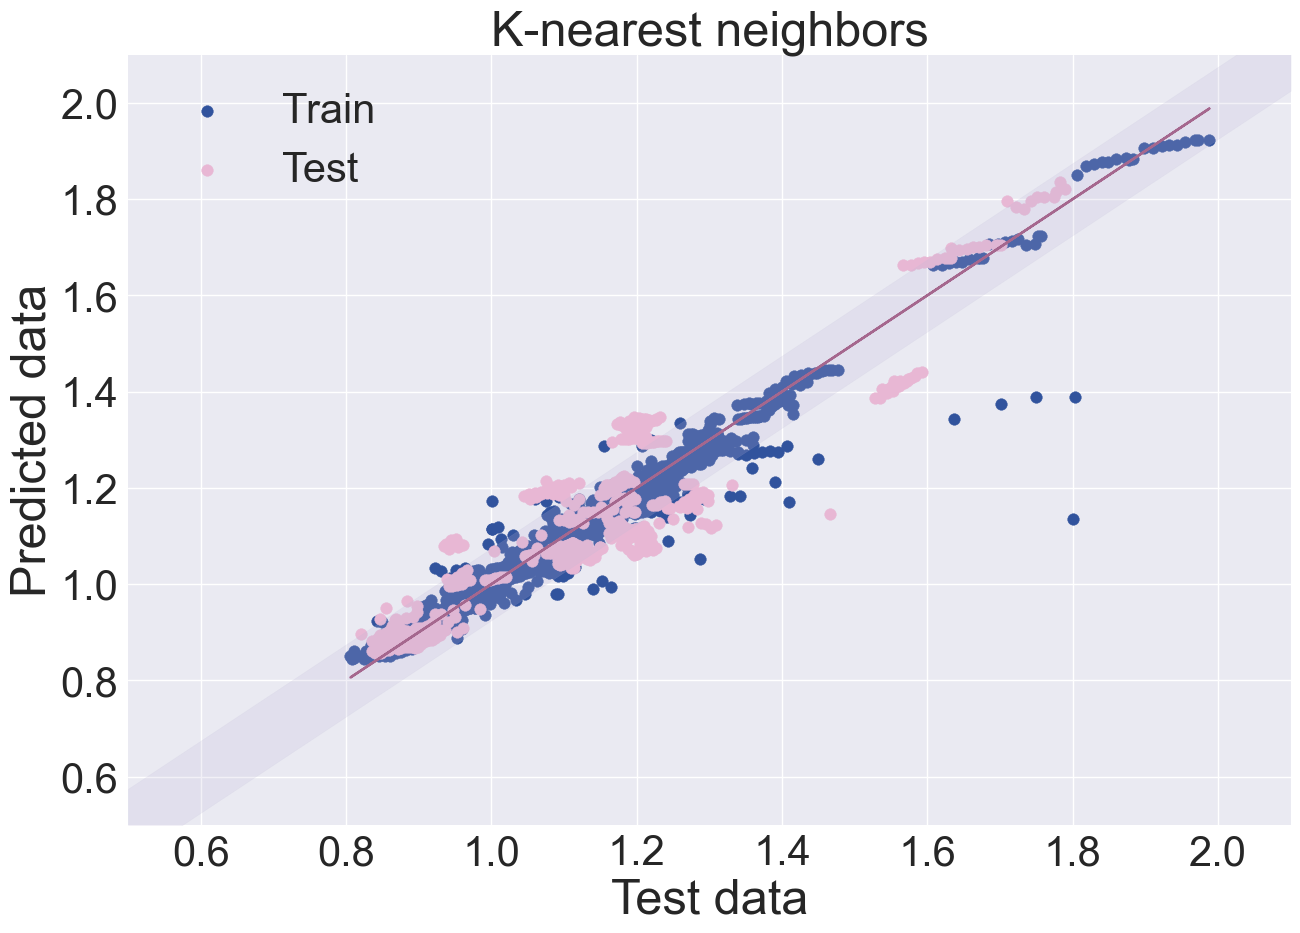

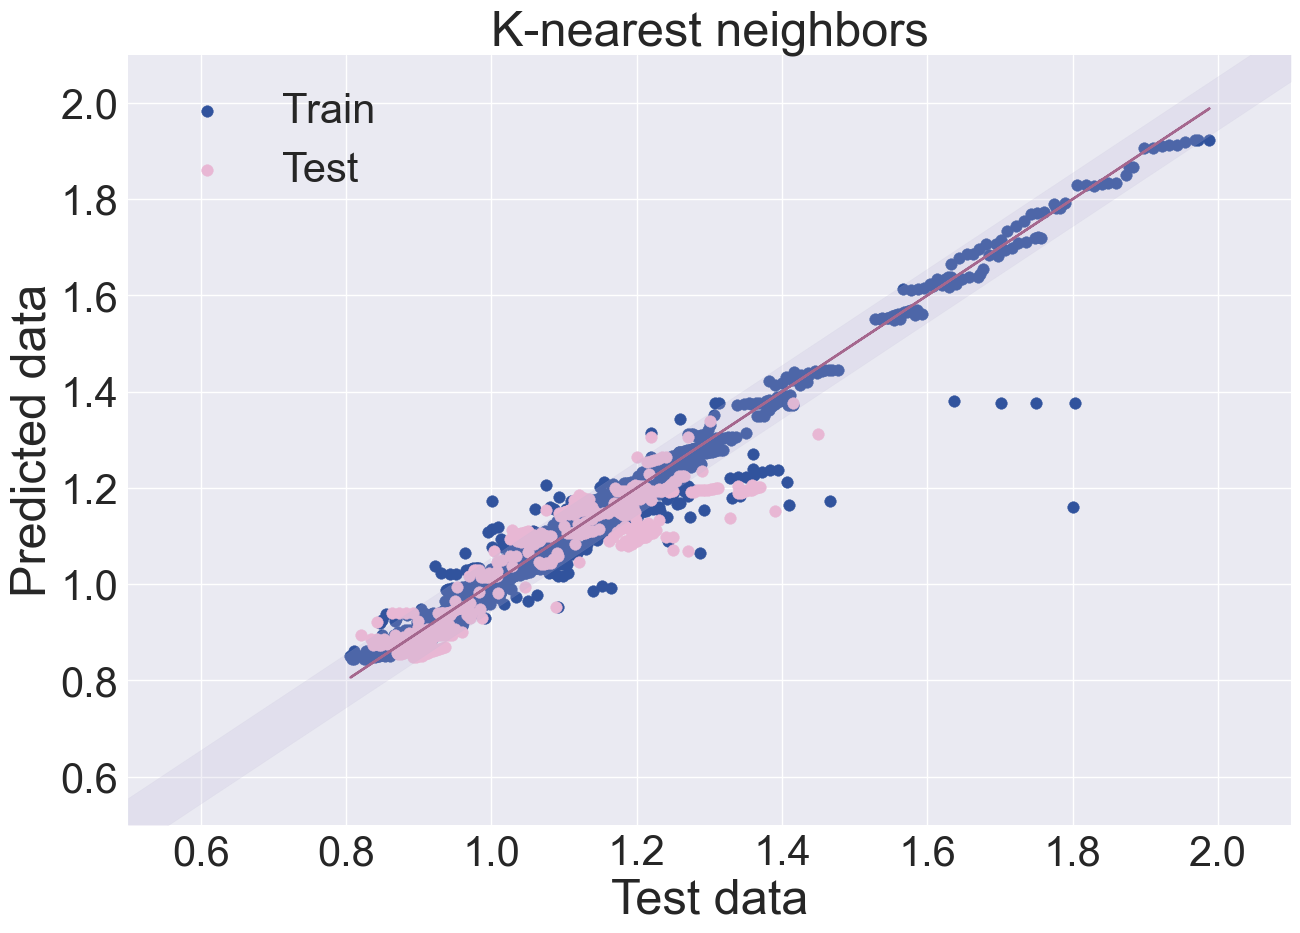

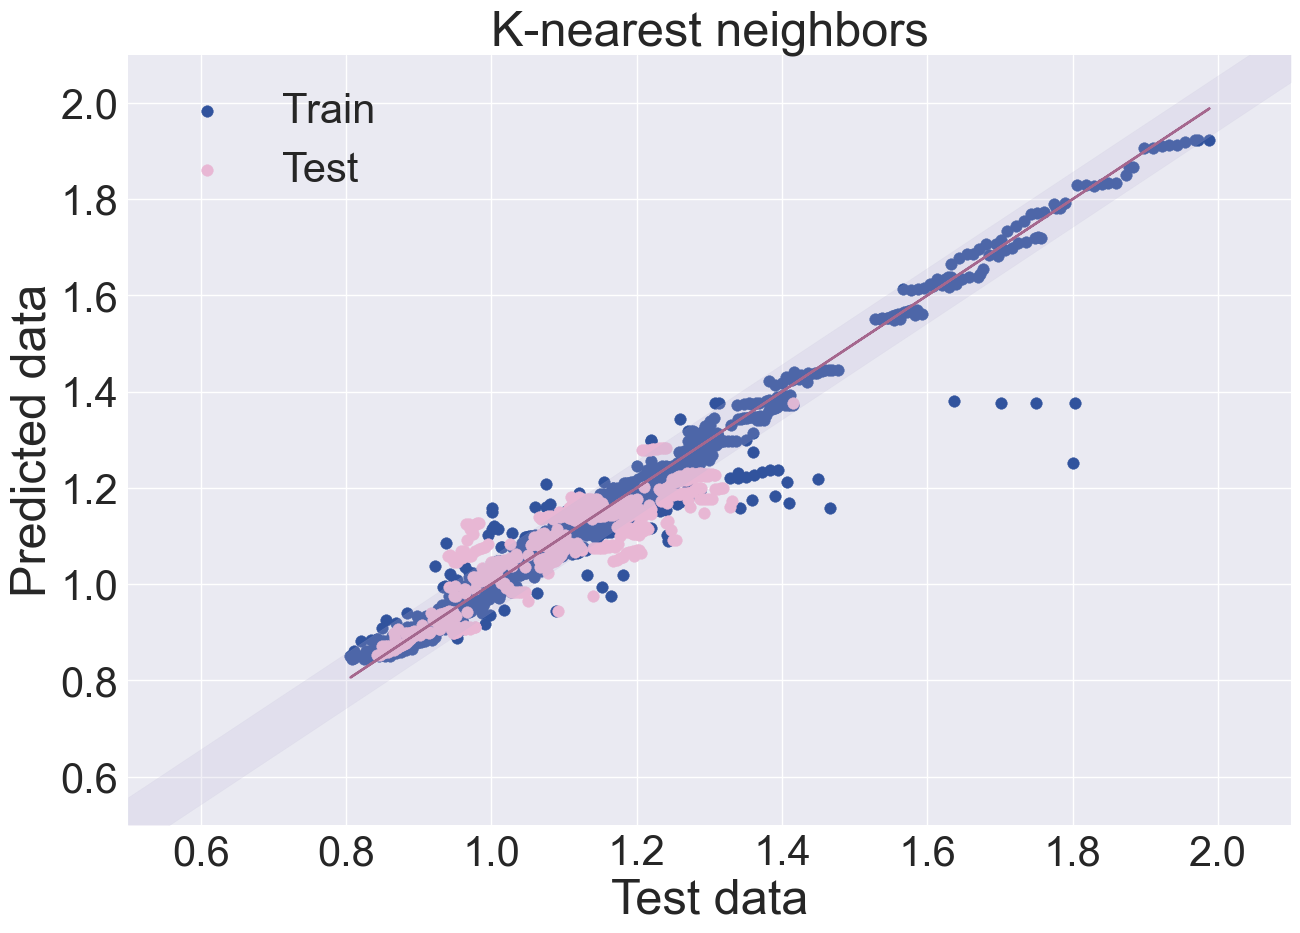

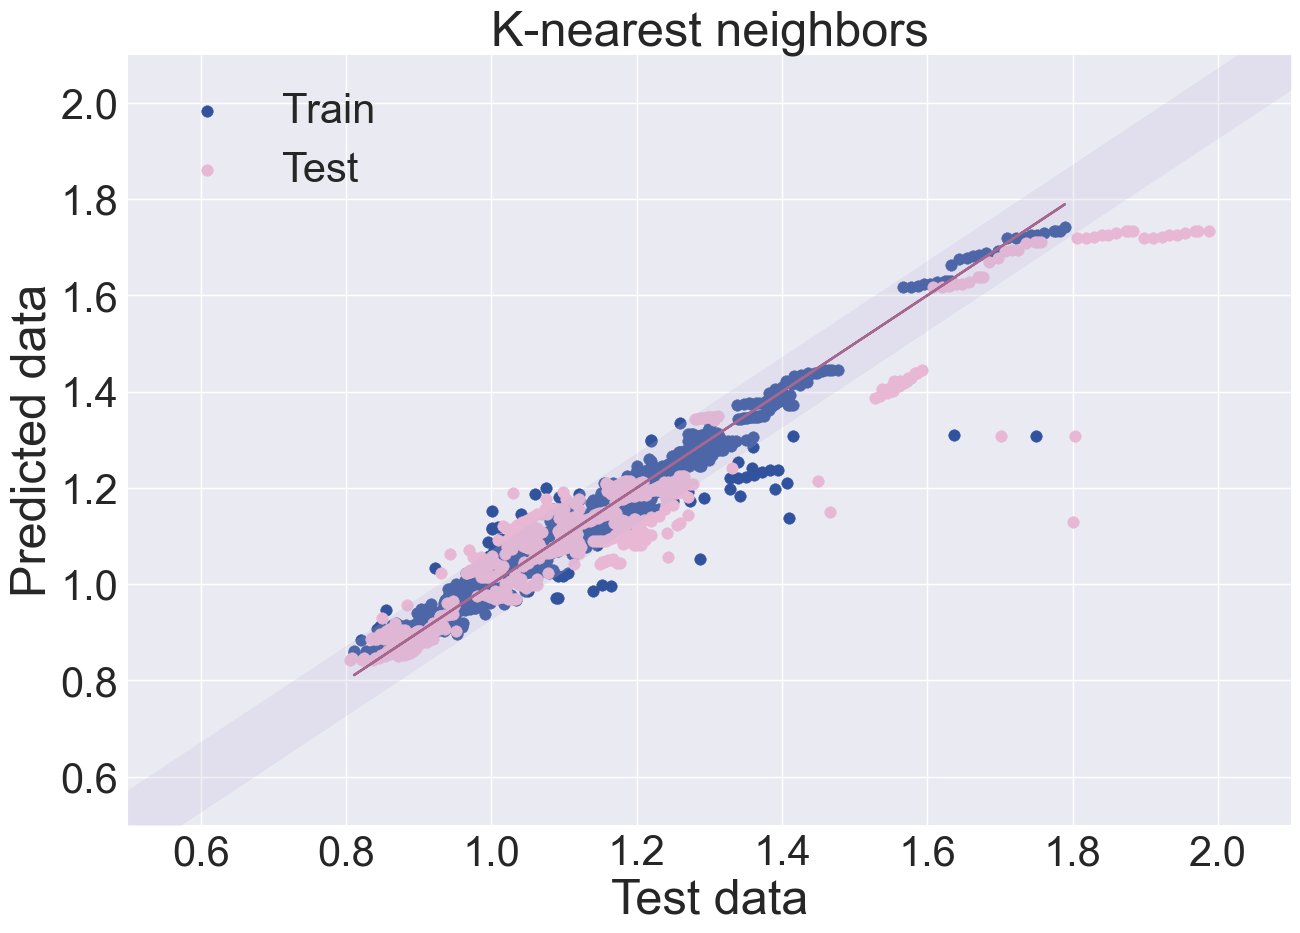

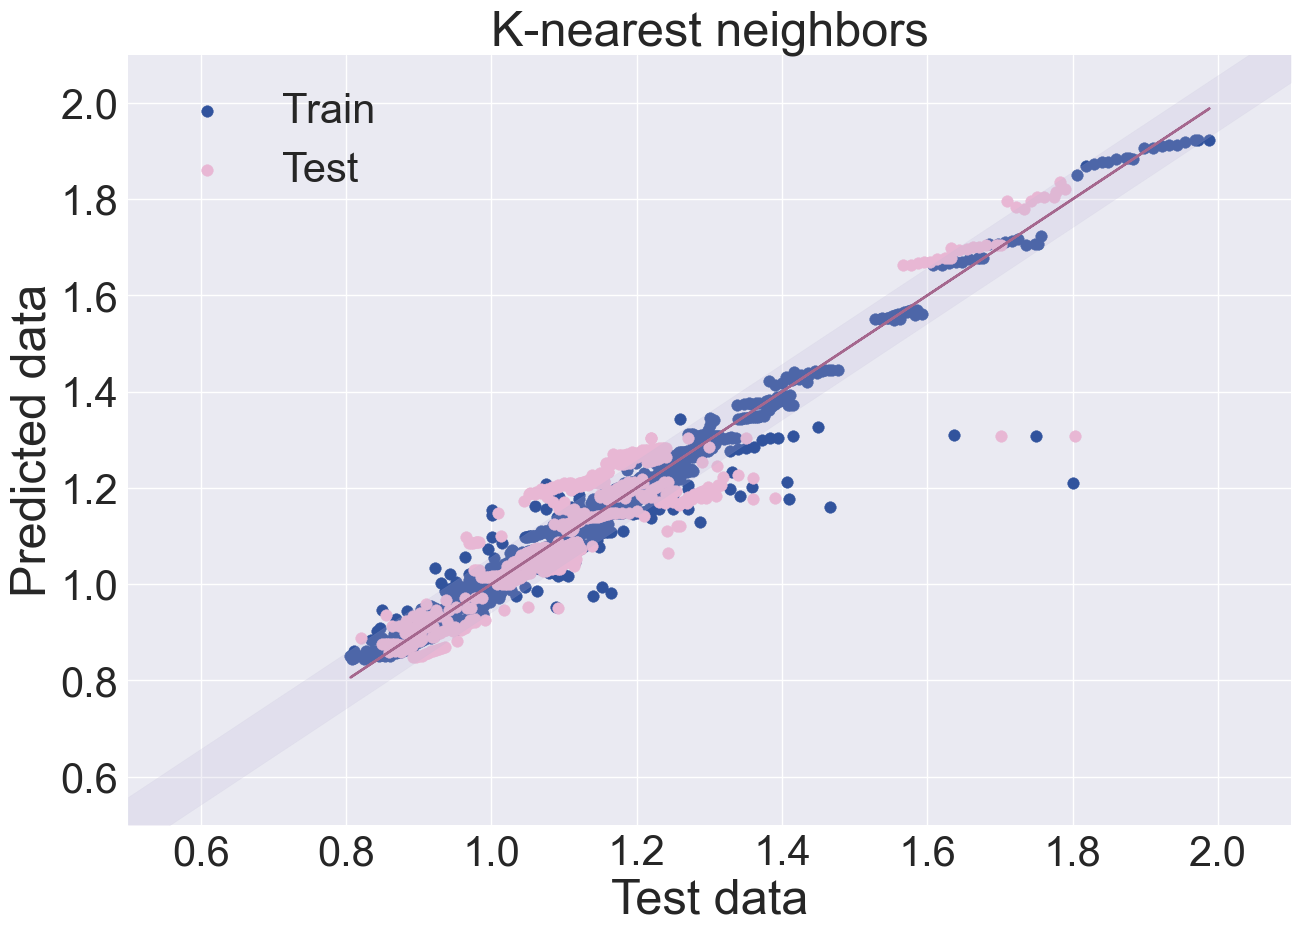

In [33]:
#KNN
count = 0
#Creating a table to check accuracy on different DES classes
KNN_df = x_model[:]
KNN_df['Density_lit'] = y_model
for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #K-nearest neighbors
    KNN_regr = KNeighborsRegressor(n_neighbors = n_neighbors,leaf_size = leaf_size, p = p, algorithm = algorithm,metric=metric)
    KNN_regr.fit(x_train_mod, y_train_mod)
    y_pred = KNN_regr.predict(x_test_mod)
    y1_pred = KNN_regr.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    KNN_df['Density_train' + str(count)] = None
    KNN_df['Density_test' + str(count)] = None
    KNN_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    KNN_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['K-nearest neighbors' + str(count)] = regr_metrics(regr_RFR, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('K-nearest neighbors', fontsize=35)
df_error_train

In [34]:
df_error_KNN = metrics_class(KNN_df, 'K-nearest neighbors')
df_error_KNN

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  RMSE_train  \
0   K-nearest neighbors0         2     I  0.285394        NaN    0.054718   
1   K-nearest neighbors0         2   III  0.952084   0.261792    0.020231   
2   K-nearest neighbors0         2    IV  0.793365   0.446477    0.028922   
3   K-nearest neighbors0         2     V  0.961369   0.885555    0.027969   
4   K-nearest neighbors0         3  None  0.910627    0.83574    0.094618   
5   K-nearest neighbors1         2     I  0.372766        NaN    0.051264   
6   K-nearest neighbors1         2   III  0.946378   0.713704    0.021109   
7   K-nearest neighbors1         2    IV  0.963486 -15.729235    0.026808   
8   K-nearest neighbors1         2     V  0.958357   0.898414    0.028426   
9   K-nearest neighbors1         3  None  0.935492   0.855505    0.069013   
10  K-nearest neighbors2         2     I  0.308190       None    0.060674   
11  K-nearest neighbors2         2   III  0.931624   0.698425    0.023501   
12  K-nearest neighbors2         2    IV  0.962985       None    0.024479   
13  K-nearest neighbors2         2     V  0.964988    0.72601    0.026526   
14  K-nearest neighbors2         3  None  0.940608  -0.068582    0.074526   
15  K-nearest neighbors3         2     I  0.507283        NaN    0.049502   
16  K-nearest neighbors3         2   III  0.951437    0.63212    0.020889   
17  K-nearest neighbors3         2    IV  0.922949  -2.327801    0.026213   
18  K-nearest neighbors3         2     V  0.960453    0.89369    0.027831   
19  K-nearest neighbors3         3  None  0.937635   0.801597    0.065064   
20  K-nearest neighbors4         2     I  0.564437  -0.220057    0.047801   
21  K-nearest neighbors4         2   III  0.955696   0.635467    0.019751   
22  K-nearest neighbors4         2    IV  0.963613  -1.593647    0.023952   
23  K-nearest neighbors4         2     V  0.965838   0.790826    0.026020   
24  K-nearest neighbors4         3  None  0.939102   0.850087    0.064496   

   RMSE_test  
0   0.065431  
1    0.07424  
2   0.135649  
3   0.038383  
4   0.086327  
5     0.0658  
6    0.05238  
7   0.132447  
8   0.043192  
9   0.047302  
10      None  
11   0.05261  
12      None  
13  0.061653  
14  0.071031  
15  0.089992  
16  0.046675  
17    0.1404  
18  0.042579  
19  0.122442  
20  0.066274  
21  0.052433  
22  0.041872  
23  0.056321  
24  0.100134

### 5.3. Multilayer perceptron (MLP)

In [35]:
#Optimization of hyperparameters
regr_MLP = MLPRegressor()

params_dict = [{'hidden_layer_sizes':  [(4,4,4,4),(4,4),(4,4,3,3),(4,3,4),(10,10,10,10,10), (3,), (6,6,6,6), (4,4), (10,5,5,10), (6,), (12,12,12), (3,3,3), (6,6,6), (3,3,3,3,3), (12, 12, 6, 6, 3, 3)],
                'activation': ['relu','identity','logistic','tanh'],
                'solver': ['adam', 'lbfgs'],
                'learning_rate':['constant','adaptive','invscaling'],
                'learning_rate_init': [0.1,0.01,0.5, 0.00001],
                'alpha': [0.01,0.1,0.001, 0.0001],
                'max_iter': [1000]}]

#Scaling the data 
sc = MinMaxScaler(feature_range=(0, 1))
x_train01 = sc.fit_transform(x_model)
sample_weight=compute_sample_weight('balanced', y=(x_model[['I','II','III','IV','V']]))
opt_MLP = GridSearchCV(MLPRegressor(), params_dict, cv=custom_cv(x_model, y_model, x_train['ind_syst'], 5, 0.2), n_jobs=-1, scoring='r2', verbose=10)
opt_MLP.fit(x_train01, y_model)#, sample_weight=sample_weight)

hidden_layer_sizes = opt_MLP.best_estimator_.hidden_layer_sizes
activation = opt_MLP.best_estimator_.activation
solver = opt_MLP.best_estimator_.solver
learning_rate = opt_MLP.best_estimator_.learning_rate
learning_rate_init = opt_MLP.best_estimator_.learning_rate_init
alpha = opt_MLP.best_estimator_.alpha

print('hidden_layer_sizes:', hidden_layer_sizes,'activation:', activation, 'solver:', solver,'learning_rate:', learning_rate, 'learning_rate_init:', learning_rate_init, 'alpha:', alpha)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
hidden_layer_sizes: (10, 10, 10, 10, 10) activation: relu solver: lbfgs learning_rate: invscaling learning_rate_init: 1e-05 alpha: 0.1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

r2_test: 0.8919786555319644
MAE_test: 0.038844968910071866
MSE_test: 0.003947597142895672
RMSE_test: 0.06282990643710741
r2_train: 0.9769089576442628
MAE_train: 0.014829427952276068
MSE_train: 0.0005360280436098312
RMSE_train: 0.023152279447385547



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


r2_test: 0.9226056956766123
MAE_test: 0.029900660763544296
MSE_test: 0.0014644544009172788
RMSE_test: 0.038268190457836894
r2_train: 0.9738878518295632
MAE_train: 0.016733258458588262
MSE_train: 0.000707665260406478
RMSE_train: 0.026601978505488608


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a

r2_test: 0.7654384186635618
MAE_test: 0.030796223041498
MSE_test: 0.003085626128407376
RMSE_test: 0.055548412474231666
r2_train: 0.9804906950231941
MAE_train: 0.014150284129686965
MSE_train: 0.0005670825600362834
RMSE_train: 0.02381349533429067
r2_test: 0.917797185967922
MAE_test: 0.04198853257801817
MSE_test: 0.0038402906277759355
RMSE_test: 0.061970078487734184
r2_train: 0.956786162500127
MAE_train: 0.018665369408434444
MSE_train: 0.0008674015355778899
RMSE_train: 0.02945168137098271
r2_test: -0.012987931623953397
MAE_test: 0.09894375186601043
MSE_test: 0.024880585580396908
RMSE_test: 0.15773580944223448
r2_train: -3.481659405224491e-13
MAE_train: 0.12139887986275139
MSE_train: 0.026415951184947224
RMSE_train: 0.1625298470587702



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

Linear Regression0  Linear Regression1  Linear Regression2  \
0            0.865267            0.875157            0.891615   
1            0.848835            0.081853            0.582314   
2            0.055925            0.058167            0.056129   
3            0.074325            0.131807            0.074126   

   Linear Regression3  Linear Regression4  Decision Tree Regression0  \
0            0.851805            0.894298                   0.730336   
1            0.814534            0.807343                   0.645512   
2            0.054540            0.052841                   0.079119   
3            0.093083            0.068789                   0.113818   

   Decision Tree Regression1  Decision Tree Regression2  \
0                   0.688789                   0.897105   
1                   0.426653                   0.022131   
2                   0.091837                   0.054689   
3                   0.104158                   0.113418   

   Decision Tree Regression3  Decision Tree Regression4  ...  \
0                   0.784980                   0.799245  ...   
1                   0.762418                   0.802704  ...   
2                   0.065696                   0.072823  ...   
3                   0.105353                   0.069613  ...   

   K-nearest neighbors0  K-nearest neighbors1  K-nearest neighbors2  \
0              0.958987              0.965847              0.967302   
1              0.846288              0.836668              0.751638   
2              0.030855              0.030423              0.030829   
3              0.074949              0.055593              0.057159   

   K-nearest neighbors3  K-nearest neighbors4  Multilayer perceptron (MLP)0  \
0              0.964577              0.969923                      0.976909   
1              0.888110              0.864079                      0.891979   
2              0.026665              0.028187                      0.023152   
3              0.072299              0.057779                      0.062830   

   Multilayer perceptron (MLP)1  Multilayer perceptron (MLP)2  \
0                      0.973888                      0.980491   
1                      0.922606                      0.765438   
2                      0.026602                      0.023813   
3                      0.038268                      0.055548   

   Multilayer perceptron (MLP)3  Multilayer perceptron (MLP)4  
0                      0.956786                 -3.481659e-13  
1                      0.917797                 -1.298793e-02  
2                      0.029452                  1.625298e-01  
3                      0.061970                  1.577358e-01  

[4 rows x 45 columns]

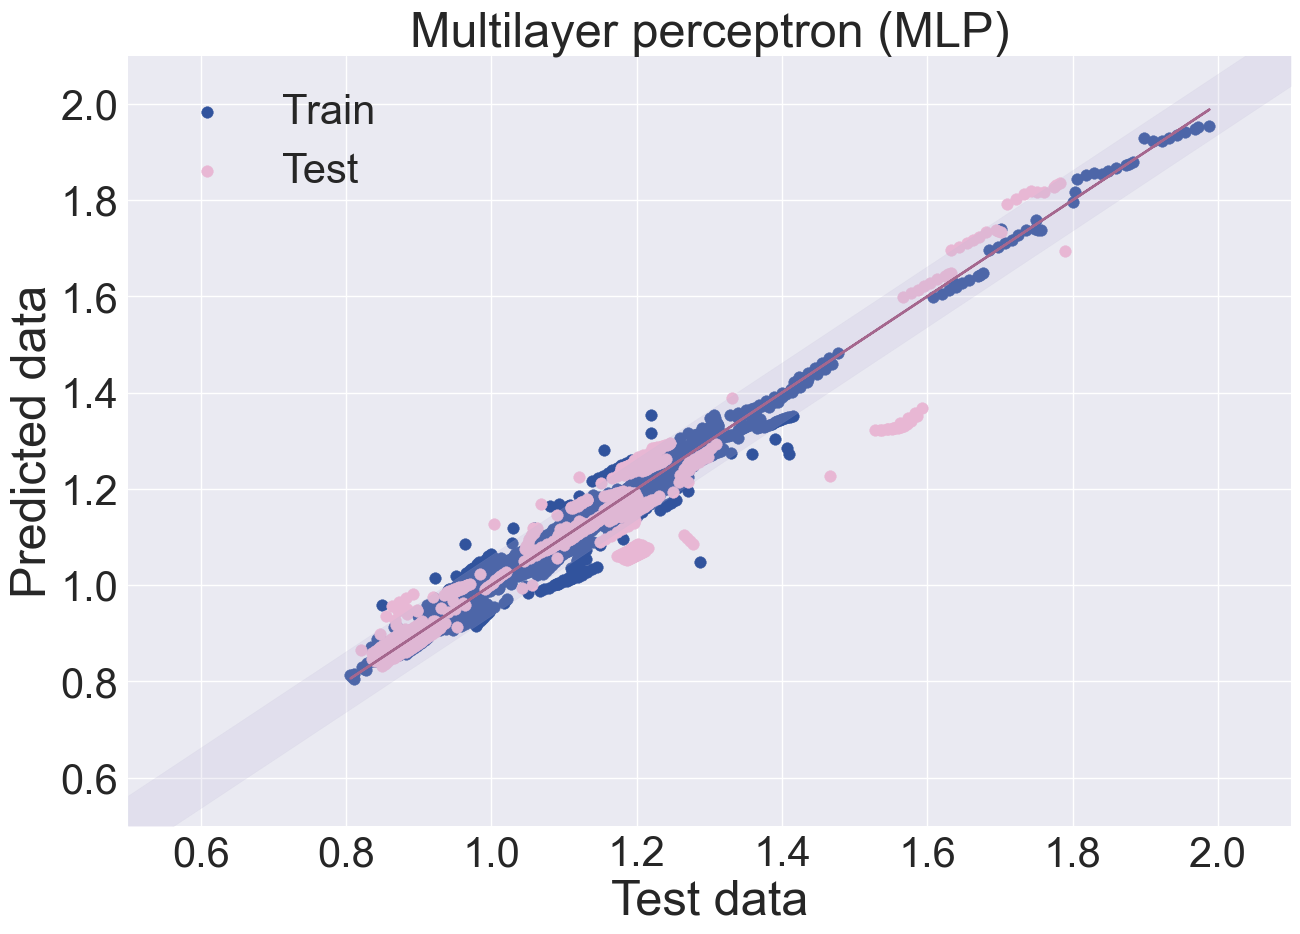

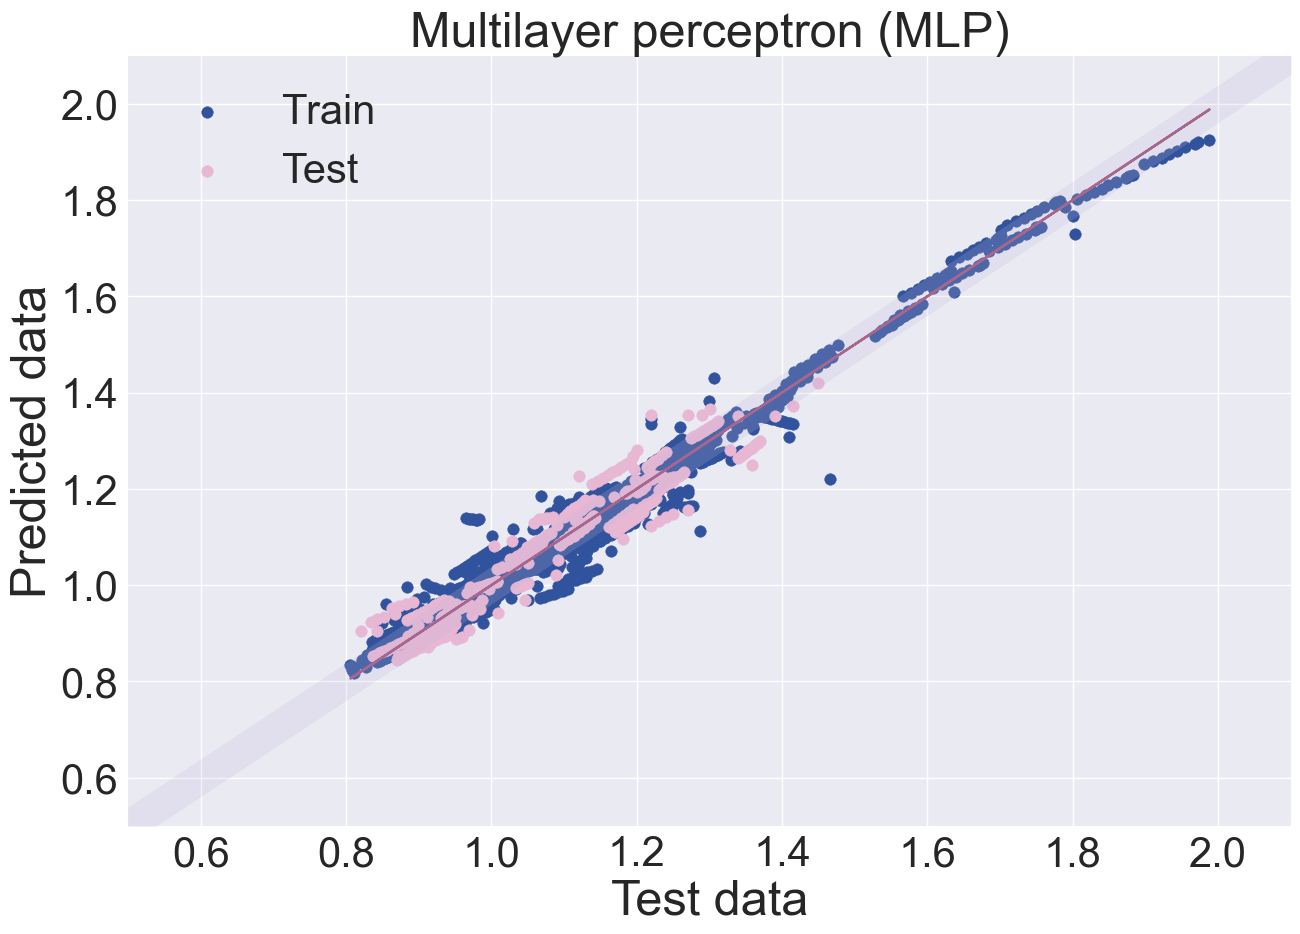

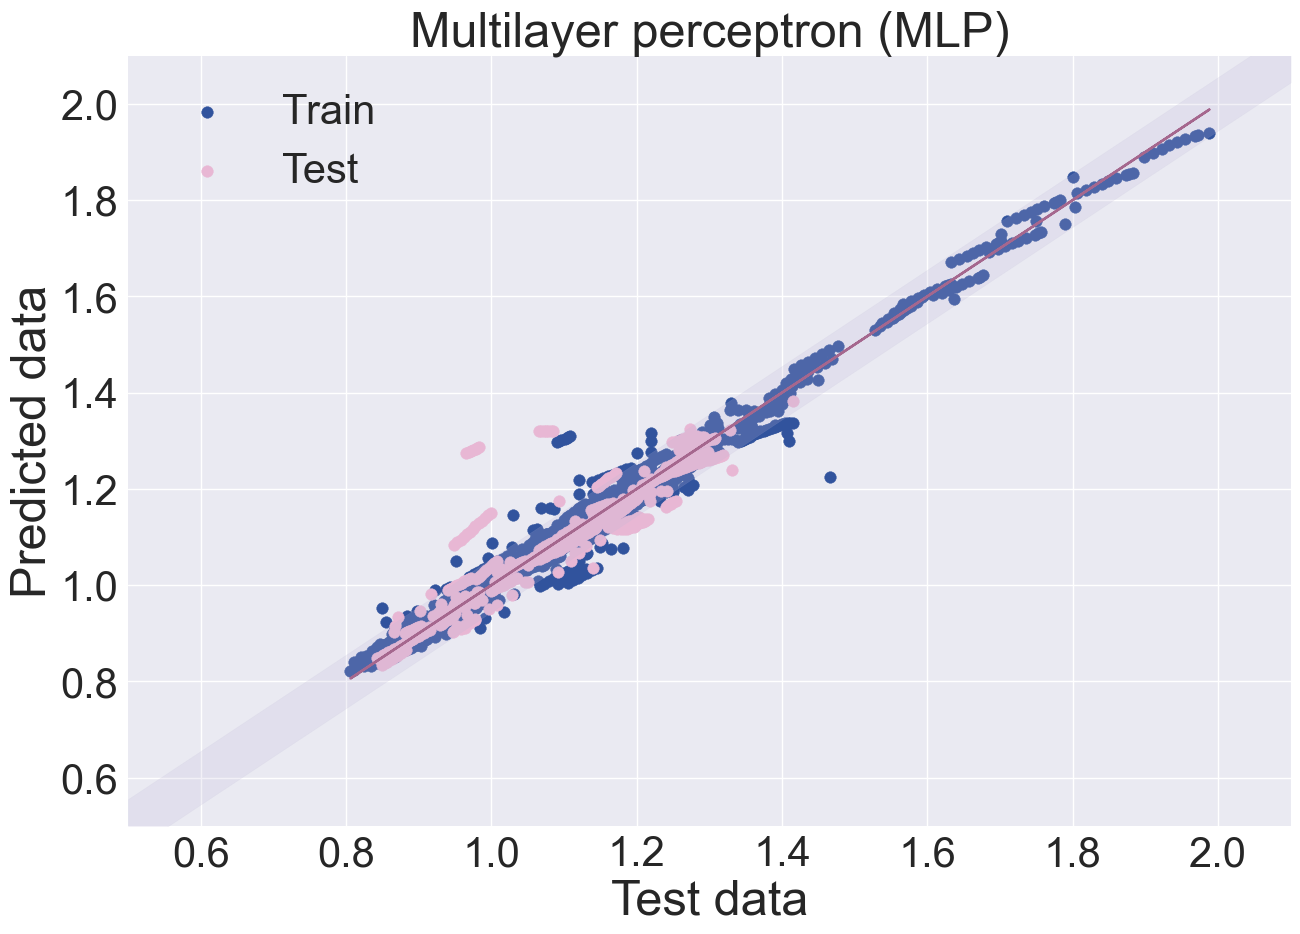

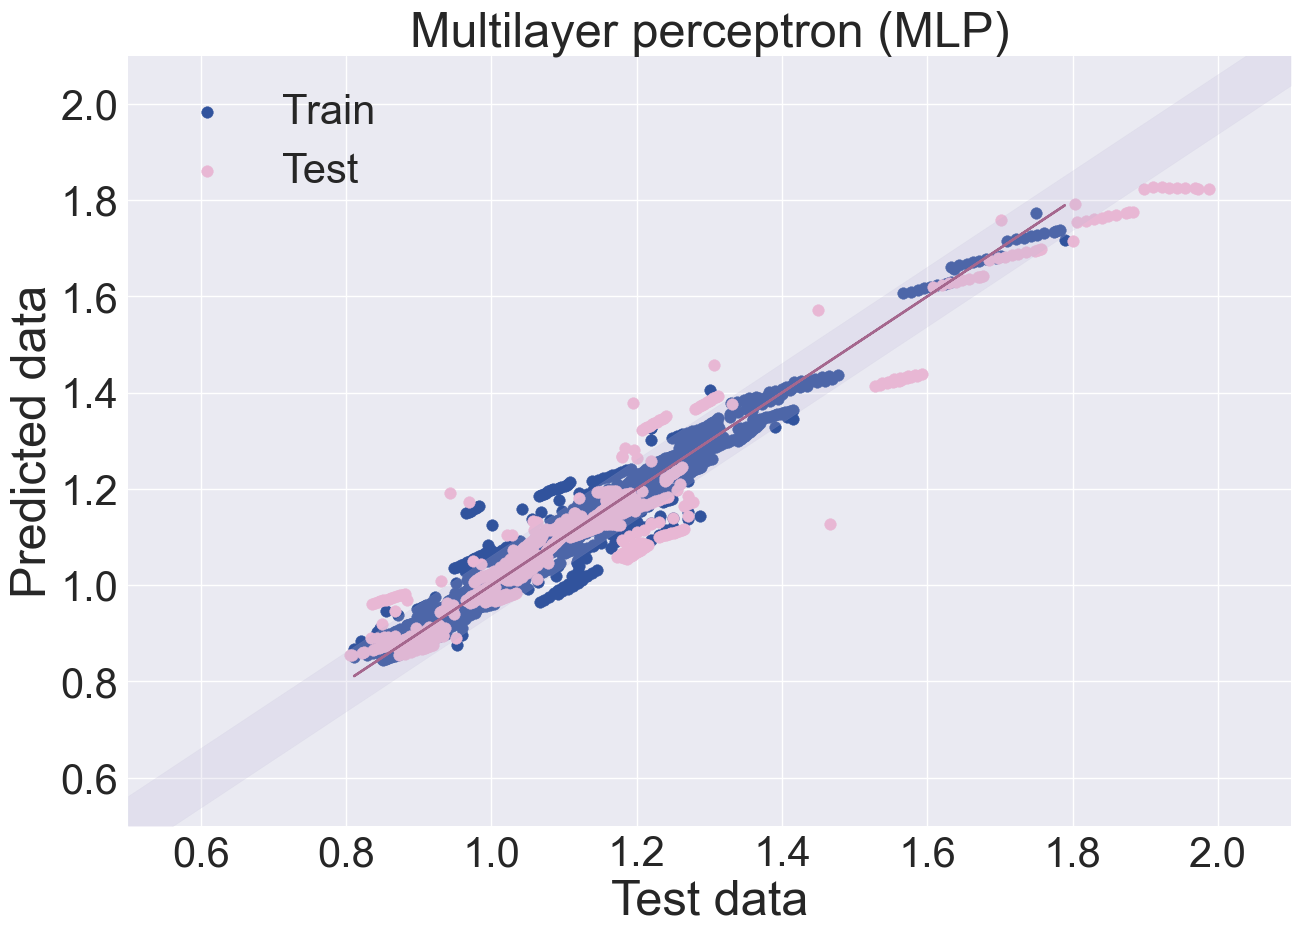

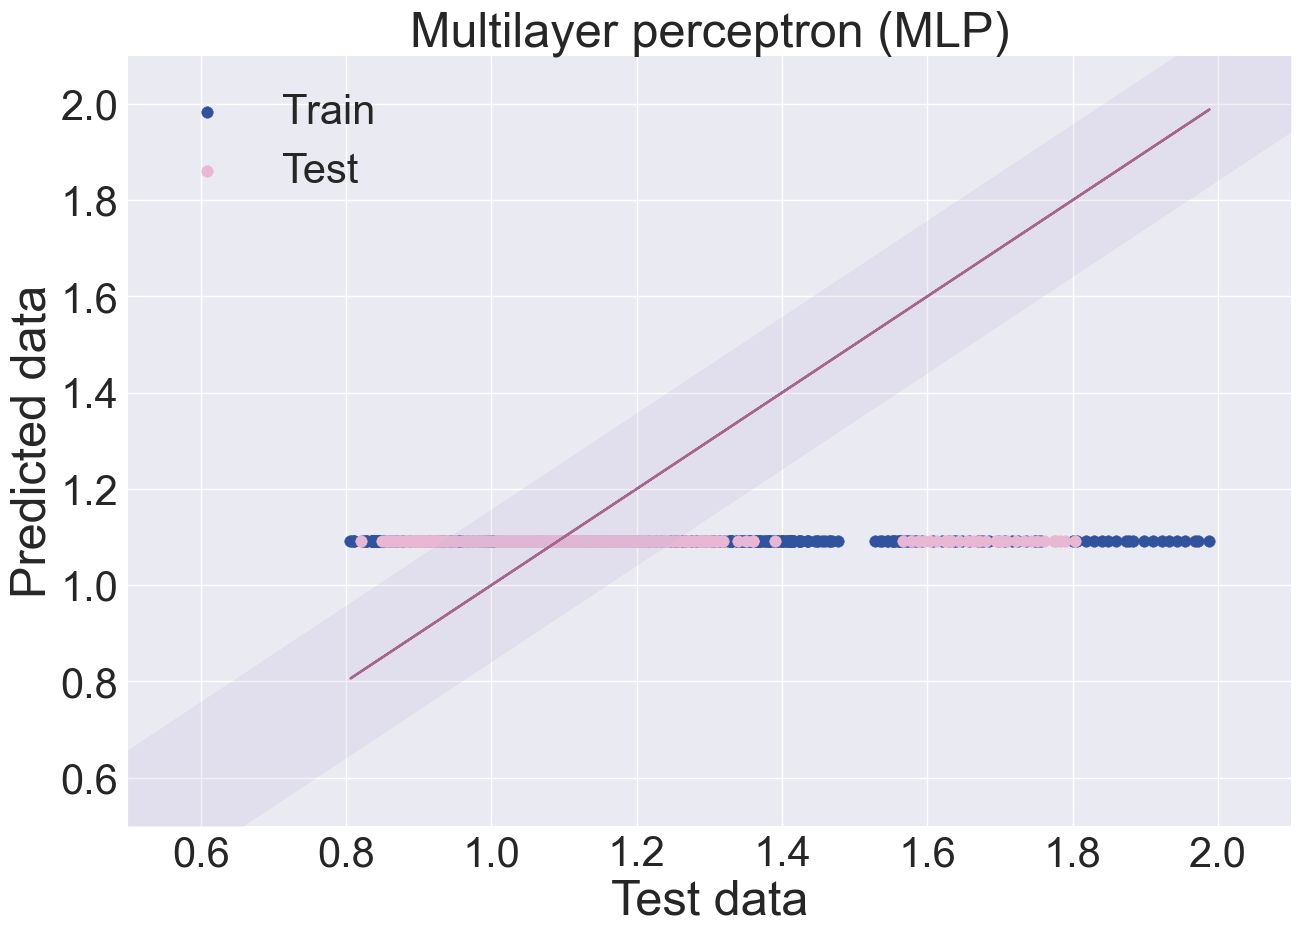

In [36]:
#MLP
count = 0
#Creating a table to check accuracy on different DES classes
MLP_df = x_model[:]
MLP_df['Density_lit'] = y_model
for train_idx, val_idx in cv:
    x_train_mod, x_test_mod = x_model.iloc[train_idx], x_model.iloc[val_idx]
    y_train_mod, y_test_mod = y_model.iloc[train_idx], y_model.iloc[val_idx]
    sample_w = compute_sample_weight('balanced', y=(x_train_mod[['I','II','III','IV','V']]))
    
    #Scaling the data
    sc = MinMaxScaler(feature_range=(0, 1))
    x_train_mod = sc.fit_transform(x_train_mod)
    x_test_mod = sc.transform(x_test_mod)
    #K-nearest neighbors
    MLP_regr = MLPRegressor(max_iter = 500, hidden_layer_sizes= hidden_layer_sizes, activation=activation, solver=solver, learning_rate= learning_rate, learning_rate_init=learning_rate_init, alpha=alpha)
    MLP_regr.fit(x_train_mod, y_train_mod)#,sample_weight=sample_w)
    y_pred = MLP_regr.predict(x_test_mod)
    y1_pred = MLP_regr.predict(x_train_mod)
    #Filling in the table in accordance with the metrics
    MLP_df['Density_train' + str(count)] = None
    MLP_df['Density_test' + str(count)] = None
    MLP_df['Density_train' + str(count)].iloc[train_idx] = y1_pred
    MLP_df['Density_test' + str(count)].iloc[val_idx] = y_pred
    #Calculating metrics
    df_error_train['Multilayer perceptron (MLP)' + str(count)] = regr_metrics(MLP_df, x_train_mod, y_train_mod, y_test_mod, y_pred, y1_pred)
    count +=1
    #Plotting a graph
    regr_plot(y_train_mod, y_test_mod, y_pred, y1_pred)
    plt.title('Multilayer perceptron (MLP)', fontsize=35)
df_error_train

In [37]:
df_error_MLP = metrics_class(MLP_df, 'Multilayer perceptron (MLP)')
df_error_MLP

R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.
R^2 score is not well-defined with less than two samples.


Algorithm MO  Num_comp  Type  R2_train    R2_test  \
0   Multilayer perceptron (MLP)0         2     I  0.913285        NaN   
1   Multilayer perceptron (MLP)0         2   III  0.945895   0.862433   
2   Multilayer perceptron (MLP)0         2    IV  0.807573   0.214405   
3   Multilayer perceptron (MLP)0         2     V  0.966071   0.899641   
4   Multilayer perceptron (MLP)0         3  None  0.993015   0.837922   
5   Multilayer perceptron (MLP)1         2     I  0.755279        NaN   
6   Multilayer perceptron (MLP)1         2   III  0.935583   0.871292   
7   Multilayer perceptron (MLP)1         2    IV  0.988392  -1.954124   
8   Multilayer perceptron (MLP)1         2     V  0.931931   0.915656   
9   Multilayer perceptron (MLP)1         3  None  0.993220    0.89554   
10  Multilayer perceptron (MLP)2         2     I  0.797990       None   
11  Multilayer perceptron (MLP)2         2   III  0.944377   0.942027   
12  Multilayer perceptron (MLP)2         2    IV  0.959551       None   
13  Multilayer perceptron (MLP)2         2     V  0.958621   0.157546   
14  Multilayer perceptron (MLP)2         3  None  0.994578   0.308674   
15  Multilayer perceptron (MLP)3         2     I  0.725485        NaN   
16  Multilayer perceptron (MLP)3         2   III  0.938106   0.861865   
17  Multilayer perceptron (MLP)3         2    IV  0.922251  -1.876411   
18  Multilayer perceptron (MLP)3         2     V  0.909772   0.754223   
19  Multilayer perceptron (MLP)3         3  None  0.992518   0.881707   
20  Multilayer perceptron (MLP)4         2     I -0.845394  -3.883455   
21  Multilayer perceptron (MLP)4         2   III -0.004741  -0.007837   
22  Multilayer perceptron (MLP)4         2    IV -5.038129 -11.780445   
23  Multilayer perceptron (MLP)4         2     V -0.611947   -0.64776   
24  Multilayer perceptron (MLP)4         3  None -0.538569  -2.144367   

    RMSE_train RMSE_test  
0     0.019061  0.122587  
1     0.021497  0.032048  
2     0.027910  0.161603  
3     0.026212  0.035943  
4     0.026452  0.085752  
5     0.032021  0.077071  
6     0.023137  0.035121  
7     0.015115  0.055657  
8     0.036343  0.039356  
9     0.022374  0.040218  
10    0.032787      None  
11    0.021197  0.023067  
12    0.025589      None  
13    0.028837  0.108109  
14    0.022517  0.057133  
15    0.036949  0.084972  
16    0.023583  0.028601  
17    0.026331  0.130531  
18    0.042038  0.064741  
19    0.022536  0.094544  
20    0.098390  0.132591  
21    0.094058  0.087183  
22    0.308554  0.092949  
23    0.178736  0.158075  
24    0.324181  0.458595

**Output:** The algorithms given in this chapter have shown good results, but they work worse than boosters

## 6. General graphs
For a visual comparison of all algorithms, graphs were constructed showing the dependence of R2 and RMSE from algorithm to algorithm

### 6.1. Graphs for various ML algorithms

In [38]:
#General table obtained after cross-validation
df_error_train.index = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test']
df_error_train

Linear Regression0  Linear Regression1  Linear Regression2  \
R2_train              0.865267            0.875157            0.891615   
R2_test               0.848835            0.081853            0.582314   
RMSE_train            0.055925            0.058167            0.056129   
RMSE_test             0.074325            0.131807            0.074126   

            Linear Regression3  Linear Regression4  Decision Tree Regression0  \
R2_train              0.851805            0.894298                   0.730336   
R2_test               0.814534            0.807343                   0.645512   
RMSE_train            0.054540            0.052841                   0.079119   
RMSE_test             0.093083            0.068789                   0.113818   

            Decision Tree Regression1  Decision Tree Regression2  \
R2_train                     0.688789                   0.897105   
R2_test                      0.426653                   0.022131   
RMSE_train                   0.091837                   0.054689   
RMSE_test                    0.104158                   0.113418   

            Decision Tree Regression3  Decision Tree Regression4  ...  \
R2_train                     0.784980                   0.799245  ...   
R2_test                      0.762418                   0.802704  ...   
RMSE_train                   0.065696                   0.072823  ...   
RMSE_test                    0.105353                   0.069613  ...   

            K-nearest neighbors0  K-nearest neighbors1  K-nearest neighbors2  \
R2_train                0.958987              0.965847              0.967302   
R2_test                 0.846288              0.836668              0.751638   
RMSE_train              0.030855              0.030423              0.030829   
RMSE_test               0.074949              0.055593              0.057159   

            K-nearest neighbors3  K-nearest neighbors4  \
R2_train                0.964577              0.969923   
R2_test                 0.888110              0.864079   
RMSE_train              0.026665              0.028187   
RMSE_test               0.072299              0.057779   

            Multilayer perceptron (MLP)0  Multilayer perceptron (MLP)1  \
R2_train                        0.976909                      0.973888   
R2_test                         0.891979                      0.922606   
RMSE_train                      0.023152                      0.026602   
RMSE_test                       0.062830                      0.038268   

            Multilayer perceptron (MLP)2  Multilayer perceptron (MLP)3  \
R2_train                        0.980491                      0.956786   
R2_test                         0.765438                      0.917797   
RMSE_train                      0.023813                      0.029452   
RMSE_test                       0.055548                      0.061970   

            Multilayer perceptron (MLP)4  
R2_train                   -3.481659e-13  
R2_test                    -1.298793e-02  
RMSE_train                  1.625298e-01  
RMSE_test                   1.577358e-01  

[4 rows x 45 columns]

In [39]:
#Table with averages and deviations for metrics
df_error_train_1 = df_error_train.transpose()
f_get_name = lambda x: x[:-1]
df_error_train_1['Regr'] = df_error_train_1.index
df_error_train_1['Regr'] = df_error_train_1['Regr'].apply(f_get_name)
df_error_train_1 = df_error_train_1.groupby('Regr').agg(['mean', 'std'])
df_error_train_1.columns = ['_'.join(col).rstrip('_') for col in df_error_train_1.columns.values] #Названия для новых столбцов
df_error_train_1

R2_train_mean  R2_train_std  R2_test_mean  \
Regr                                                                      
Cat Boosting Regression            0.990169      0.002332      0.871995   
Decision Tree Regression           0.780091      0.078890      0.531884   
Gradient Boosting Regression       0.970201      0.009406      0.776812   
K-nearest neighbors                0.965327      0.004064      0.837357   
Linear Regression                  0.875629      0.017883      0.626976   
Multilayer perceptron (MLP)        0.777615      0.434795      0.696966   
Random Forest Regression           0.774169      0.077893      0.674451   
Support Vector Machine             0.970453      0.006929      0.805884   
XGBoosting Regression              0.985682      0.002047      0.874522   

                              R2_test_std  RMSE_train_mean  RMSE_train_std  \
Regr                                                                         
Cat Boosting Regression          0.047486         0.015509        0.000890   
Decision Tree Regression         0.320282         0.072833        0.013972   
Gradient Boosting Regression     0.080635         0.026824        0.002352   
K-nearest neighbors              0.051764         0.029392        0.001881   
Linear Regression                0.322524         0.055520        0.001980   
Multilayer perceptron (MLP)      0.402005         0.053110        0.061219   
Random Forest Regression         0.127773         0.073635        0.007934   
Support Vector Machine           0.114810         0.026898        0.001354   
XGBoosting Regression            0.039140         0.018834        0.000215   

                              RMSE_test_mean  RMSE_test_std  
Regr                                                         
Cat Boosting Regression             0.057243       0.016387  
Decision Tree Regression            0.101272       0.018250  
Gradient Boosting Regression        0.075018       0.017678  
K-nearest neighbors                 0.063556       0.009273  
Linear Regression                   0.088426       0.025945  
Multilayer perceptron (MLP)         0.075270       0.047144  
Random Forest Regression            0.089242       0.017762  
Support Vector Machine              0.068043       0.021238  
XGBoosting Regression               0.055870       0.009175

In [40]:
df_error_train_1 = df_error_train_1.drop(index= 'Linear Regression')

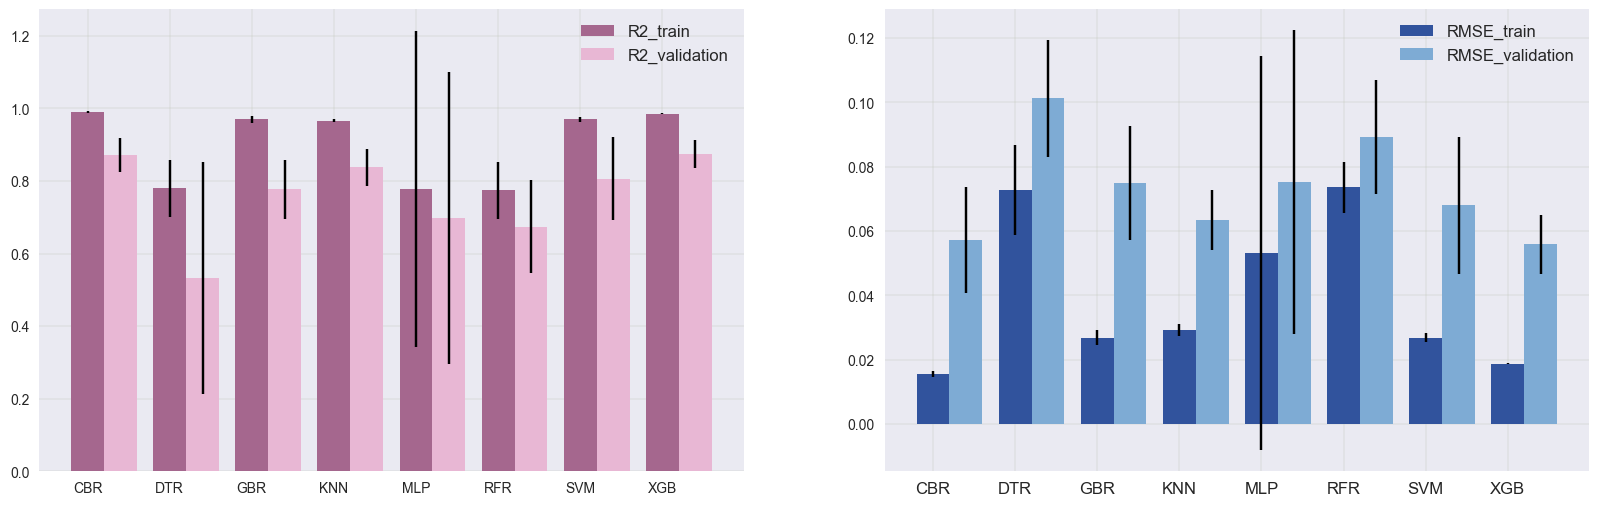

In [41]:
import matplotlib.patches as mpatches
#Let's build a graph that will help compare the methods by the main metrics

barWidth = 0.4

br1 = np.arange(8)
br2 = [x + barWidth for x in br1]
br3 =  np.arange(8)
br4 = [x + barWidth for x in br3]

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))

ax1.bar(br1, df_error_train_1['R2_train_mean'], color =colors[0], width = barWidth, label ='R2_train', yerr = df_error_train_1['R2_train_std'])
ax1.bar(br2, df_error_train_1['R2_test_mean'], color =colors[1], width = barWidth, label ='R2_validation', yerr = df_error_train_1['R2_test_std'])

ax2.bar(br3, df_error_train_1['RMSE_train_mean'], color =colors[4], width = barWidth, label ='RMSE_train', yerr = df_error_train_1['RMSE_train_std'])
ax2.bar(br4, df_error_train_1['RMSE_test_mean'], color =colors[3], width = barWidth, label ='RMSE_validation', yerr = df_error_train_1['RMSE_test_std'])

plt.xticks(br1, ['CBR','DTR','GBR','KNN','MLP','RFR','SVM', 'XGB'], fontsize = 12)
        
ax1.grid(color='#C3C6BA', linewidth=0.3)
ax2.grid(color='#C3C6BA', linewidth=0.3)


ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)


### 6.2. Graphs for various types of DES
Also, to understand how well the models predict values for different types of DES, we will build graphs that will help you see this

In [42]:
# Let's gather all the tables into one
df_error_types = df_error_CBR.append((df_error_DTR, df_error_GBR, df_error_KNN, df_error_MLP, df_error_RFR, df_error_SVM, df_error_XGB))
df_error_types['Type'] = df_error_types['Type'].fillna(0)
df_error_types

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Algorithm MO  Num_comp Type  R2_train    R2_test  RMSE_train  \
0   Cat Boosting Regression0         2    I  0.998979        NaN    0.002068   
1   Cat Boosting Regression0         2  III  0.960817   0.567786    0.018294   
2   Cat Boosting Regression0         2   IV  0.997701   0.728903    0.003051   
3   Cat Boosting Regression0         2    V  0.996117   0.903351    0.008867   
4   Cat Boosting Regression0         3    0  0.997746   0.601728    0.015025   
..                       ...       ...  ...       ...        ...         ...   
20    XGBoosting Regression4         2    I  0.999307   0.937957    0.001906   
21    XGBoosting Regression4         2  III  0.942520    0.46717    0.022497   
22    XGBoosting Regression4         2   IV  0.999228 -26.181677    0.003490   
23    XGBoosting Regression4         2    V  0.991994   0.833529    0.012597   
24    XGBoosting Regression4         3    0  0.997886   0.985708    0.012017   

   RMSE_test  
0   0.027625  
1   0.056806  
2   0.094932  
3   0.035272  
4   0.134422  
..       ...  
20  0.014945  
21  0.063391  
22  0.135554  
23  0.050244  
24  0.030918  

[200 rows x 7 columns]

In [43]:
#Table with averages and deviations for metrics
f_get_name = lambda x: x[:-1]
#df_error_types['Algorithm MO'] = df_error_types.index
df_error_types['Algorithm MO'] = df_error_types['Algorithm MO'].apply(f_get_name)
df_error_types = df_error_types.groupby(['Algorithm MO','Num_comp', 'Type']).agg(['mean', 'std'])
df_error_types.columns = ['_'.join(col).rstrip('_') for col in df_error_types.columns.values] #Names for new columns
df_error_types = df_error_types.reset_index()
df_error_types

Algorithm MO  Num_comp Type  R2_train_mean  R2_train_std  \
0        Cat Boosting Regression         2    I       0.998665      0.000668   
1        Cat Boosting Regression         2  III       0.962244      0.003565   
2        Cat Boosting Regression         2   IV       0.998858      0.000676   
3        Cat Boosting Regression         2    V       0.995477      0.000746   
4        Cat Boosting Regression         3    0       0.997826      0.000810   
5        Decision Tree Regressor         2    I      -2.292458      2.271373   
6        Decision Tree Regressor         2  III       0.487486      0.210608   
7        Decision Tree Regressor         2   IV       0.361796      0.381709   
8        Decision Tree Regressor         2    V       0.789062      0.209869   
9        Decision Tree Regressor         3    0       0.755442      0.254570   
10  Gradient Boosting Regression         2    I       0.994625      0.002419   
11  Gradient Boosting Regression         2  III       0.893627      0.018194   
12  Gradient Boosting Regression         2   IV       0.993652      0.004444   
13  Gradient Boosting Regression         2    V       0.980303      0.003647   
14  Gradient Boosting Regression         3    0       0.993375      0.002219   
15           K-nearest neighbors         2    I       0.407614      0.123049   
16           K-nearest neighbors         2  III       0.947444      0.009447   
17           K-nearest neighbors         2   IV       0.921280      0.073617   
18           K-nearest neighbors         2    V       0.962201      0.003143   
19           K-nearest neighbors         3    0       0.932693      0.012479   
20   Multilayer perceptron (MLP)         2    I       0.469329      0.738410   
21   Multilayer perceptron (MLP)         2  III       0.751844      0.422966   
22   Multilayer perceptron (MLP)         2   IV      -0.272072      2.665192   
23   Multilayer perceptron (MLP)         2    V       0.630890      0.695126   
24   Multilayer perceptron (MLP)         3    0       0.686952      0.685088   
25      Random Forest Regression         2    I      -1.540867      1.294272   
26      Random Forest Regression         2  III       0.429822      0.080158   
27      Random Forest Regression         2   IV       0.717806      0.268128   
28      Random Forest Regression         2    V       0.807381      0.030551   
29      Random Forest Regression         3    0       0.729601      0.209626   
30        Support Vector Machine         2    I       0.982243      0.003732   
31        Support Vector Machine         2  III       0.942541      0.005465   
32        Support Vector Machine         2   IV       0.994869      0.004152   
33        Support Vector Machine         2    V       0.919868      0.019489   
34        Support Vector Machine         3    0       0.998164      0.000947   
35         XGBoosting Regression         2    I       0.998820      0.000612   
36         XGBoosting Regression         2  III       0.943291      0.002984   
37         XGBoosting Regression         2   IV       0.998413      0.001274   
38         XGBoosting Regression         2    V       0.993662      0.001830   
39         XGBoosting Regression         3    0       0.997577      0.000420   

    R2_test_mean  R2_test_std  RMSE_train_mean  RMSE_train_std  \
0       0.597133          NaN         0.002455        0.000485   
1       0.709096     0.112203         0.017940        0.000894   
2      -7.643357    11.782134         0.003396        0.000237   
3       0.865667     0.089039         0.009443        0.000728   
4       0.824727     0.151213         0.012935        0.002084   
5      -7.324535          NaN         0.116248        0.060479   
6      -0.084571     0.486354         0.065175        0.011792   
7     -20.777858    27.900237         0.089474        0.046627   
8       0.682711     0.257112         0.059244        0.027923   
9       0.484540     0.353359         0.126103        0.080626   
10      0.979

invalid value encountered in reduce
invalid value encountered in reduce


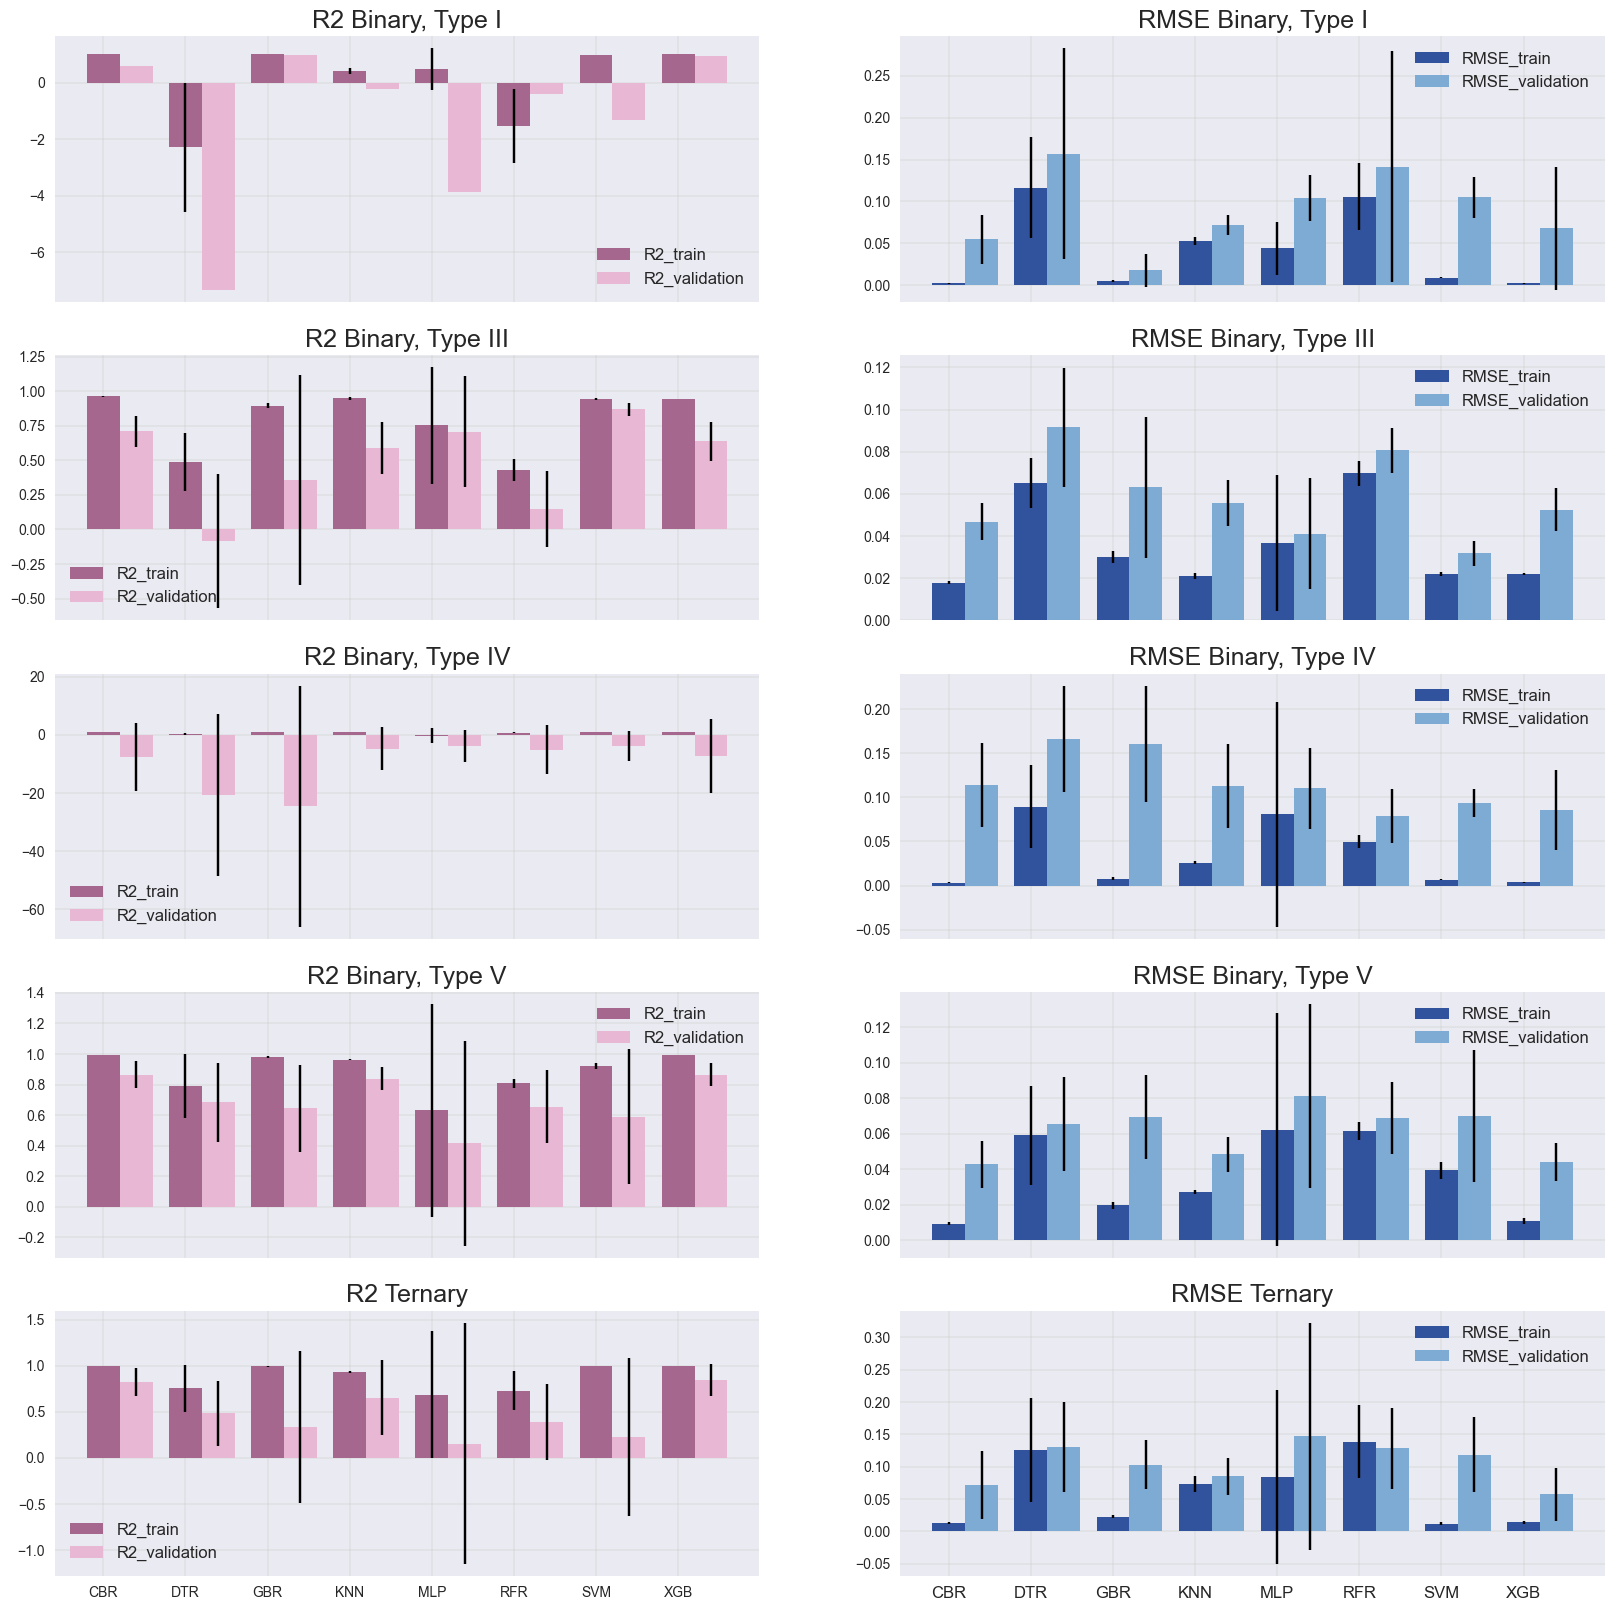

In [44]:
#Let's build a graph that will help compare the methods by the main metrics

barWidth = 0.4

br1 = np.arange(8)
br2 = [x + barWidth for x in br1]
br3 =  np.arange(8)
br4 = [x + barWidth for x in br3]

fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(20, 20))

count = 0
conditions = [df_error_types['Type'] == 'I', df_error_types['Type'] == 'III', df_error_types['Type'] == 'IV', df_error_types['Type'] == 'V', df_error_types['Num_comp'] == 3]
Names = ['Binary, Type I', 'Binary, Type III', 'Binary, Type IV', 'Binary, Type V', 'Ternary']
for i in range(5):
  ax[i][0].bar(br1, df_error_types[conditions[count]]['R2_train_mean'], color =colors[0], width = barWidth, label ='R2_train', yerr = df_error_types[conditions[count]]['R2_train_std'])
  ax[i][0].bar(br2, df_error_types[conditions[count]]['R2_test_mean'], color =colors[1], width = barWidth, label ='R2_validation', yerr = df_error_types[conditions[count]]['R2_test_std'])
  ax[i][0].set_title('R2' + ' ' + Names[count], fontsize = 18)
  plt.xticks(br1, ['CBR','DTR','GBR','KNN','MLP','RFR','SVM', 'XGB'], fontsize = 12)

  ax[i][1].bar(br3, df_error_types[conditions[count]]['RMSE_train_mean'], color =colors[4], width = barWidth, label ='RMSE_train', yerr = df_error_types[conditions[count]]['RMSE_train_std'])
  ax[i][1].bar(br4, df_error_types[conditions[count]]['RMSE_test_mean'], color =colors[3], width = barWidth, label ='RMSE_validation', yerr = df_error_types[conditions[count]]['RMSE_test_std'])
  ax[i][1].set_title(('RMSE' + ' ' + Names[count]), fontsize = 18)
  plt.xticks(br3, ['CBR','DTR','GBR','KNN','MLP','RFR','SVM', 'XGB'], fontsize = 12)
  
          
  ax[i][0].grid(color='#C3C6BA', linewidth=0.3)
  ax[i][1].grid(color='#C3C6BA', linewidth=0.3)


  ax[i][0].legend(fontsize = 12)
  ax[i][1].legend(fontsize = 12)
  count += 1

## General conclusions:
The highest results were shown by Cut Boost, Boost, Multilawyer perceptron on the validation sample, model data accuracy up to R2 = 0.88, and RMSE equal to 0.06. Cat Boost was chosen as the main model, as it shows good results on all types of DES